# Energy spectra in 3D in time
In this notebook the performance of the 3D spectra in time and space is done. For running this python notebook you need a time series of $\eta(x,yt)$ with shape $(N_t,N,N)$. Look into **create_etafile.ipynb** for the creation of this time series. 

In [1]:
import gc
import os
import sys
import warnings
import math as m

# Paths
sys.path.extend([
    '/projects/DEIKE/cmartinb/jupyter_notebook/project_specific/turbulence',
    '/projects/DEIKE/cmartinb/functions',
])

# Work directory
os.chdir('/projects/DEIKE/cmartinb/')

# Remove warnings about time
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import pylab
import scipy
from scipy import stats
import scipy.interpolate
from scipy.signal import butter, filtfilt, find_peaks, hilbert

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.tri as mtri
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

# Own modules

from prepare import load_object, save_object, field
from defs import Case, Interface2D
from phase import extract_phase
from funciones import *
from branches import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks


import numpy as np
import scipy.interpolate
from scipy.interpolate import RegularGridInterpolator
import multiprocessing as mp
import time

from spectrum_utils import (
    pol2cart,
    process_subdivision,
    spectrum3D_subdivisions_parallel
)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.signal import find_peaks

import numpy as np
import scipy.interpolate
from scipy.interpolate import RegularGridInterpolator
import multiprocessing as mp
import time


## Common parameters 

In [2]:
params = {'legend.fontsize': 'xx-Large',
          'figure.figsize': (15, 6),
         'axes.labelsize': 30,
         'axes.titlesize':30,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
    'font.family': 'STIXGeneral', 
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True, # Enable LaTeX rendering
}

plt.rcParams.update(params)
pylab.rcParams.update(params)

## Define case

In [3]:
kpHs = '0p16' # 0p16 
uoc = '0p50' # 0p50 0p75
reW = '2.5e4' #1.0e5
reA = 720
maxLevel = 10 #11
Bo=200 # 1000,25

if reW == '1.0e5':
    Re_water = 1 * 10**5
else:
    Re_water = 2.5 * 10**4

if uoc == '0p75':
    N = 1024
else:
    N = 512 

if maxLevel== 11:
    N = 1024
else:
    N = 512 

#Common parameters 
kp = 4
u = 0.25
lambdap = 2*m.pi/kp

rho1 = 1
rho2 = 1.25*10**(-3)

L0 = 2*np.pi;

ak,  c, omegap, nu_water, g, uoc_val, sigma, Tp= calculate_parameters(kpHs, uoc , u ,kp, Bo, rho1, rho2)
print('ak is', ak, 'c is' ,c, 'w_p$ is', omegap, '$\nu_w$ is' , nu_water, 'g is' ,g, 'N', N)

ak is 0.16 c is 0.5 w_p$ is 2.0 $
u_w$ is 3.141592653589793e-05 g is 0.9950310636260177 N 512


In [4]:
work_dir = f'/projects/DEIKE/nscapin/broadband_reorder/re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}/'
#work_dir = f'/projects/DEIKE/cmartinb/cases_multiphase_broadbanded/re{reA}_bo{Bo}_kpHs{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}/'

data = np.loadtxt(work_dir+'eta/global_int.out')
istep_c =data[:, 1]
t = data[:,0] 
print(t.shape)

(1246,)


### Creation directory and path for graphs 3D spectra

In [5]:
graph_path = f'/projects/DEIKE/cmartinb/notebooks/graphs/re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}/3Dspectra/'
if not os.path.exists(graph_path):
    os.makedirs(graph_path)

### Load eta series

In [6]:
eta_series = np.load(f'/projects/DEIKE/cmartinb/eta/eta_series_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}.npy', allow_pickle=True)
print(eta_series.shape)
print(t.shape)

(1246, 512, 512)
(1246,)


#### Load the time and select times where energy grows

In [7]:
tstart = t[0]
indice = np.argmax(omegap*(t - tstart) > 5)
print(indice)

eta_series_trimmed = eta_series[indice:, :]

print(eta_series_trimmed.shape)
t = t[indice:]

eta_series = eta_series_trimmed
print(t.shape)

26
(1220, 512, 512)
(1220,)


In [8]:
print(eta_series.shape[1])
data = eta_series

ln = 150 #interval length 
N = N
ak = ak
DataEta = eta_series
t = t

512


#### Function that execute the 3D spectrum with overlap of $50\%$. The function **spectrum3D_subdivisions_parallel** can be found in spectrum_utils.py

In [9]:
'''
def pol2cart(r, theta):
    """Convierte coordenadas polares a cartesianas."""
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def process_subdivision(args):
    """
    Procesa una subdivisión del conjunto de datos.
    
    Parámetros:
      - start_idx: índice de inicio de la subdivisión.
      - ln: longitud de la subdivisión.
      - DataEta: arreglo 3D (tiempo, y, x) de datos.
      - time: vector de tiempos.
      - N: número de puntos espaciales.
      - ak: valor usado para el factor de normalización.
      - zero_padding: bool para aplicar zero-padding.
      - CHECK: bool para imprimir información de control.
      - normalization_factor: factor de normalización, si ya se calculó.
    """
    start_idx, ln, DataEta, time, N, ak, zero_padding, CHECK, normalization_factor = args
    overlap_factor = 0.5
    overlap = int(ln * overlap_factor)
    end_idx = start_idx + ln
    if end_idx > len(DataEta):
        return None  # Se ignora subdivisión incompleta
    
    # Extraer la subdivisión
    time_subdivision = np.array(time[start_idx:end_idx])
    data_subdivision = np.array(DataEta[start_idx:end_idx])
    kpHs = 4 *kp* np.sqrt(np.var(data_subdivision))

    if CHECK:
        print(kpHs)
        print(f"Procesando subdivisión desde {start_idx} hasta {end_idx}. Varianza: {np.var(data_subdivision)}")
    
    # Aplicar ventana de Hann de forma vectorizada (broadcasting)
    hann_window = np.hanning(ln)[:, None, None]  # Redimensiona a (ln,1,1)
    data_subdivision *= hann_window
    
    # Aplicar zero-padding si se requiere
    if zero_padding:
        padding_length = 200  # Ajusta este valor según necesidad
        data_subdivision = np.pad(data_subdivision, ((0, padding_length), (0,0), (0,0)), mode='constant')
    
    dt = time_subdivision[1] - time_subdivision[0]
    L0 = 2 * np.pi
    dx = L0 / N
    dy = L0 / N
    
    # Calcular frecuencias y números de onda
    omega = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(data_subdivision.shape[0], dt))
    wavenumber = 2 * np.pi * np.fft.fftfreq(N, L0 / N)
    theta = np.linspace(0, 2 * np.pi, N)
    kx = np.fft.fftshift(wavenumber)
    ky = kx.copy()
    k = wavenumber[:int(N/2)]

    # Realizar la FFT 3D
    spectrum3D = np.fft.fftn(data_subdivision) * np.sqrt(ln) / np.sqrt(N**2)
    spectrum3D = np.fft.fftshift(spectrum3D, axes=(0, 1, 2))
    F_3D = (np.abs(spectrum3D))**2 / (N * N)
    
    # Calcular el espectro de amplitud
    amplitudes = np.sqrt(np.real(spectrum3D)**2 + np.imag(spectrum3D)**2) * np.sqrt(ln * N**2)
    rms_amplitude = np.sqrt(np.mean(amplitudes**2))
    
    # Calcular el factor de normalización (en la primera subdivisión)
    if normalization_factor is None:
        k_index_arr = np.where(np.isclose(k, 4))[0]
        if k_index_arr.size > 0:
            k_index = k_index_arr[0]
            amplitude_k4 = amplitudes[0, 0, k_index]
            normalization_factor = ak / amplitude_k4 if amplitude_k4 != 0 else 1
            if CHECK:
                print(f"Normalization factor computed: {normalization_factor}")
        else:
            normalization_factor = 1
            if CHECK:
                print("k=4 not found, using normalization factor = 1")
    
    amplitudes *= normalization_factor
    
    # Preparar grillas para la interpolación
    kx_tile, ky_tile = np.meshgrid(kx, ky)      # Grilla en kx-ky (regular)
    k_tile, theta_tile = np.meshgrid(k, theta)    # Grilla en k-theta
    kxp_tile, kyp_tile = pol2cart(k_tile, theta_tile)
    Omega, K_grid = np.meshgrid(omega, k)
    
    # Inicializar listas para almacenar resultados para cada frecuencia (dimensión temporal de la FFT)
    F_xy_interval = []
    F_komega_interval = []
    F_ktheta_interval = []
    amplitudes_k_interval = []
    u_sf_k_interval = []  # Placeholder para futuros cálculos
    
    dtheta = theta[1] - theta[0] if len(theta) > 1 else 1
    
    # Para cada frecuencia, interpolar F_xy a F_ktheta usando RegularGridInterpolator
    for idx in range(data_subdivision.shape[0]):
        F_xy = F_3D[idx]  # Array 2D correspondiente a la frecuencia idx
        interp_func = RegularGridInterpolator((ky, kx), F_xy, method='nearest')
        points = np.column_stack((kyp_tile.ravel(), kxp_tile.ravel()))
        F_ktheta = interp_func(points).reshape(kxp_tile.shape)
        F_komega = np.sum(F_ktheta * k_tile, axis=0) * dtheta  # Integración sobre theta
        
        F_xy_interval.append(F_xy)
        F_komega_interval.append(F_komega)
        F_ktheta_interval.append(F_ktheta)
        u_sf_k_interval.append(np.zeros(len(k), dtype=complex))  # Si se requiere calcular
        
        amplitudes_k = np.sqrt(np.sum(np.abs(F_ktheta)**2, axis=0) * dtheta)
        amplitudes_k_interval.append(amplitudes_k)
        
        if CHECK:
            dkx = np.abs(kx[1]-kx[0]) if len(kx) > 1 else 1
            dky = np.abs(ky[1]-ky[0]) if len(ky) > 1 else 1
            domega = np.abs(omega[1]-omega[0]) if len(omega) > 1 else 1
            print(f"Freq index {idx} in subdivision {start_idx}-{end_idx}: sum(F_xy)*dkx*dky*domega = {np.sum(F_xy)*dkx*dky*domega}")
    
    result = {
        'start_idx': start_idx,
        'omega': omega,
        'eta_time': data_subdivision,
        'F_xy_interval': F_xy_interval,
        'F_komega_interval': F_komega_interval,
        'F_ktheta_interval': F_ktheta_interval,
        'amplitudes': amplitudes,
        'amplitudes_k_interval': amplitudes_k_interval,
        'rms_amplitude': rms_amplitude,
        'k': k,
        'kx': kx,
        'kx_tile': kx_tile,
        'ky_tile': ky_tile,
        'k_tile': k_tile,
        'theta_tile': theta_tile,
        'Omega': Omega,
        'K': K_grid,
        'normalization_factor': normalization_factor,
        'kpHs':kpHs
    }
    return result

def spectrum3D_subdivisions_parallel(DataEta, time, ln, N, ak, zero_padding=True, CHECK=False):
    """
    Procesa los datos en subdivisiones (superposición del 50%) de forma paralela.
    Devuelve los resultados consolidados.
    """
    overlap_factor = 0.5
    overlap = int(ln * overlap_factor)
    indices = list(range(0, len(DataEta) - overlap, ln - overlap))
    if len(indices) == 0:
        raise ValueError("No se encontraron subdivisiones válidas.")
    
    # Procesar la primera subdivisión secuencialmente para obtener el normalization_factor
    first_args = (indices[0], ln, DataEta, time, N, ak, zero_padding, CHECK, None)
    first_result = process_subdivision(first_args)
    normalization_factor = first_result['normalization_factor']
    
    results = [first_result]
    args_list = []
    for idx in indices[1:]:
        args_list.append((idx, ln, DataEta, time, N, ak, zero_padding, CHECK, normalization_factor))
    
    if args_list:
        with mp.Pool(processes=mp.cpu_count()) as pool:
            parallel_results = pool.map(process_subdivision, args_list)
        parallel_results = [res for res in parallel_results if res is not None]
        results.extend(parallel_results)
    
    # Consolidar resultados en listas
    all_F_xyomega = [res['F_xy_interval'] for res in results]
    all_F_komega = [res['F_komega_interval'] for res in results]
    all_F_ktheta = [res['F_ktheta_interval'] for res in results]
    all_amplitudes = [res['amplitudes'] for res in results]
    all_amplitudes_k = [res['amplitudes_k_interval'] for res in results]
    eta_time_list = [res['eta_time'] for res in results]
    all_kpHs = [res['kpHs'] for res in results]

    
    # Extraer los arreglos globales del primer resultado (asumidos constantes)
    k = results[0]['k']
    omega = results[0]['omega']
    k_tile = results[0]['k_tile']
    theta_tile = results[0]['theta_tile']
    kx = results[0]['kx']
    kx_tile = results[0]['kx_tile']
    ky_tile = results[0]['ky_tile']
    Omega = results[0]['Omega']
    K_grid = results[0]['K']
    
    return (k, omega, k_tile, theta_tile, kx, kx_tile, ky_tile,
            all_F_xyomega, all_F_komega, Omega, K_grid, all_F_ktheta, eta_time_list,
            all_amplitudes, all_amplitudes_k, all_kpHs)
'''

'\ndef pol2cart(r, theta):\n    """Convierte coordenadas polares a cartesianas."""\n    x = r * np.cos(theta)\n    y = r * np.sin(theta)\n    return x, y\n\ndef process_subdivision(args):\n    """\n    Procesa una subdivisión del conjunto de datos.\n    \n    Parámetros:\n      - start_idx: índice de inicio de la subdivisión.\n      - ln: longitud de la subdivisión.\n      - DataEta: arreglo 3D (tiempo, y, x) de datos.\n      - time: vector de tiempos.\n      - N: número de puntos espaciales.\n      - ak: valor usado para el factor de normalización.\n      - zero_padding: bool para aplicar zero-padding.\n      - CHECK: bool para imprimir información de control.\n      - normalization_factor: factor de normalización, si ya se calculó.\n    """\n    start_idx, ln, DataEta, time, N, ak, zero_padding, CHECK, normalization_factor = args\n    overlap_factor = 0.5\n    overlap = int(ln * overlap_factor)\n    end_idx = start_idx + ln\n    if end_idx > len(DataEta):\n        return None  # Se i

In [10]:
import numpy as np
import multiprocessing as mp
from scipy.interpolate import RegularGridInterpolator

def pol2cart(r, theta):
    """Convert polar coordinates to Cartesian coordinates."""
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def process_subdivision(args):
    """
    Process a subdivision of the dataset.

    Parameters:
      - start_idx: starting index of the subdivision
      - ln: length of the subdivision
      - DataEta: 3D array of data (time, y, x)
      - time: array of time values
      - N: number of spatial points
      - ak: value used for the normalization factor
      - zero_padding: bool indicating whether to apply zero-padding
      - CHECK: bool for printing debug information
      - normalization_factor: existing normalization factor, or None to compute it

    Returns:
      A dictionary containing spectral and amplitude results for this subdivision,
      or None if the subdivision is incomplete.
    """
    start_idx, ln, DataEta, time, N, ak, zero_padding, CHECK, normalization_factor = args
    overlap_factor = 0.5
    overlap = int(ln * overlap_factor)
    end_idx = start_idx + ln
    if end_idx > len(DataEta):
        return None  # Skip incomplete subdivision

    # Extract the time and data for this subdivision
    time_sub = np.array(time[start_idx:end_idx])
    data_sub = np.array(DataEta[start_idx:end_idx])
    kpHs = 4 * kp * np.sqrt(np.var(data_sub))

    if CHECK:
        print(f"kpHs: {kpHs}")
        print(f"Processing subdivision from {start_idx} to {end_idx}. Variance: {np.var(data_sub)}")

    # Apply a Hann window (vectorized via broadcasting)
    hann_window = np.hanning(ln)[:, None, None]  # Shape (ln, 1, 1)
    data_sub *= hann_window

    # Apply zero-padding if requested
    if zero_padding:
        padding_length = 200  # Adjust as needed
        data_sub = np.pad(data_sub,
                          ((0, padding_length), (0, 0), (0, 0)),
                          mode='constant')

    # Compute time and space resolutions
    dt = time_sub[1] - time_sub[0]
    L0 = 2 * np.pi
    dx = dy = L0 / N

    # Frequencies (temporal) and wavenumbers (spatial)
    omega = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(data_sub.shape[0], dt))
    wavenumber = 2 * np.pi * np.fft.fftfreq(N, L0 / N)
    theta = np.linspace(0, 2 * np.pi, N)
    kx = np.fft.fftshift(wavenumber)
    ky = kx.copy()
    k = wavenumber[:N // 2]

    # 3D FFT and power spectrum
    spectrum3D = np.fft.fftn(data_sub) * np.sqrt(ln) / np.sqrt(N**2)
    spectrum3D = np.fft.fftshift(spectrum3D, axes=(0, 1, 2))
    F_3D = np.abs(spectrum3D)**2 / (N * N)

    # Amplitude spectrum and RMS amplitude
    amplitudes = np.sqrt(np.real(spectrum3D)**2 + np.imag(spectrum3D)**2) * np.sqrt(ln * N**2)
    rms_amplitude = np.sqrt(np.mean(amplitudes**2))

    # Compute normalization factor on first subdivision if needed
    if normalization_factor is None:
        idx_arr = np.where(np.isclose(k, 4))[0]
        if idx_arr.size > 0:
            k_idx = idx_arr[0]
            amp_k4 = amplitudes[0, 0, k_idx]
            normalization_factor = (ak / amp_k4) if amp_k4 != 0 else 1
            if CHECK:
                print(f"Normalization factor computed: {normalization_factor}")
        else:
            normalization_factor = 1
            if CHECK:
                print("k=4 not found; using normalization factor = 1")

    amplitudes *= normalization_factor

    # Prepare grids for interpolation
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    k_grid, theta_grid = np.meshgrid(k, theta)
    kxp_grid, kyp_grid = pol2cart(k_grid, theta_grid)
    Omega, K_grid = np.meshgrid(omega, k)

    # Containers for each temporal frequency slice
    F_xy_list = []
    F_komega_list = []
    F_ktheta_list = []
    amplitude_k_list = []
    u_sf_k_list = []  # placeholder for future calculations

    dtheta = theta[1] - theta[0] if len(theta) > 1 else 1

    # Interpolate F_xy onto (k, theta) and compute reduced spectra
    for idx in range(data_sub.shape[0]):
        F_xy = F_3D[idx]
        interp = RegularGridInterpolator((ky, kx), F_xy, method='nearest')
        pts = np.column_stack((kyp_grid.ravel(), kxp_grid.ravel()))
        F_ktheta = interp(pts).reshape(kxp_grid.shape)
        F_komega = np.sum(F_ktheta * k_grid, axis=0) * dtheta  # integrate over theta

        F_xy_list.append(F_xy)
        F_komega_list.append(F_komega)
        F_ktheta_list.append(F_ktheta)
        u_sf_k_list.append(np.zeros(len(k), dtype=complex))

        amp_k = np.sqrt(np.sum(np.abs(F_ktheta)**2, axis=0) * dtheta)
        amplitude_k_list.append(amp_k)

        if CHECK:
            dkx = np.abs(kx[1] - kx[0]) if len(kx) > 1 else 1
            dky = np.abs(ky[1] - ky[0]) if len(ky) > 1 else 1
            domega = np.abs(omega[1] - omega[0]) if len(omega) > 1 else 1
            total = np.sum(F_xy) * dkx * dky * domega
            print(f"Freq idx {idx} in subdivision {start_idx}-{end_idx}: total power = {total}")

    return {
        'start_idx': start_idx,
        'omega': omega,
        'eta_time': data_sub,
        'F_xy_interval': F_xy_list,
        'F_komega_interval': F_komega_list,
        'F_ktheta_interval': F_ktheta_list,
        'amplitudes': amplitudes,
        'amplitudes_k_interval': amplitude_k_list,
        'rms_amplitude': rms_amplitude,
        'k': k,
        'kx': kx,
        'kx_tile': kx_grid,
        'ky_tile': ky_grid,
        'k_tile': k_grid,
        'theta_tile': theta_grid,
        'Omega': Omega,
        'K': K_grid,
        'normalization_factor': normalization_factor,
        'kpHs': kpHs
    }

def spectrum3D_subdivisions_parallel(DataEta, time, ln, N, ak,
                                     zero_padding=True, CHECK=False):
    """
    Process the dataset in overlapping subdivisions (50% overlap) in parallel.
    Returns consolidated spectral results.
    """
    overlap_factor = 0.5
    overlap = int(ln * overlap_factor)
    indices = list(range(0, len(DataEta) - overlap, ln - overlap))
    if not indices:
        raise ValueError("No valid subdivisions found.")

    # Process the first subdivision to determine normalization factor
    first_args = (indices[0], ln, DataEta, time, N, ak, zero_padding, CHECK, None)
    first_res = process_subdivision(first_args)
    normalization_factor = first_res['normalization_factor']

    results = [first_res]
    args_list = [
        (i, ln, DataEta, time, N, ak, zero_padding, CHECK, normalization_factor)
        for i in indices[1:]
    ]

    if args_list:
        with mp.Pool(processes=mp.cpu_count()) as pool:
            parallel_results = pool.map(process_subdivision, args_list)
        # Filter out any None results (incomplete subdivisions)
        results.extend([r for r in parallel_results if r is not None])

    # Consolidate outputs
    all_F_xyomega   = [r['F_xy_interval']    for r in results]
    all_F_komega    = [r['F_komega_interval'] for r in results]
    all_F_ktheta    = [r['F_ktheta_interval'] for r in results]
    all_amplitudes  = [r['amplitudes']        for r in results]
    all_amplitude_k = [r['amplitudes_k_interval'] for r in results]
    eta_time_list   = [r['eta_time']         for r in results]
    all_kpHs        = [r['kpHs']             for r in results]

    # Extract global arrays from the first result
    k        = results[0]['k']
    omega    = results[0]['omega']
    k_tile   = results[0]['k_tile']
    theta_t  = results[0]['theta_tile']
    kx       = results[0]['kx']
    kx_tile  = results[0]['kx_tile']
    ky_tile  = results[0]['ky_tile']
    Omega    = results[0]['Omega']
    K_grid   = results[0]['K']

    return (k, omega, k_tile, theta_t, kx, kx_tile, ky_tile,
            all_F_xyomega, all_F_komega, Omega, K_grid,
            all_F_ktheta, eta_time_list,
            all_amplitudes, all_amplitude_k, all_kpHs)


In [11]:
def main(DataEta, time_vec, ln, N, ak, kp):
    start_t = time.time()
    (k, omega, k_tile, theta_tile, kx, kx_tile, ky_tile, all_F_xyomega, all_F_komega, Omega, K_grid, all_F_ktheta, eta_time_list, all_amplitudes, all_amplitudes_k, all_kpHs) = spectrum3D_subdivisions_parallel(DataEta, time_vec, ln, N, ak, zero_padding=True, CHECK=False)
    end_t = time.time()
    print(f"Processing completed in {end_t - start_t:.2f} seconds.")
    return k, omega, k_tile, theta_tile, kx, kx_tile, ky_tile, all_F_xyomega, all_F_komega, Omega, K_grid, all_F_ktheta, eta_time_list, all_amplitudes, all_amplitudes_k, all_kpHs

In [12]:
k, omega, k_tile, theta_tile, kx, kx_tile, ky_tile, all_F_xyomega, all_F_komega, Omega, K_grid, all_F_ktheta, eta_time_list, all_amplitudes, all_amplitudes_k, all_kpHs = main(eta_series, t, ln, N, ak, kp)

Processing completed in 98.31 seconds.


In [13]:
print(np.array(all_F_xyomega).shape)
print(np.array(k).shape)

(15, 350, 512, 512)
(256,)


### We upload the velocity 

In [14]:
time = t

In [15]:
import glob
def get_files(work_dir,string):
    #
    files = np.sort(glob.glob(work_dir+string));
    #
    return files;
def get_log(work_dir,string):
    #
    log_file = pd.read_csv(work_dir+string, sep=" ", header=None);
    log_file = log_file.to_numpy();
    return log_file;

In [16]:
T0 = 3.14;
# Directory for the reprocesing velocity WFC
work_dir_L10  = f"/projects/DEIKE/nscapin/broadband_reorder/reproc_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}/"
log_pro_L10   = get_log(work_dir_L10,string='/profiles/log_pro.out');   
time_pro_L10  = (log_pro_L10[:,0]-log_pro_L10[0,0])/T0;
pro_files_L10 = get_files(work_dir_L10,string='/profiles/prof_wat_wfc_*');
print(time_pro_L10)

N_L10 = 1024;

zgrid_L10_wfc = np.zeros([len(pro_files_L10),N_L10]);
prof_L10_wat_wfc = np.zeros([len(pro_files_L10),N_L10]);
for q in range(0,int(len(pro_files_L10))):
    #print(q)
    istep     = pro_files_L10[q][-13:-4];
    profiles  = pd.read_csv(work_dir_L10+'profiles/prof_wat_wfc_'+str(istep)+'.out', 
                            skiprows=1, sep=None, header=None, engine="python");
    profiles  = np.array(profiles);
    zgrid_L10_wfc[q,:] = profiles[:,0];
    prof_L10_wat_wfc[q,:] = profiles[:,1];
    
#print('prof wat 10', prof_L10_wat_wfc)

[ 0.          1.00050723  2.00101443  3.00152166  4.00202885  5.00253608
  6.00304328  7.00355051  8.00405771  9.00456494 10.00507213 11.00557936
 12.00608656 13.00659379 14.00710102 15.00760822 16.00811545 17.00862264
 18.00912987 19.00963707 20.0101443  21.0106515  22.01115873 23.01166592
 24.01217315 25.01268035 26.01318758 27.01369478 28.01420201 29.01470924
 30.01521643 31.01572366 32.01623086 33.01673809 34.01724529 35.01775252
 36.01825971 37.01876694 38.01927414 39.01978137 40.02028857 41.0207958
 42.02130303 43.02181022 44.02231745 45.02282465]


In [17]:
# Selecting times when energy is growing
print(time_pro_L10[3:])
zgrid_L10_wfc = zgrid_L10_wfc[3:]
prof_L10_wat_wfc = prof_L10_wat_wfc[3:]
print(zgrid_L10_wfc)

[ 3.00152166  4.00202885  5.00253608  6.00304328  7.00355051  8.00405771
  9.00456494 10.00507213 11.00557936 12.00608656 13.00659379 14.00710102
 15.00760822 16.00811545 17.00862264 18.00912987 19.00963707 20.0101443
 21.0106515  22.01115873 23.01166592 24.01217315 25.01268035 26.01318758
 27.01369478 28.01420201 29.01470924 30.01521643 31.01572366 32.01623086
 33.01673809 34.01724529 35.01775252 36.01825971 37.01876694 38.01927414
 39.01978137 40.02028857 41.0207958  42.02130303 43.02181022 44.02231745
 45.02282465]
[[0.00306796 0.00403949 0.00501101 ... 0.9949965  0.995968   0.9969395 ]
 [0.00306796 0.00403949 0.00501101 ... 0.9949946  0.9959661  0.9969376 ]
 [0.00306796 0.00403949 0.00501101 ... 0.9949968  0.9959683  0.9969398 ]
 ...
 [0.00306796 0.00406437 0.00506079 ... 1.020406   1.021402   1.022398  ]
 [0.00306796 0.00406233 0.0050567  ... 1.018321   1.019316   1.02031   ]
 [0.00306796 0.00406847 0.00506897 ... 1.024586   1.025586   1.026587  ]]


In [18]:
t_v_d = [1, 5, 7 ,9,14, 15, 19, 20, 21, 22, 23, 24 , 25, 26, 30, 37];
tol = 1;

i_v_d_L10 = np.zeros(len(t_v_d),dtype=int);
tol = 1;
for j in range(len(t_v_d)):
    for i in range(len(time_pro_L10)):
        #
        if ( abs(time_pro_L10[i]-t_v_d[j]) ) < tol:
            i_v_d_L10[j] = int(i);
print(i_v_d_L10)

[ 1  5  7  9 14 15 19 20 21 22 23 24 25 26 30 37]


#### Code for looking the maxima of the spectra 

In [19]:
all_F_komega = np.array(all_F_komega)
all_amplitudes_k = np.array(all_amplitudes_k)

In [20]:
# Overlapping
dt = t[1] - t[0]
interval_duration = ln * dt
overlap_factor = 0.5
overlap = int(ln * overlap_factor)

# Initialization
start_idx = 0

# Define range of the initial quadrant too look for the maxima
k_min = 0
k_max = 10 * 4
omega_min = 0
omega_max = 8 * omegap

# Number of intervals
num_intervals = all_F_komega.shape[0]

'''
List to store in different branches:
    - k values
    - omega values
    - amplitude values
'''
Number_branches = []

# FIRST BRANCH

differences_first = []
k_values_first = []
omega_values_first = []
interval_indices_first = []
amplitude_values_first= []

# SECOND BRANCH

differences_second = []
k_values_second = []
omega_values_second = []
interval_indices_second = []
amplitude_values_second =[]

# THIRD BRANCH

differences_third = []
k_values_third = []
omega_values_third = []
interval_indices_third = []
amplitude_values_third = []

# FOURTH BRANCH

differences_fourth = []
k_values_fourth = []
omega_values_fourth = []
interval_indices_fourth = []
amplitude_values_fourth =[]

slopes = []

# Wavenumbers where we want the cuts to be
k_targets = [4.0, 8.0, 12]  # k/kp = 1, 2 y 3

# Look for closer index to k
k_indices_to_plot = [np.argmin(np.abs(k - val)) for val in k_targets]

# Colors fixed k
color_fixed = ['deepskyblue', 'magenta', 'peru']

# Probably this could be automatized but right now one has to close the minimum level of looking for the maxima
#height_interval = [-2.5,-2.5,-2.5,-1.5, -1.5,-3,-1.5,-1.5,-1.5,-1.5,-1.5,-1.5,-2,-2,-2,-2,-2,-2,-2,-2,-2] #for ak+0.16 u*/c=0.5
#height_interval = [-4,-3,-3,-3, -3,-3.5,-2.5,-2.5,-2.5,-2.5,-2.5,-2.5,-2,-2,-2,-2,-2,-2,-2,-2,-2]
#height_interval = [-2,-2,-2.5,-2.5, -2.5,-3,-1.5,-1.5,-1.5,-1.5,-1.5,-1.5,-2,-2,-2,-2,-2,-2,-2,-2,-2]
height_interval = [-3.5,-2.5,-1.5,-1.5, -1.5,-1,-1,-1,-1.5,-1.5,-1.5,-1.5,-1.5,-0.5,-0.1,-0.3,-0.5,-0.3,-0.3,-2,-2,-2,-2,-2,-2]#for ak+0.08 u*/c=0.5
#height_interval = [-2.5,-2.5,-2.5,-2.5, -2.5,-2,-1,-1] #for ak+0.08 u*/c=0.5
#height_interval = [-2.5,-2.5,-2.5,-1.5, -1.5,-3,-1.5,-1.5,-1.5,-1.5,-1.5,-1.5,-2,-2,-2,-2,-2,-2,-2,-2,-2]
#height_interval = [-2.5,-2.5,-2.5,-2.5, -2.5,-2.5,-1.5,-1.5,-1.5,-1.5,-1.5,-1.5,-2,-2.5,-2]
#height_interval = [-3.5,-2.5,-1.5,-1.5, -1.5,-1.5,-1.5,-1,-1.5,-1.5,-1.5,-1.5,-1.5,-0.5,-0.1,-0.3,-0.5,-0.3,-0.3,-2,-2,-2,-2,-2,-2]#for ak+0.08 u*/c=0.5
#height_interval = [-2.5,-2.5,-2.5,-2.5, -1,-1.5,-1.5,-1.5,-1.5,-2.5,-1.5,-1.5,-2,-2,-2,-2,-2,-2,-2,-2,-2]


# Ensure that height_interval has enough elements
if len(height_interval) < num_intervals:
    raise ValueError("height_interval does not have enough elements for the number of intervals")

for i in range(num_intervals):
    #fig, ax = plt.subplots(figsize=(10, 5))

    vmin = -13
    vmax = -1
    levels = np.linspace(vmin, vmax, 300)
    end_idx = start_idx + ln
    if end_idx > len(time):
        end_idx = len(time)
    
    time_subdivision = time[start_idx:end_idx]
    norm = np.max((all_F_komega[:, :, :]))
    
    dispersion_relation_min = np.sqrt(g * k[0:len(omega)] + (sigma / rho1) * k[0:len(omega)]**3)
    if i<5:
        
        # Filter indices within the quadrant
        k_indices = np.where((k >= k_min) & (k <= 9.75*4))[0]
        omega_indices = np.where((omega >= omega_min) & (omega <= omega_max))[0]
        
        # Create the submatrix of the quadrant
        submatrix = all_F_komega[i, :][:, k_indices][omega_indices, :]
    
        current_amplitude = all_amplitudes_k[i, :][:, k_indices][omega_indices, :]
        
    else:
        k_limit = 32
        # Filter indices within the quadrant
        k_indices = np.where((k >= k_min) & (k <= 6.25*4))[0]
        omega_indices = np.where((omega >= omega_min) & (omega <= omega_max))[0]
        
        # Create the submatrix of the quadrant
        submatrix = all_F_komega[i, :][:, k_indices][omega_indices, :]
    
        current_amplitude = all_amplitudes_k[i, :][:, k_indices][omega_indices, :]

    # Contourf of the spectra
    #im = ax.contourf(k / 4, omega / omegap, np.log(all_F_komega[i, :, :]/ norm), levels=levels, extend='both')

    #Cuts of the spectra
    #ax.axvline(x=1, ymin=0, ymax=1,  alpha = 0.7, linestyle='--', lw=3, c='deepskyblue')
    #ax.axvline(x=3, ymin=0, ymax=1,  alpha = 0.7, linestyle='--', lw=3, c='magenta')
    #ax.axvline(x=4, ymin=0, ymax=1, alpha = 0.7,  linestyle='--', lw=3, c='springgreen')
     
    # Find peaks using find_peaks in each column of the submatrix
    first_peaks_k = []
    second_peaks_k = []
    third_peaks_k = []
    fourth_peaks_k =[]
    
    first_peaks_omega = []
    second_peaks_omega = []
    third_peaks_omega = []
    fourth_peaks_omega = []
    
    first_peaks_amplitude = []
    second_peaks_amplitude = []
    third_peaks_amplitude = []
    fourth_peaks_amplitude = []
    
    colors = ['white', 'red', 'yellow', 'orange'] #colors for different peaks 
    markers_list = ['o', 's', '^'] #symbols for different branches
    for col in range(submatrix.shape[1]):
        column_data = np.log(submatrix[:, col] / np.max(submatrix[:, col]))
        peaks, _ = find_peaks(column_data, distance=1, height=[height_interval[i], 0])
        k_peaks = k[col] * np.ones(len(omega[omega_indices][peaks]))
        amplitude_peaks = current_amplitude[peaks, col]
        #print('Number of branches before loop:', len(peaks)) # for debugging

        for j, peak in enumerate(peaks):
            color = colors[j % len(colors)]  # Assign a different color for each peak
            marker = markers_list[j% len(markers_list)]
            #ax.scatter(k_peaks[j] / 4, omega[omega_indices][peak] / omegap, color=color, marker = marker,  s=9, alpha=0.7)
            
            # Add the peaks to the corresponding lists
            if color == 'white':
                first_peaks_k.append(k_peaks[j] / 4)
                first_peaks_omega.append(omega[omega_indices][peak] / omegap)
                first_peaks_amplitude.append(amplitude_peaks[j])
            elif color == 'red':
                second_peaks_k.append(k_peaks[j] / 4)
                second_peaks_omega.append(omega[omega_indices][peak] / omegap)
                second_peaks_amplitude.append(amplitude_peaks[j])
            elif color == 'yellow':
                third_peaks_k.append(k_peaks[j] / 4)
                third_peaks_omega.append(omega[omega_indices][peak] / omegap)
                third_peaks_amplitude.append(amplitude_peaks[j])  
            elif color == 'orange':
                fourth_peaks_k.append(k_peaks[j] / 4)
                fourth_peaks_omega.append(omega[omega_indices][peak] / omegap)
                fourth_peaks_amplitude.append(amplitude_peaks[j])
                
    # Convert the peak lists to array
    first_peaks_k = np.array(first_peaks_k)
    first_peaks_omega = np.array(first_peaks_omega)
    first_peaks_amplitude = np.array(first_peaks_amplitude)
     
    second_peaks_k = np.array(second_peaks_k)
    second_peaks_omega = np.array(second_peaks_omega)
    second_peaks_amplitude = np.array(second_peaks_amplitude)
    
    third_peaks_k = np.array(third_peaks_k)
    third_peaks_omega = np.array(third_peaks_omega)
    third_peaks_amplitude = np.array(third_peaks_amplitude)
    
    fourth_peaks_k = np.array(fourth_peaks_k)
    fourth_peaks_omega = np.array(fourth_peaks_omega)
    fourth_peaks_amplitude = np.array(fourth_peaks_amplitude)
    
    
    # Interpolation of the maximum points
    k_fit = first_peaks_k
    omega_fit = first_peaks_omega
    amplitude_fit = first_peaks_amplitude
    
    if len(k_fit) > 0 and len(omega_fit) > 0:
        slope_fit, intercept_fit, r_value_fit, p_value_fit, std_err_fit = stats.linregress(k_fit, omega_fit)
    else:
        slope_fit, intercept_fit, r_value_fit, p_value_fit, std_err_fit = [None]*5
    
    # Interpolation of the points of the second branch
    k_fit_second = second_peaks_k
    omega_fit_second = second_peaks_omega
    amplitude_fit_second = second_peaks_amplitude
    
    if len(k_fit_second) > 0 and len(omega_fit_second) > 0:
        slope_second, intercept_second, r_value_second, p_value_second, std_err_second = stats.linregress(k_fit_second, omega_fit_second)
    else:
        slope_second, intercept_second, r_value_second, p_value_second, std_err_second = [None]*5
    
    # Interpolation of the points of the third branch
    k_fit_third = third_peaks_k
    omega_fit_third = third_peaks_omega
    amplitude_fit_third = third_peaks_amplitude
    
    if len(k_fit_third) > 0 and len(omega_fit_third) > 0:
        slope_third, intercept_third, r_value_third, p_value_third, std_err_third = stats.linregress(k_fit_third, omega_fit_third)
    else:
        slope_third, intercept_third, r_value_third, p_value_third, std_err_third = [None]*5
    
    slopes.append([slope_fit, slope_second, slope_third])
    
    # Interpolation of the points of the fourth branch
    k_fit_fourth = fourth_peaks_k
    omega_fit_fourth = fourth_peaks_omega
    amplitude_fit_fourth = fourth_peaks_amplitude
    
    if len(k_fit_fourth) > 0 and len(omega_fit_fourth) > 0:
        slope_fourth, intercept_fourth, r_value_fourth, p_value_fourth, std_err_fourth = stats.linregress(k_fit_fourth, omega_fit_fourth)
    else:
        slope_fourth, intercept_fourth, r_value_fourth, p_value_fourth, std_err_fourth = [None]*5
    
    slopes.append([slope_fit, slope_second, slope_third])
    
    if len(k_fit) > 0:  # Ensure there are valid points to fit
        # Quadratic fit for the first two intervals
        p2 = np.polyfit(k_fit, omega_fit, 1)
        fit_line2 = np.polyval(p2, np.linspace(0, 10, 100))
        #ax.plot(np.linspace(0, 10, 100), fit_line2, '--', c='w', label='Quadratic Fit')
            
        dispersion_relation = np.sqrt(k_fit * g)
        fit_values = np.polyval(p2, k_fit)
        dispersion_fit_diff = dispersion_relation / omegap - fit_values
            
        # Accumulate differences and k values for the first intervals
        differences_first.extend(dispersion_fit_diff)
        k_values_first.extend(k_fit)
        omega_values_first.extend(fit_values)
        interval_indices_first.extend([i] * len(dispersion_fit_diff))  # Assign the interval index to the accumulated points
        amplitude_values_first.extend(amplitude_fit)

    # Fit for the points of the second branch
    if len(k_fit_second) > 0:
        p_red = np.polyfit(k_fit_second, omega_fit_second, 1)
        fit_line_red = np.polyval(p_red, np.linspace(0, 10, 100))
        fit_values_second = np.polyval(p_red, k_fit_second)
        
        dispersion_relation = np.sqrt(k_fit_second * g)
        dispersion_fit_diff_second = dispersion_relation / omegap - np.polyval(p_red, k_fit_second)
        
        differences_second.extend(dispersion_fit_diff_second)
        k_values_second.extend(k_fit_second)
        omega_values_second.extend(fit_values_second)
        interval_indices_second.extend([i] * len(dispersion_fit_diff_second))  # Assign the interval index to the accumulated points
        amplitude_values_second.extend(amplitude_fit_second)

    # Fit for the points of the third branch
    if len(k_fit_third) > 0:
        p_yellow = np.polyfit(k_fit_third, omega_fit_third, 1)
        fit_line_yellow = np.polyval(p_yellow, np.linspace(0, 10, 100))
        fit_values_third = np.polyval(p_yellow, k_fit_third)
        
        dispersion_relation = np.sqrt(k_fit_third * g)
        dispersion_fit_diff_third = dispersion_relation / omegap - np.polyval(p_yellow, k_fit_third)
        
        differences_third.extend(dispersion_fit_diff_third)
        k_values_third.extend(k_fit_third)
        omega_values_third.extend(fit_values_third)
        interval_indices_third.extend([i] * len(dispersion_fit_diff_third))  # Assign the interval index to the accumulated points
        amplitude_values_third.extend(amplitude_fit_third)
        
        # Fit for the points of the third branch
    if len(k_fit_fourth) > 0:
        p_orange = np.polyfit(k_fit_fourth, omega_fit_fourth, 1)
        fit_line_orange = np.polyval(p_orange, np.linspace(0, 10, 100))
        fit_values_fourth = np.polyval(p_orange, k_fit_fourth)
        
        dispersion_relation = np.sqrt(k_fit_fourth * g)
        dispersion_fit_diff_fourth = dispersion_relation / omegap - np.polyval(p_orange, k_fit_fourth)
        
        differences_fourth.extend(dispersion_fit_diff_fourth)
        k_values_fourth.extend(k_fit_fourth)
        omega_values_fourth.extend(fit_values_fourth)
        interval_indices_fourth.extend([i] * len(dispersion_fit_diff_fourth))  # Assign the interval index to the accumulated points
        amplitude_values_fourth.extend(amplitude_fit_fourth)
    

    #print('Number of branches after loop:', len(peaks)) #for debugging 

    Number_branches.append(len(peaks))
    
    k_diss = np.linspace(0, 40, 200)
    dispersion_relation = np.sqrt(k_diss * g)
    sigma = (g - 1.25 * 10**(-3)) / (Bo*4**2)
    dispersion_relation_tension = np.sqrt(k_diss * g + sigma/rho1 * k_diss**3)

    #ax.plot(k_diss / 4, dispersion_relation_tension / omegap, '-', lw=3, c='white', label=r"$\omega= \sqrt{gk + \sigma/\rho k^3}$")
    
    #symbols = ['-']  
    #lines = [plt.Line2D([0], [0], linestyle=s, color='white', linewidth=2) for s in symbols]

    #ax.text(7.6,2.35, r'$ \sqrt{k \cdot g + \sigma / \rho \cdot k^3} $', fontsize = 16 ,rotation = 10, color ='white')    
    
    branch_color = ['white',  'red' ,'yellow']
    branch_labels = ['First', 'Second', 'Third']
    
    #unique_handles = [plt.Line2D([0], [0], marker = markers_list[i], c= 'w', markerfacecolor=branch_color[i], markersize=10) for i in range(3)]
    #ax.legend(unique_handles, branch_labels, loc='lower right', title=r'Branch',fontsize = 10)

    #plt.xlim([0, 10])
    #plt.ylim([0, 8])
    #plt.ylabel(r'$\omega/\omega_{p}$')
    #plt.xlabel(r'$k/k_{p}$')
    #ax.set_xticks([2,4,6,8,10])
    #ax.set_title(f'I = [{(time_subdivision[0] - time[0]) * omegap / (2 * np.pi):.2f}, '
                 #f'{(time_subdivision[-1] - time[0]) * omegap / (2 * np.pi):.2f}] $(t/T_{{p}})$', pad=15)

    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes('right', size='5%', pad=0.08)
    #cbar = fig.colorbar(im, cax=cax, orientation='vertical', extendrect='False', ticks=[vmin, (vmin + vmax) / 2, vmax])
    #cbar.set_label(r'$log(\Phi(\omega,k,I)/max(\Phi))$', labelpad=7, fontsize =27)
    #plt.savefig(graph_path+f'/Ekomega_[{(time_subdivision[0]-time[0])*omegap/(2*m.pi):.2f}, {(time_subdivision[-1]-time[0])*omegap/(2*m.pi):.2f}].png', dpi=300, bbox_inches='tight')
    #plt.show()

    start_idx += (ln - overlap)
    if start_idx >= len(time):
        break
    


# We create a DataFrame to save the maximum of branches --------------------------------------------------------------------------

data = {
    'k_values_first': np.array(k_values_first),
    'interval_indices_first': interval_indices_first,
    'k_values_second': np.array(k_values_second),
    'interval_indices_second': interval_indices_second,
    'k_values_third': np.array(k_values_third),
    'interval_indices_third': interval_indices_third,
    'k_values_fourth': np.array(k_values_fourth),
    'interval_indices_fourth': interval_indices_fourth,
    'omega_first': np.array(omega_values_first),
    'omega_second': np.array(omega_values_second),
    'omega_third': np.array(omega_values_third),
    'omega_fourth': np.array(omega_values_fourth)
}

df_branches = pd.DataFrame.from_dict(data, orient='index').transpose()
df_branches.to_csv(f'/projects/DEIKE/cmartinb/branches_data/branches_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}.csv', index=False)
#print(df_branches)

/tmp/ipykernel_1136600/218889100.py:289: RankWarning: Polyfit may be poorly conditioned
  p_orange = np.polyfit(k_fit_fourth, omega_fit_fourth, 1)


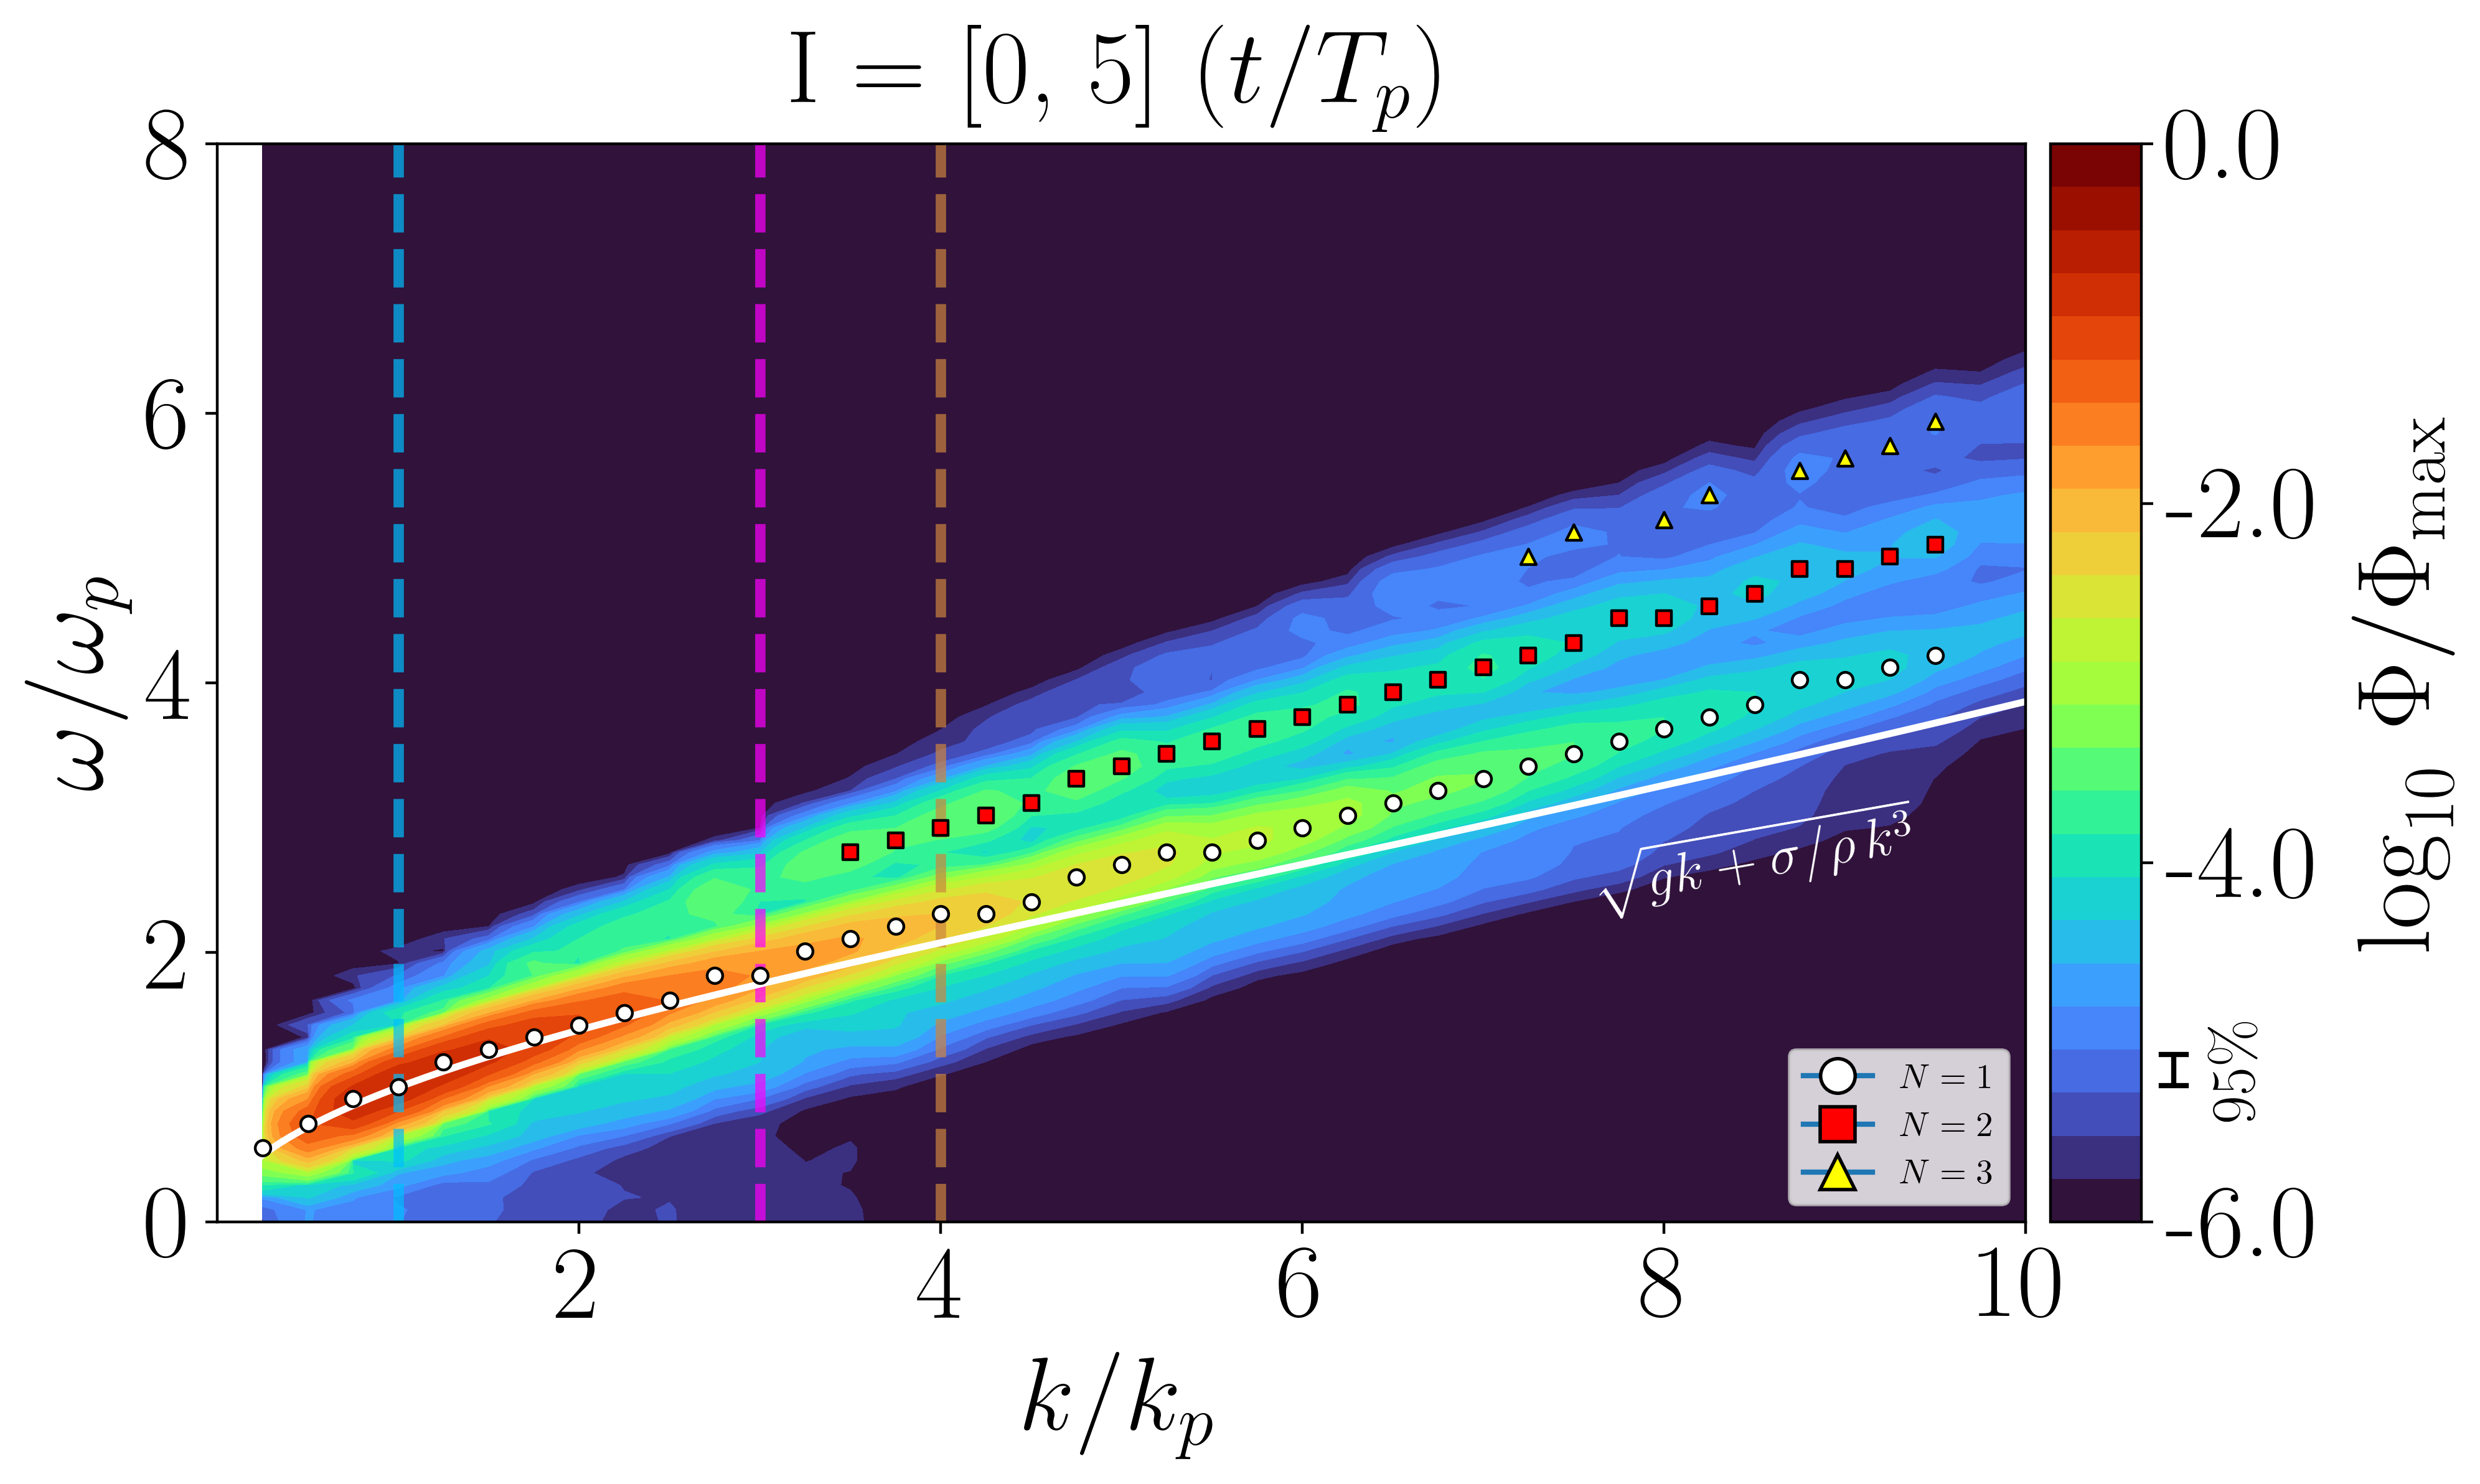

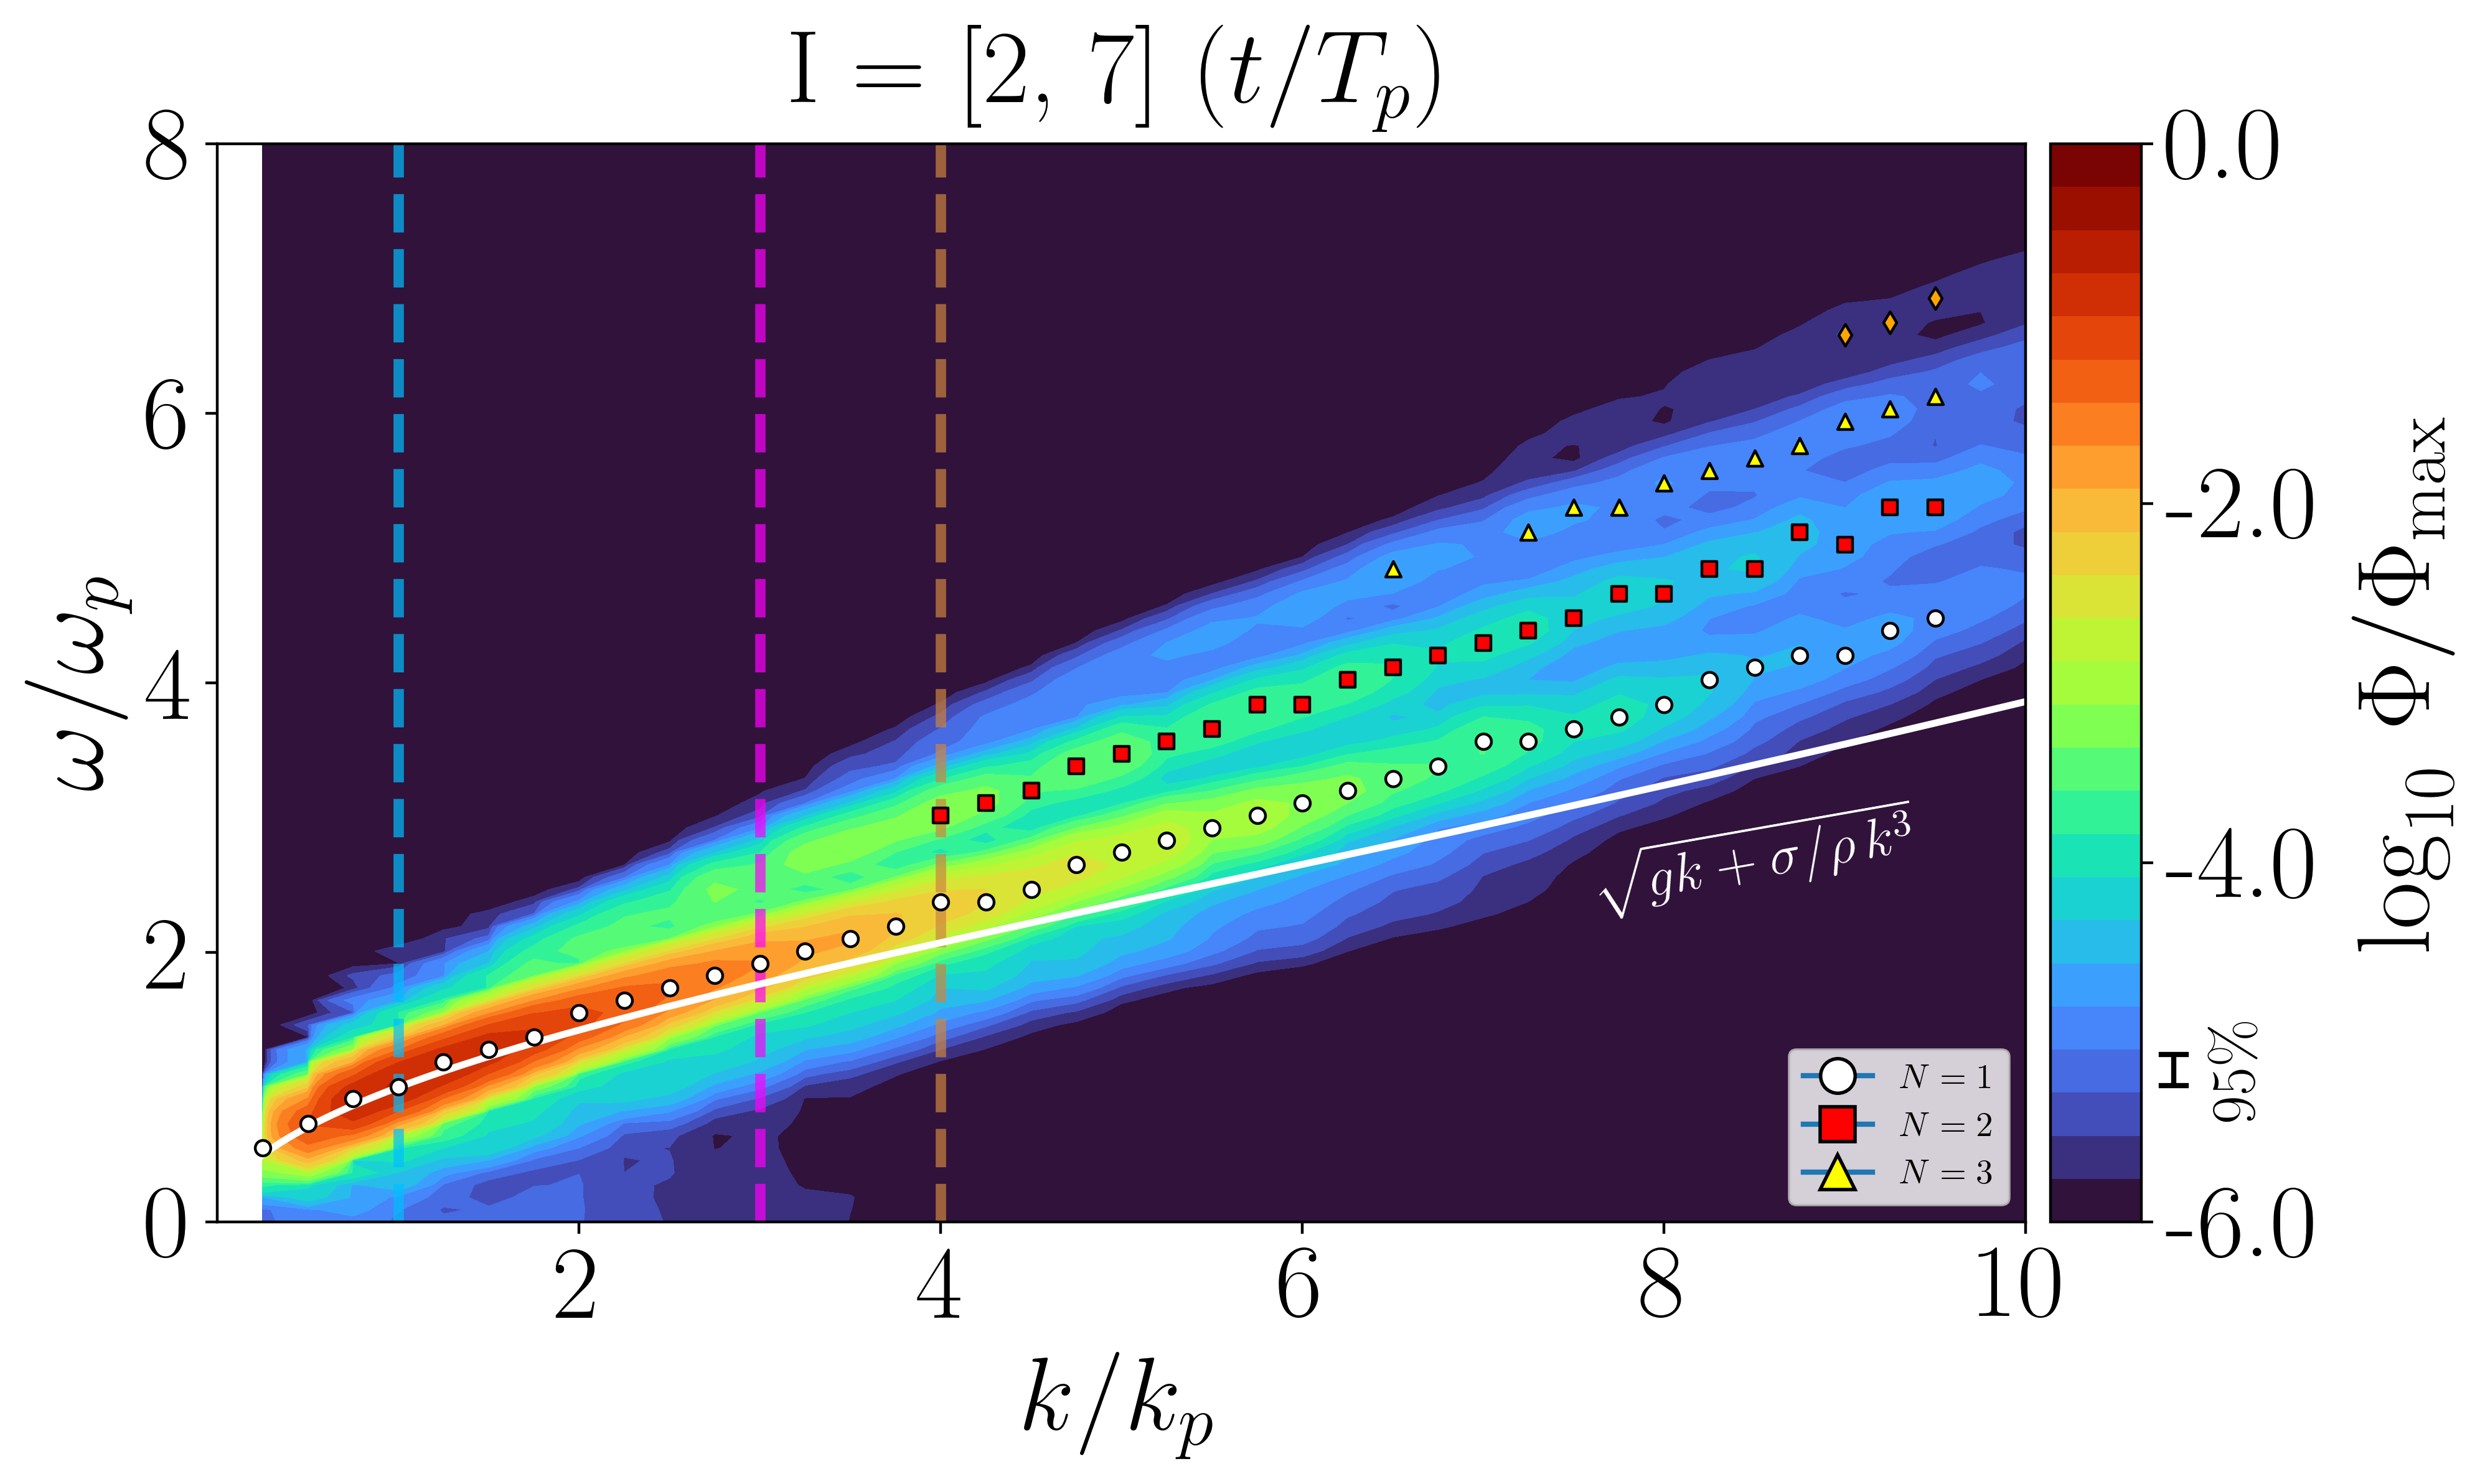

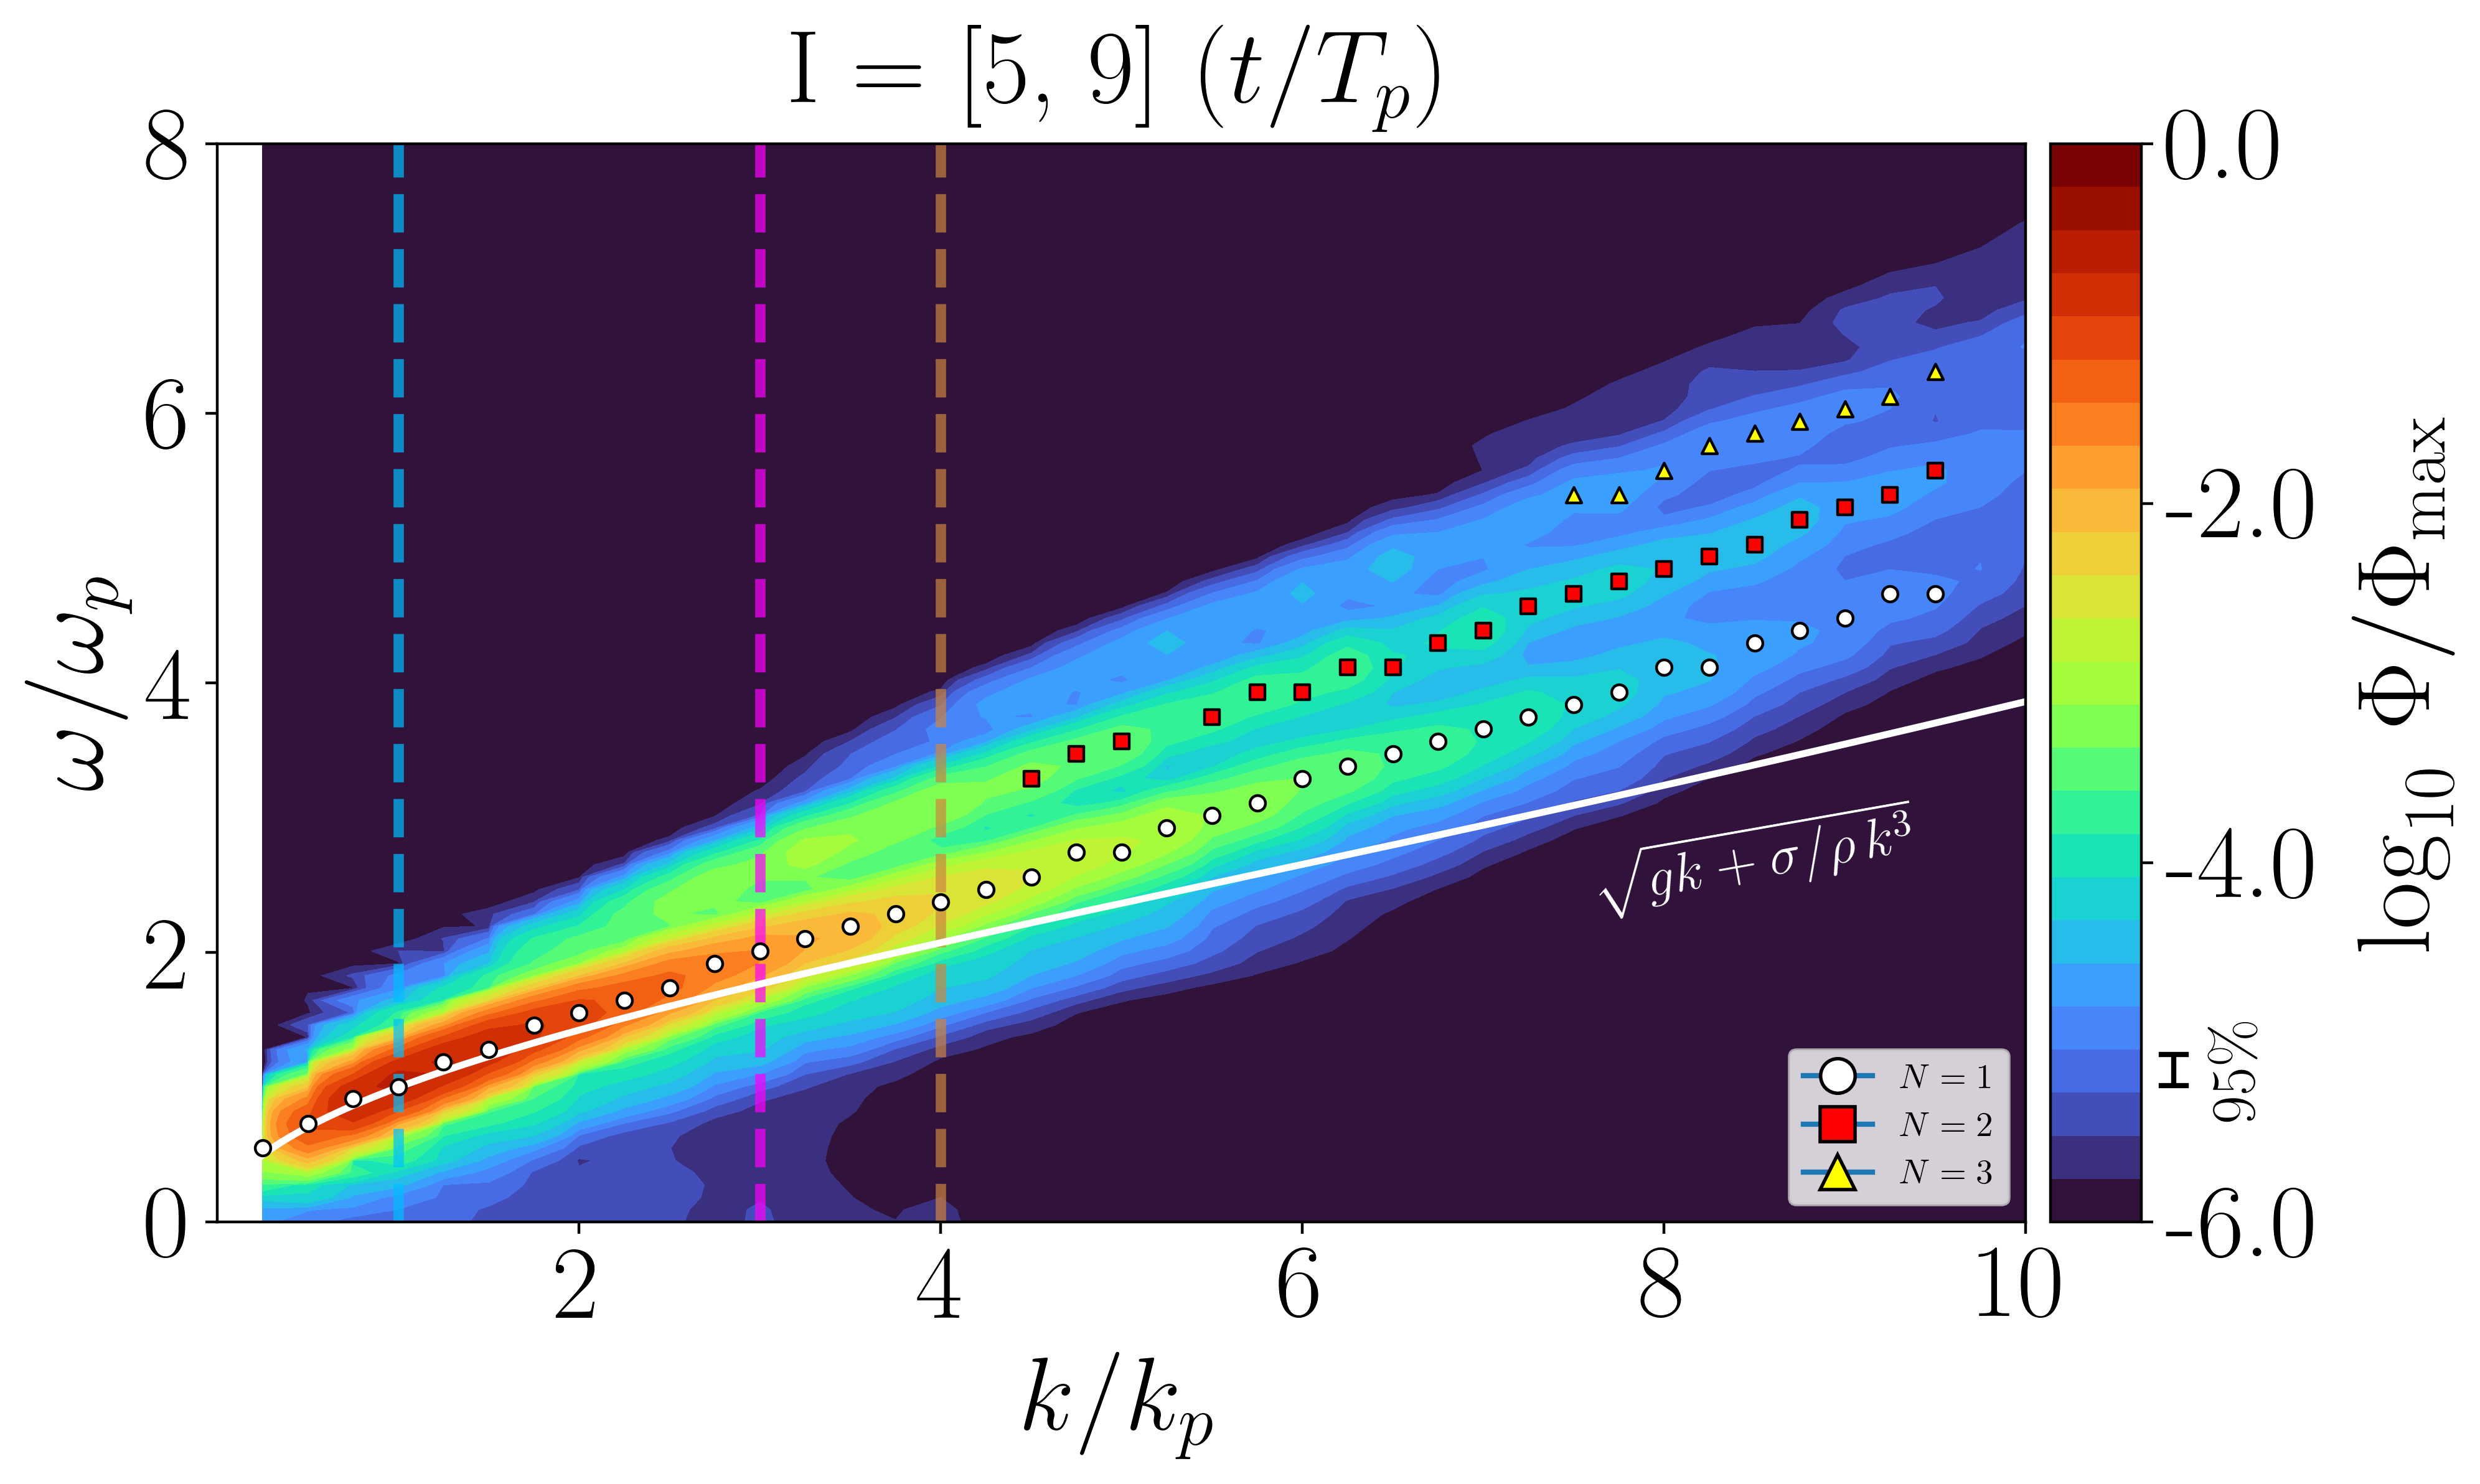

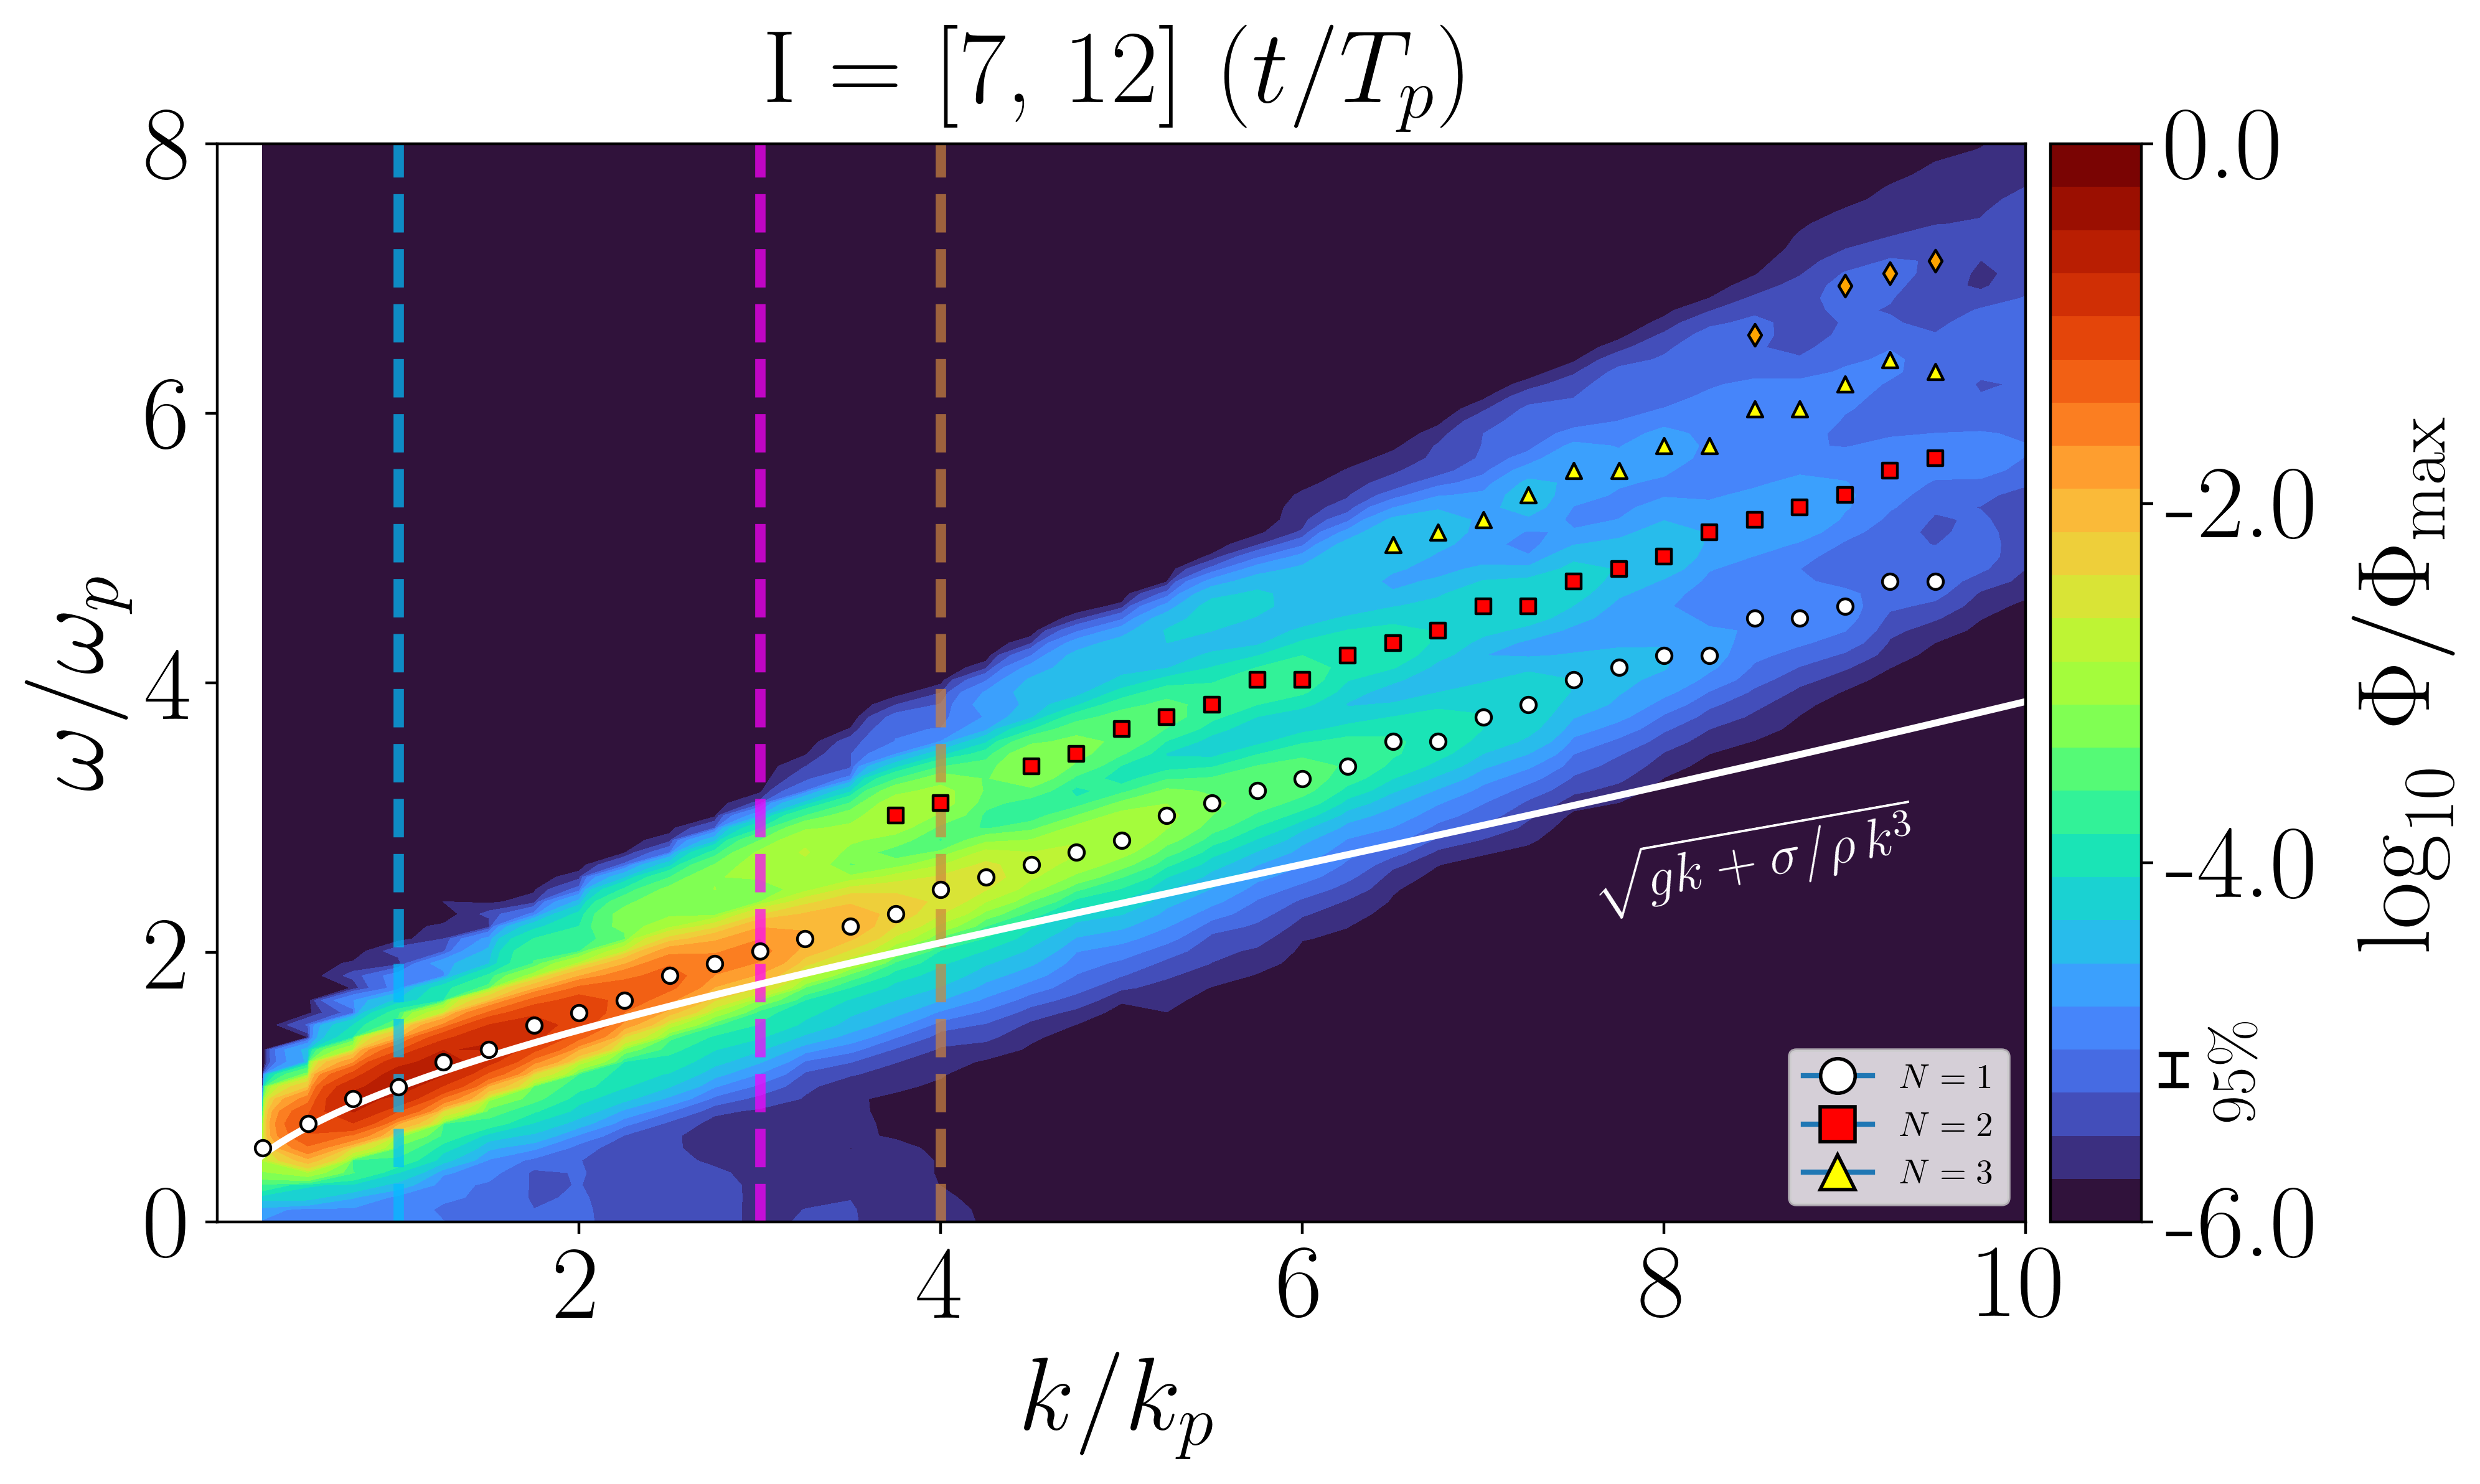

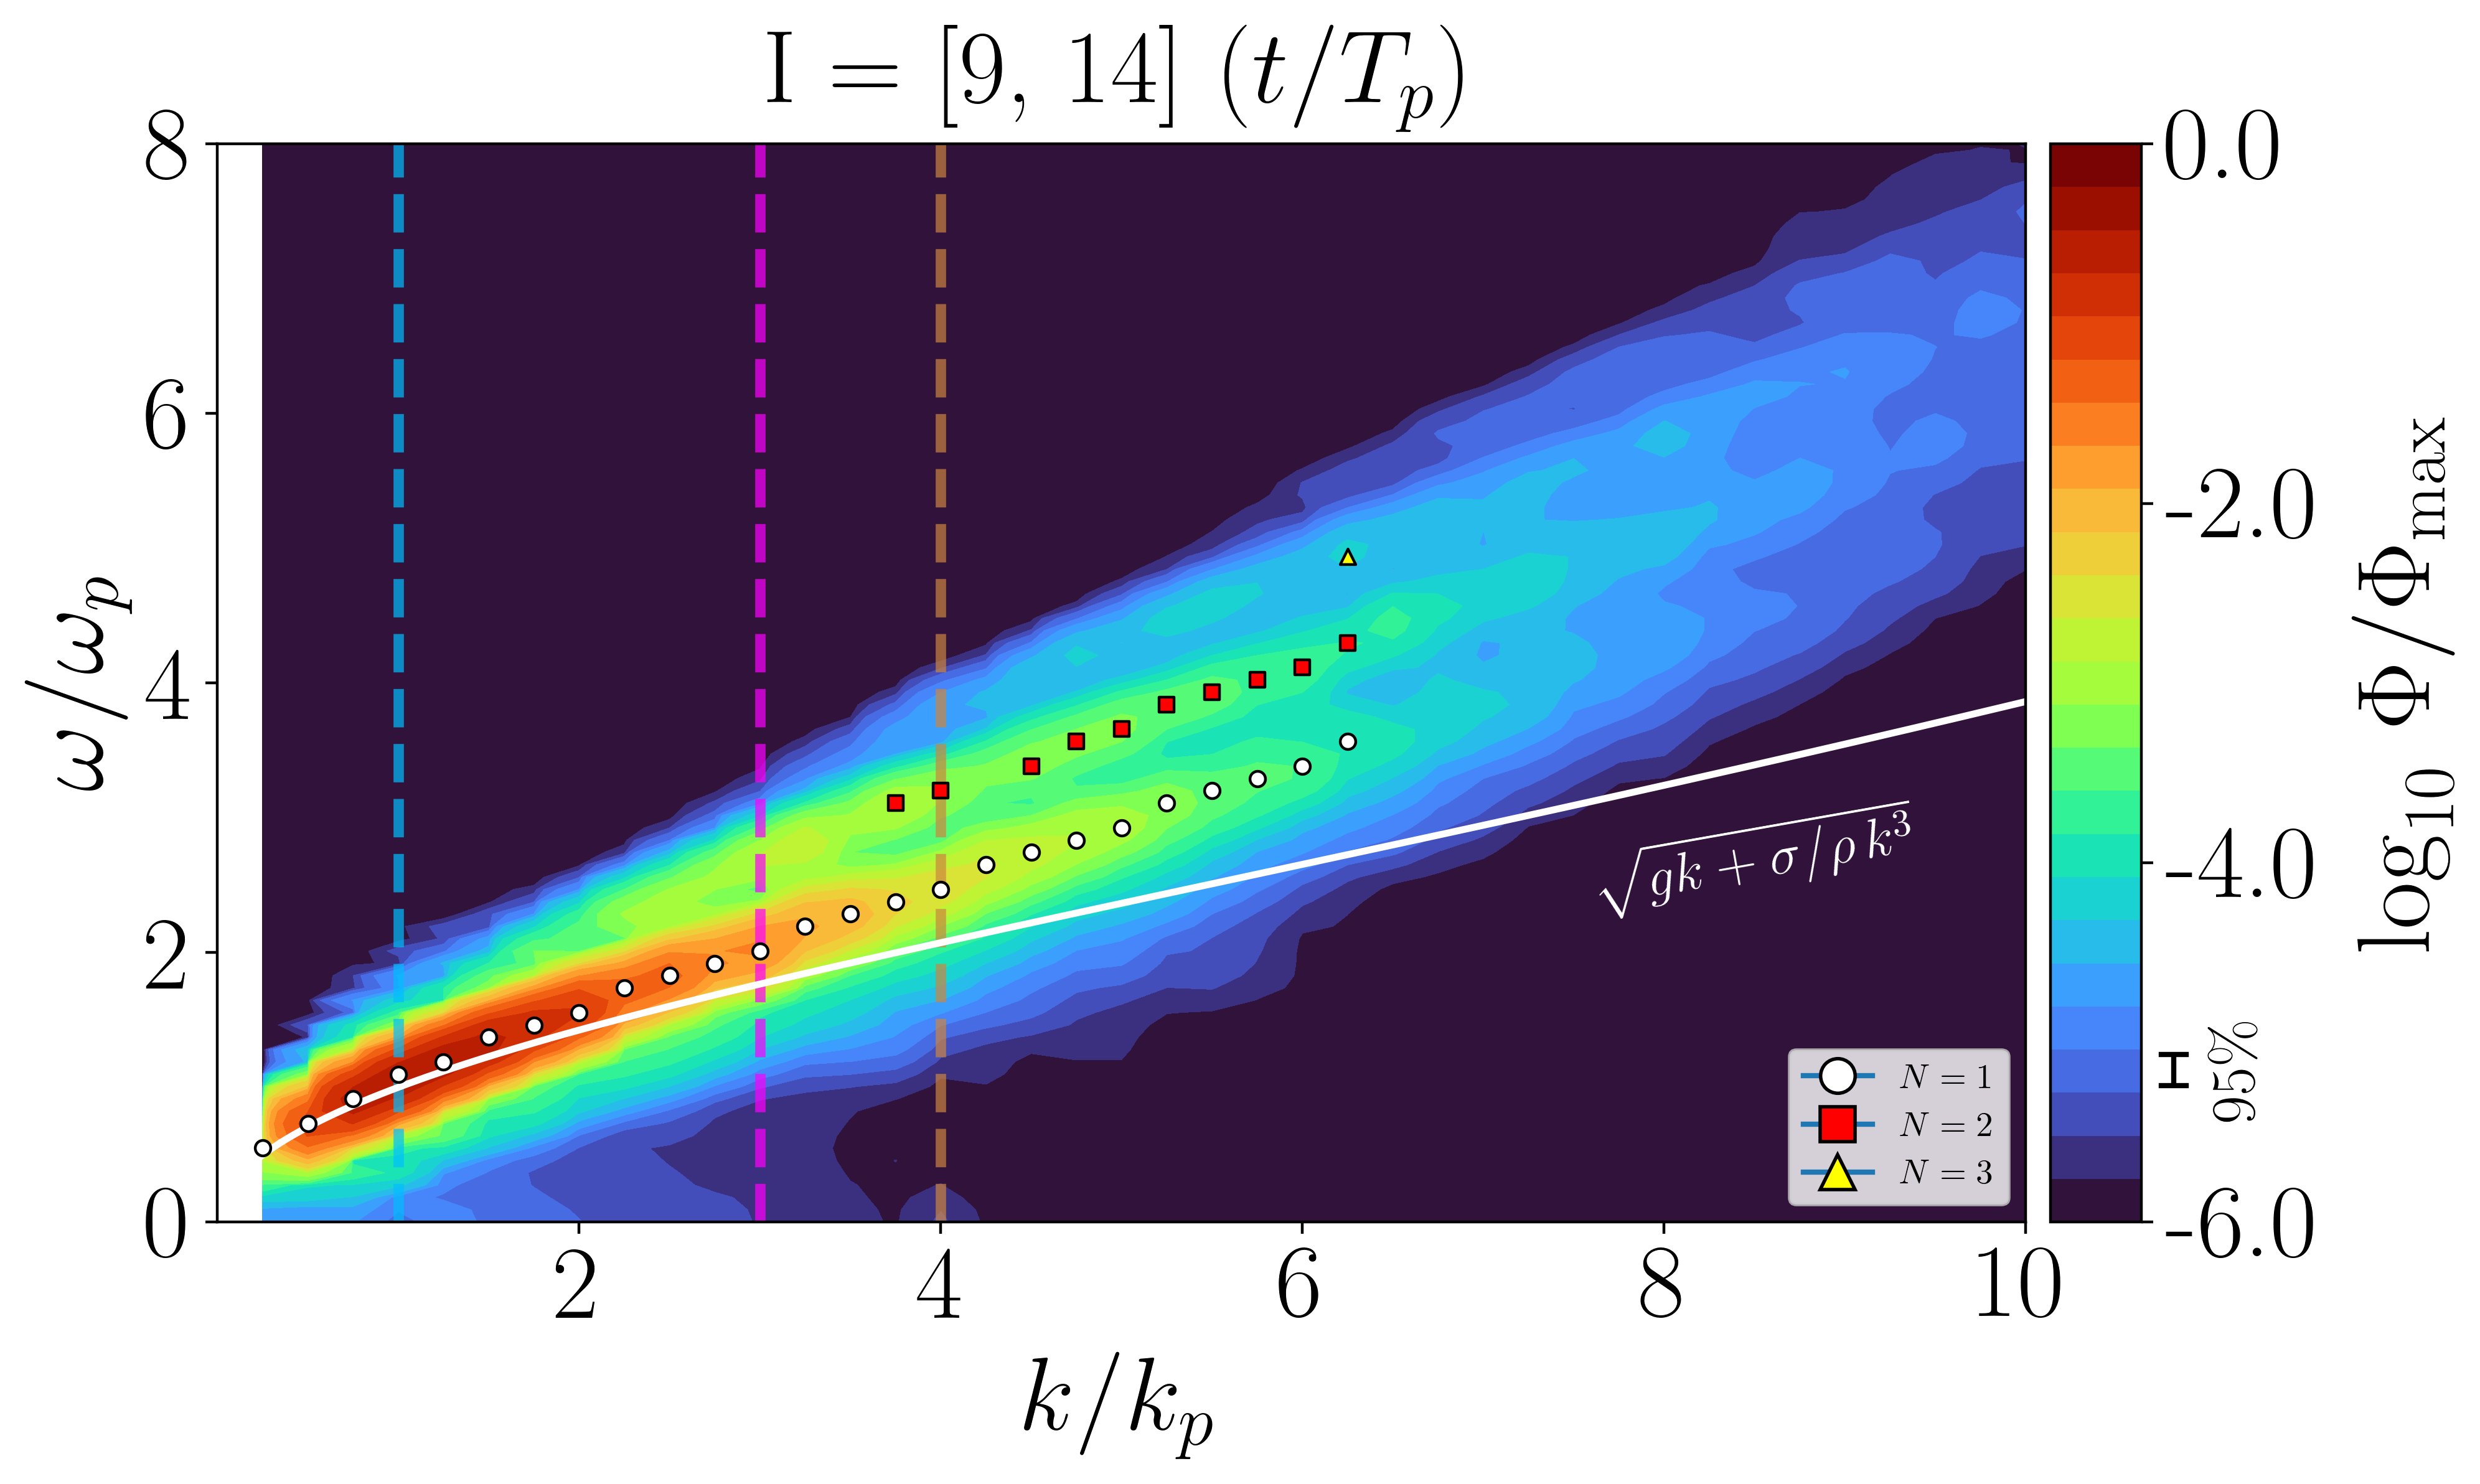

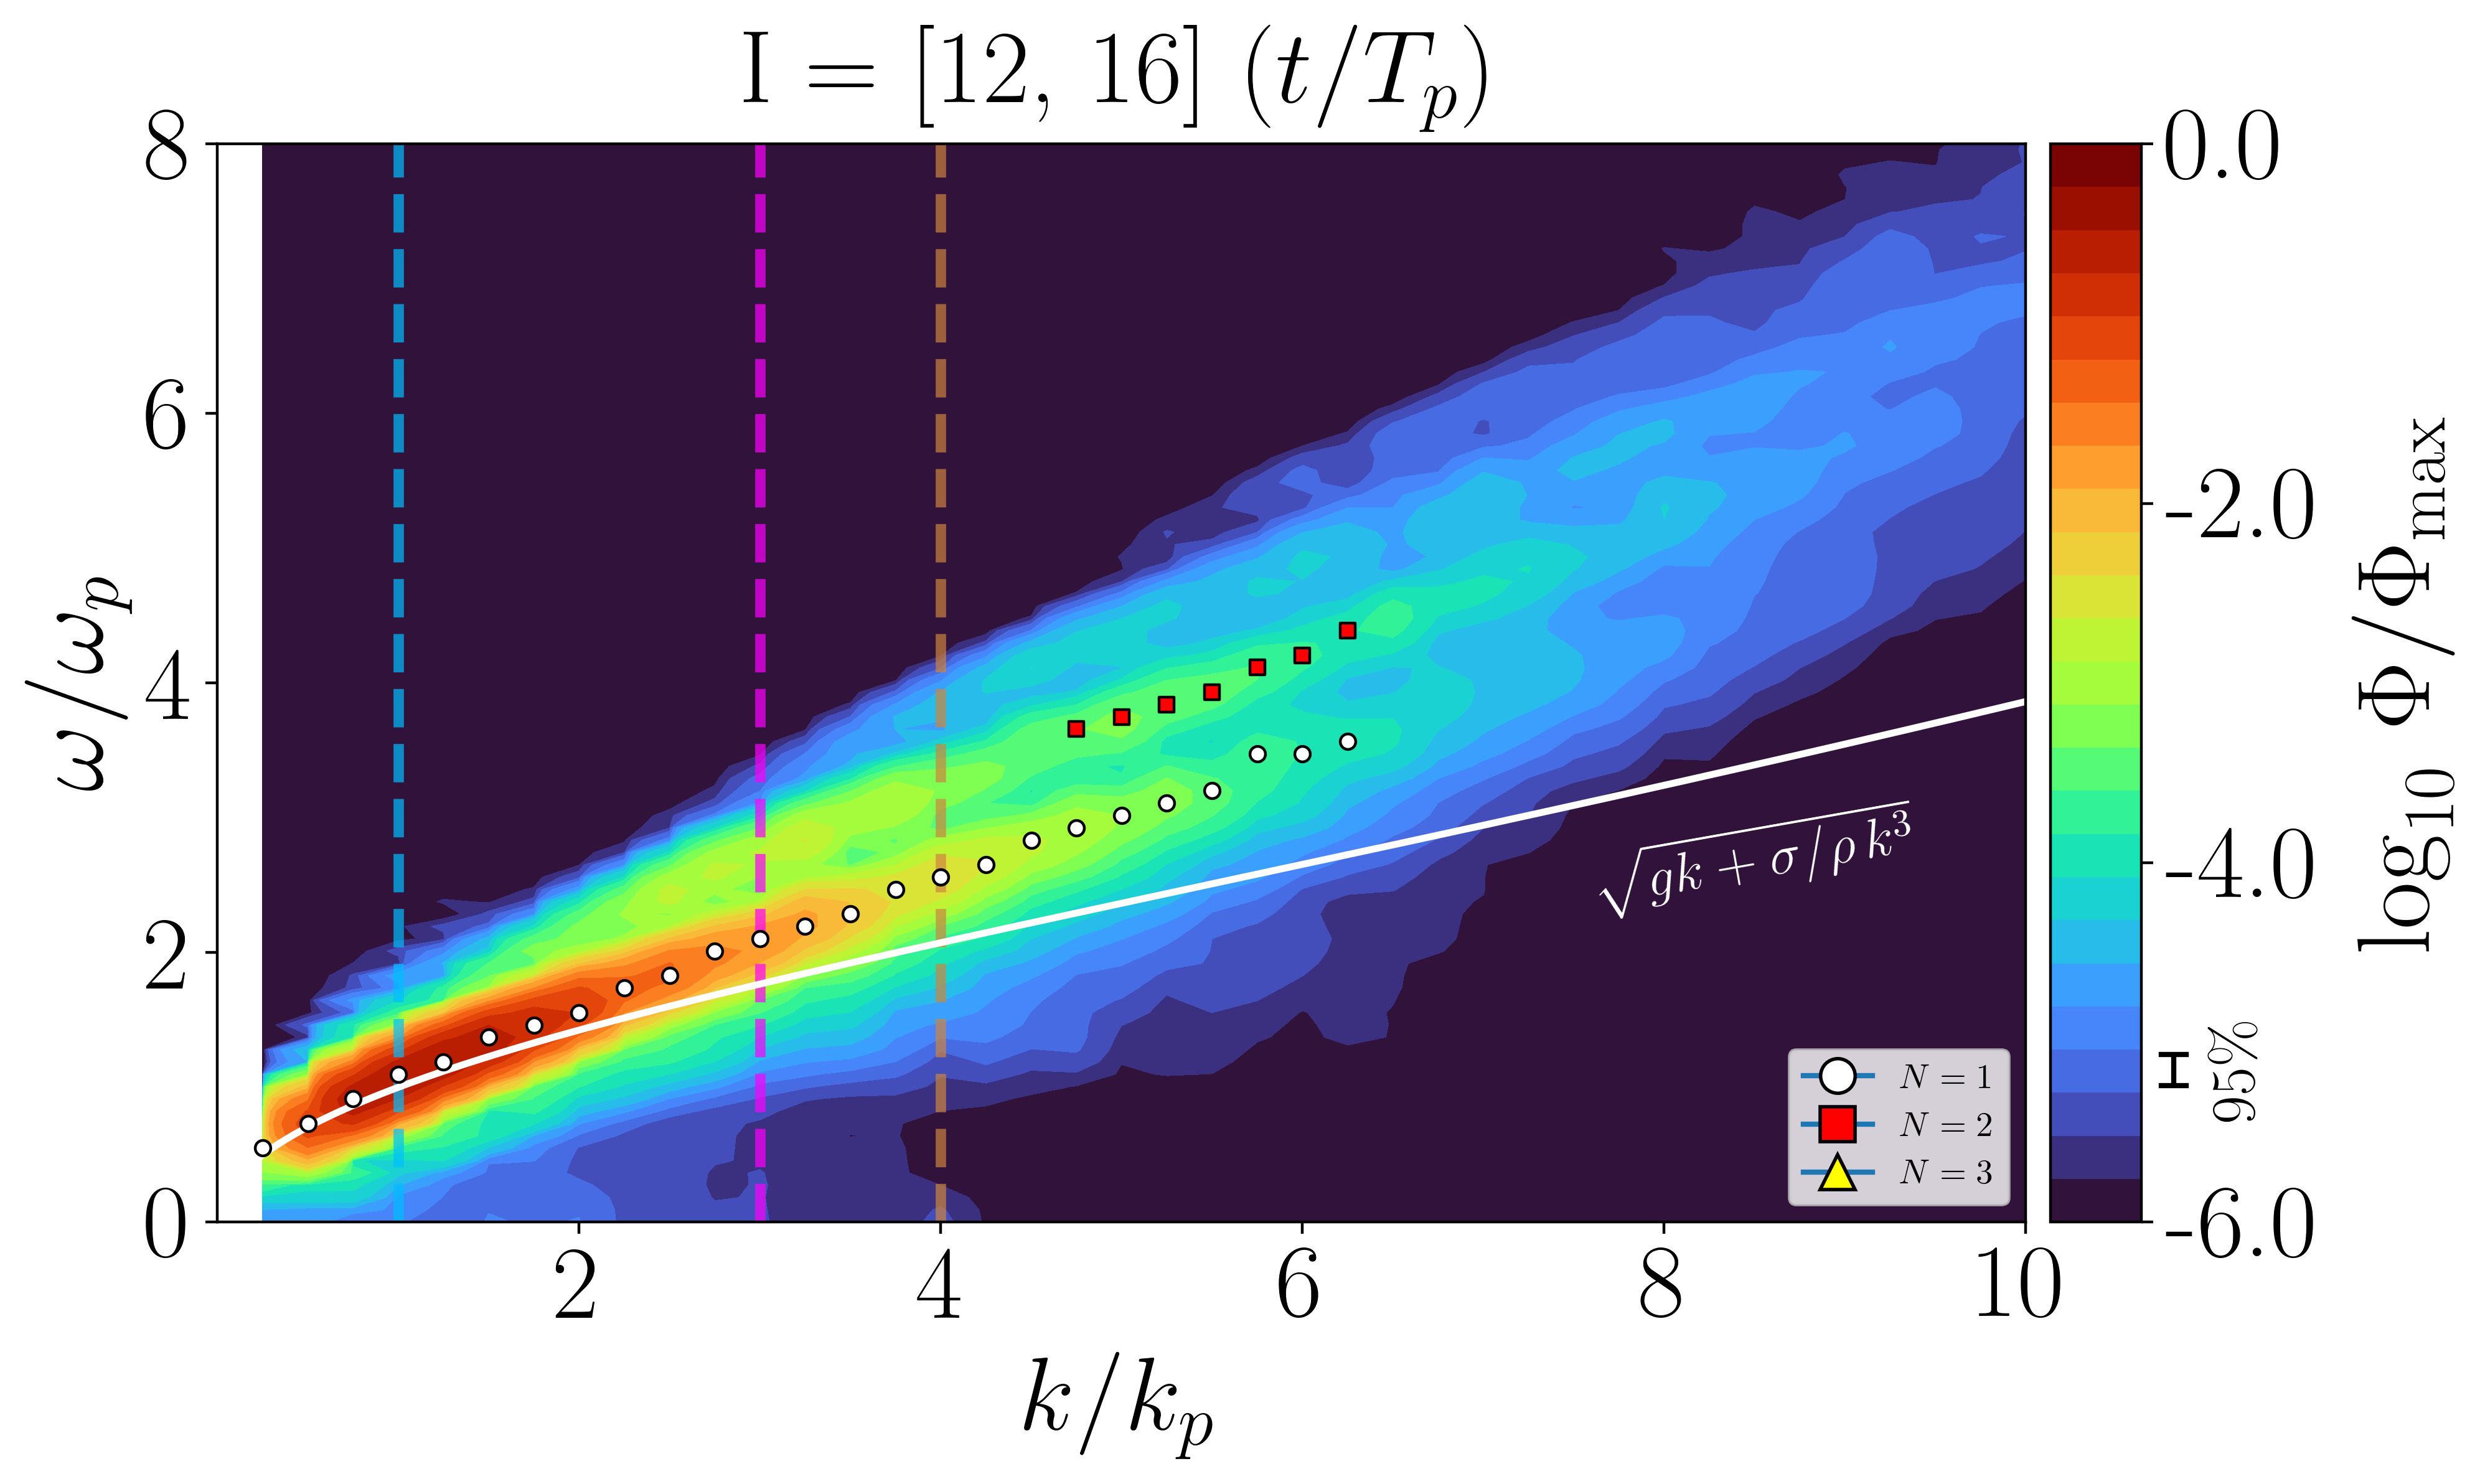

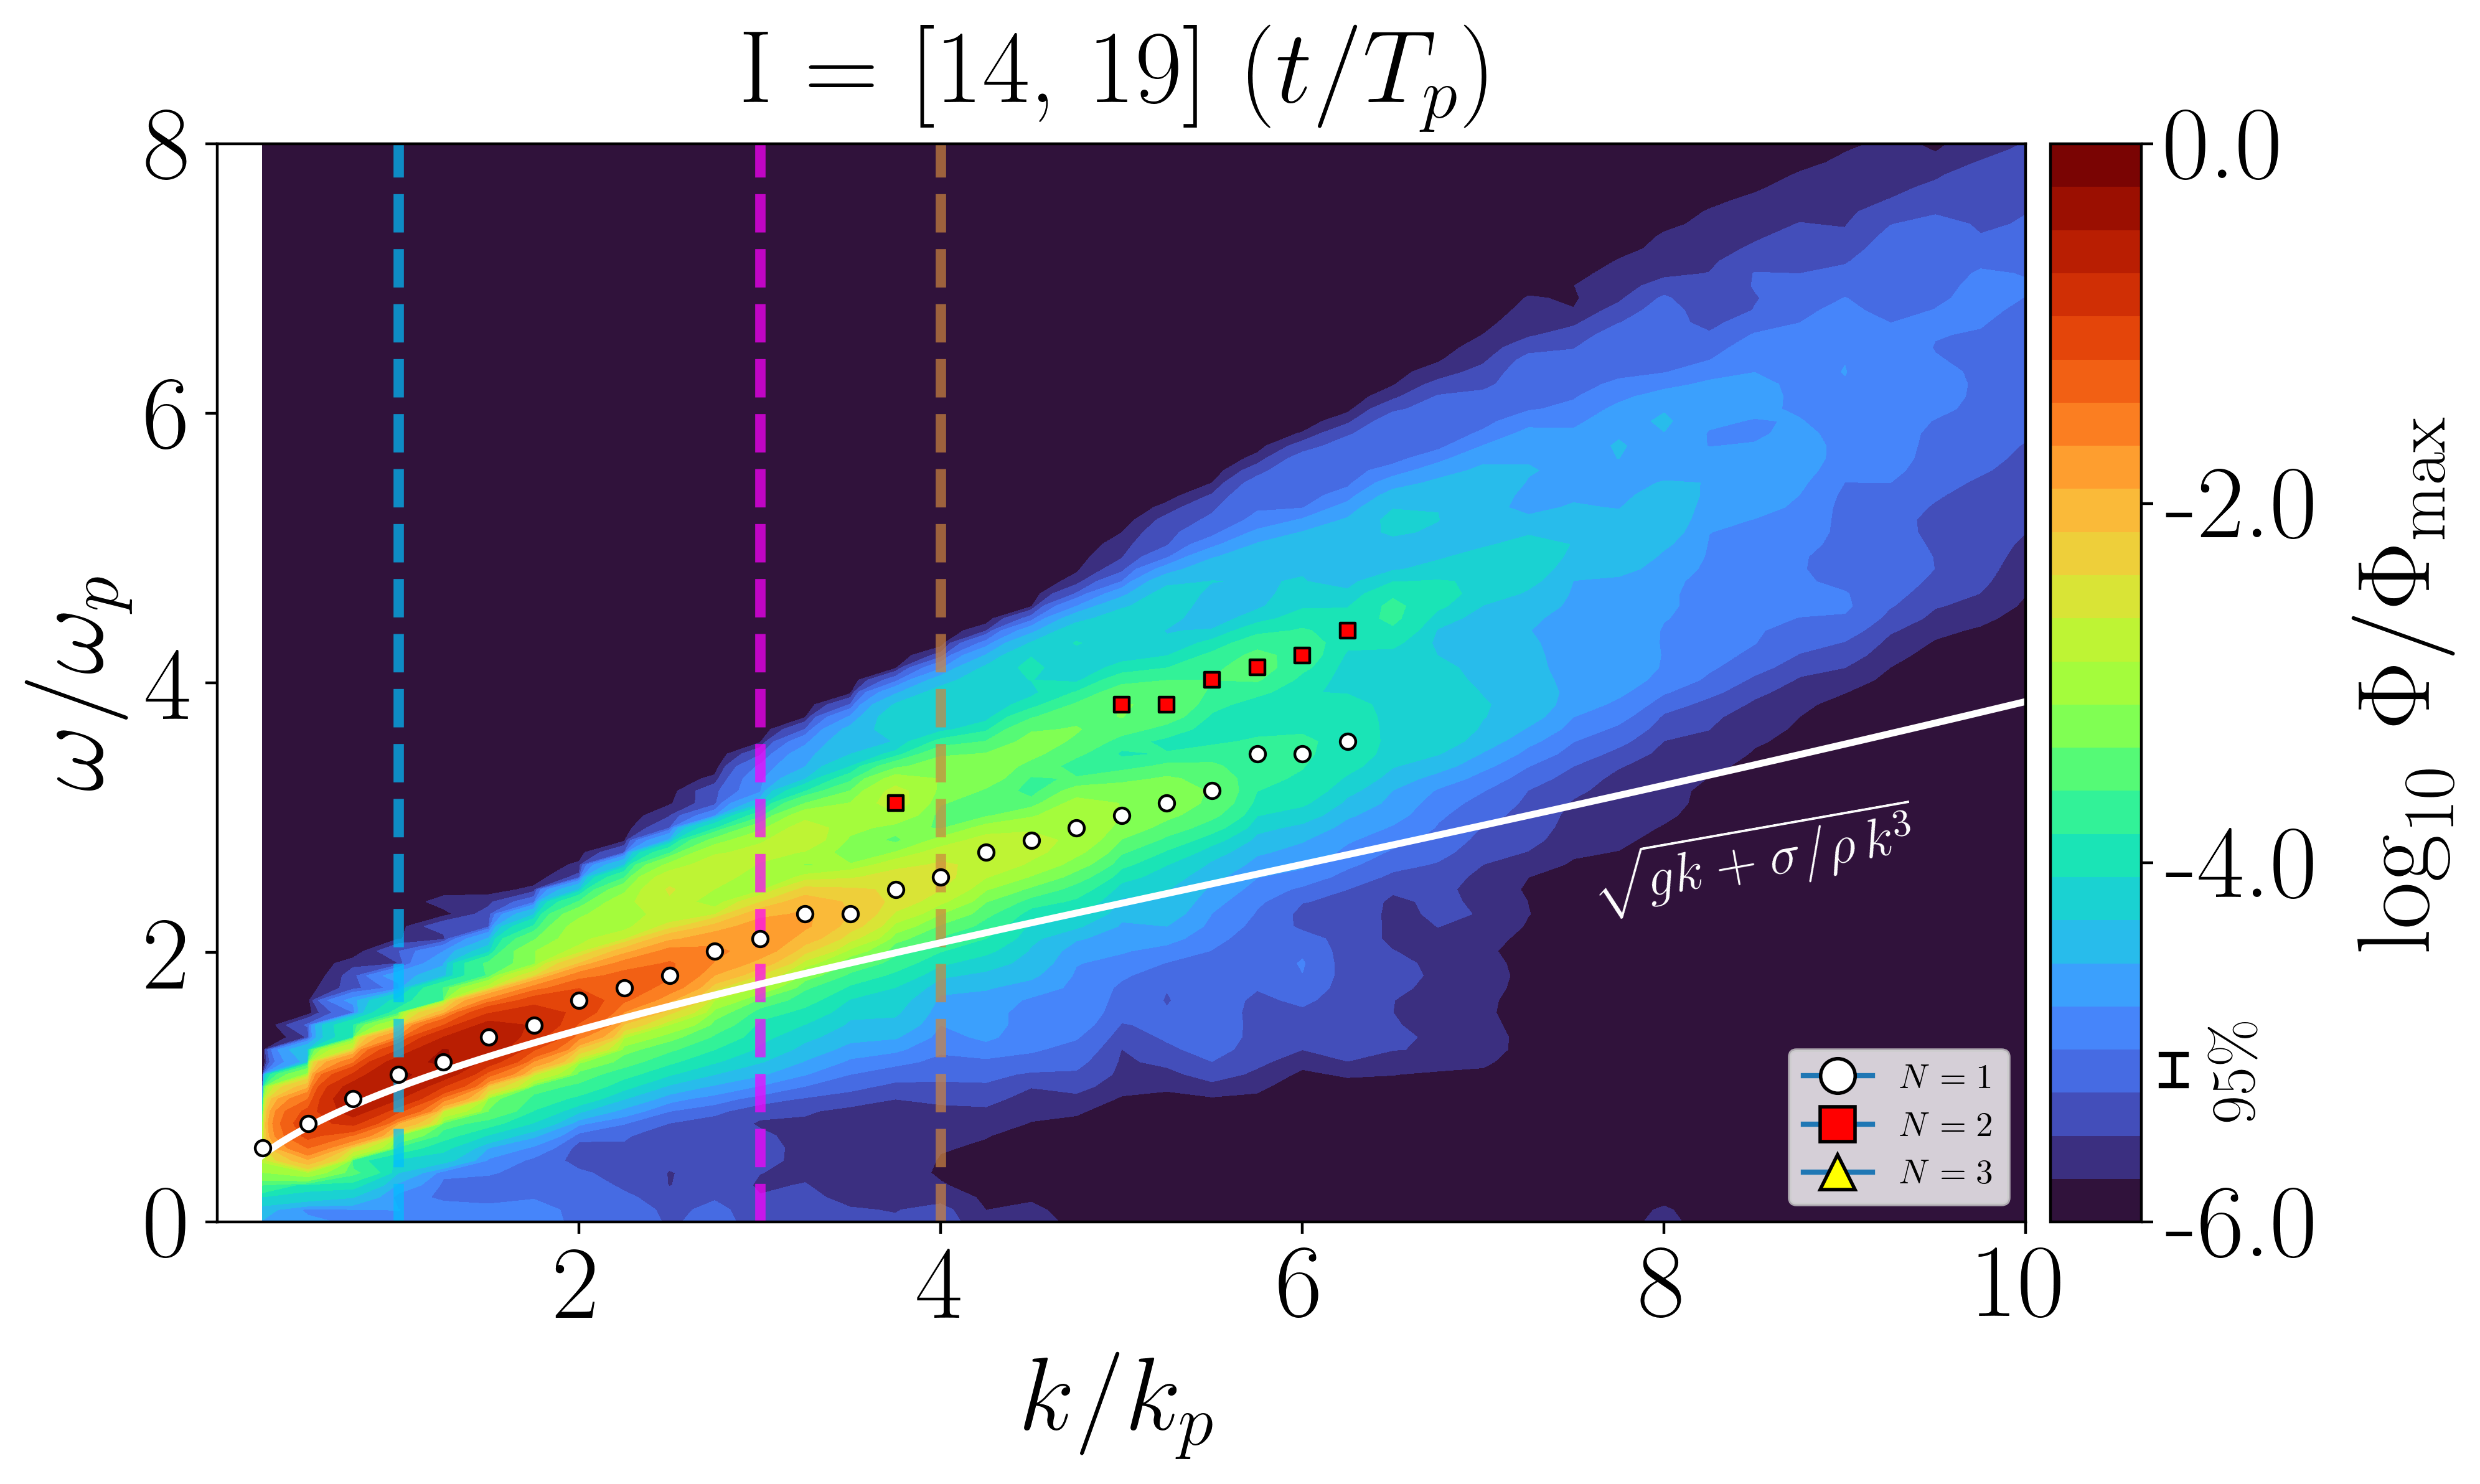

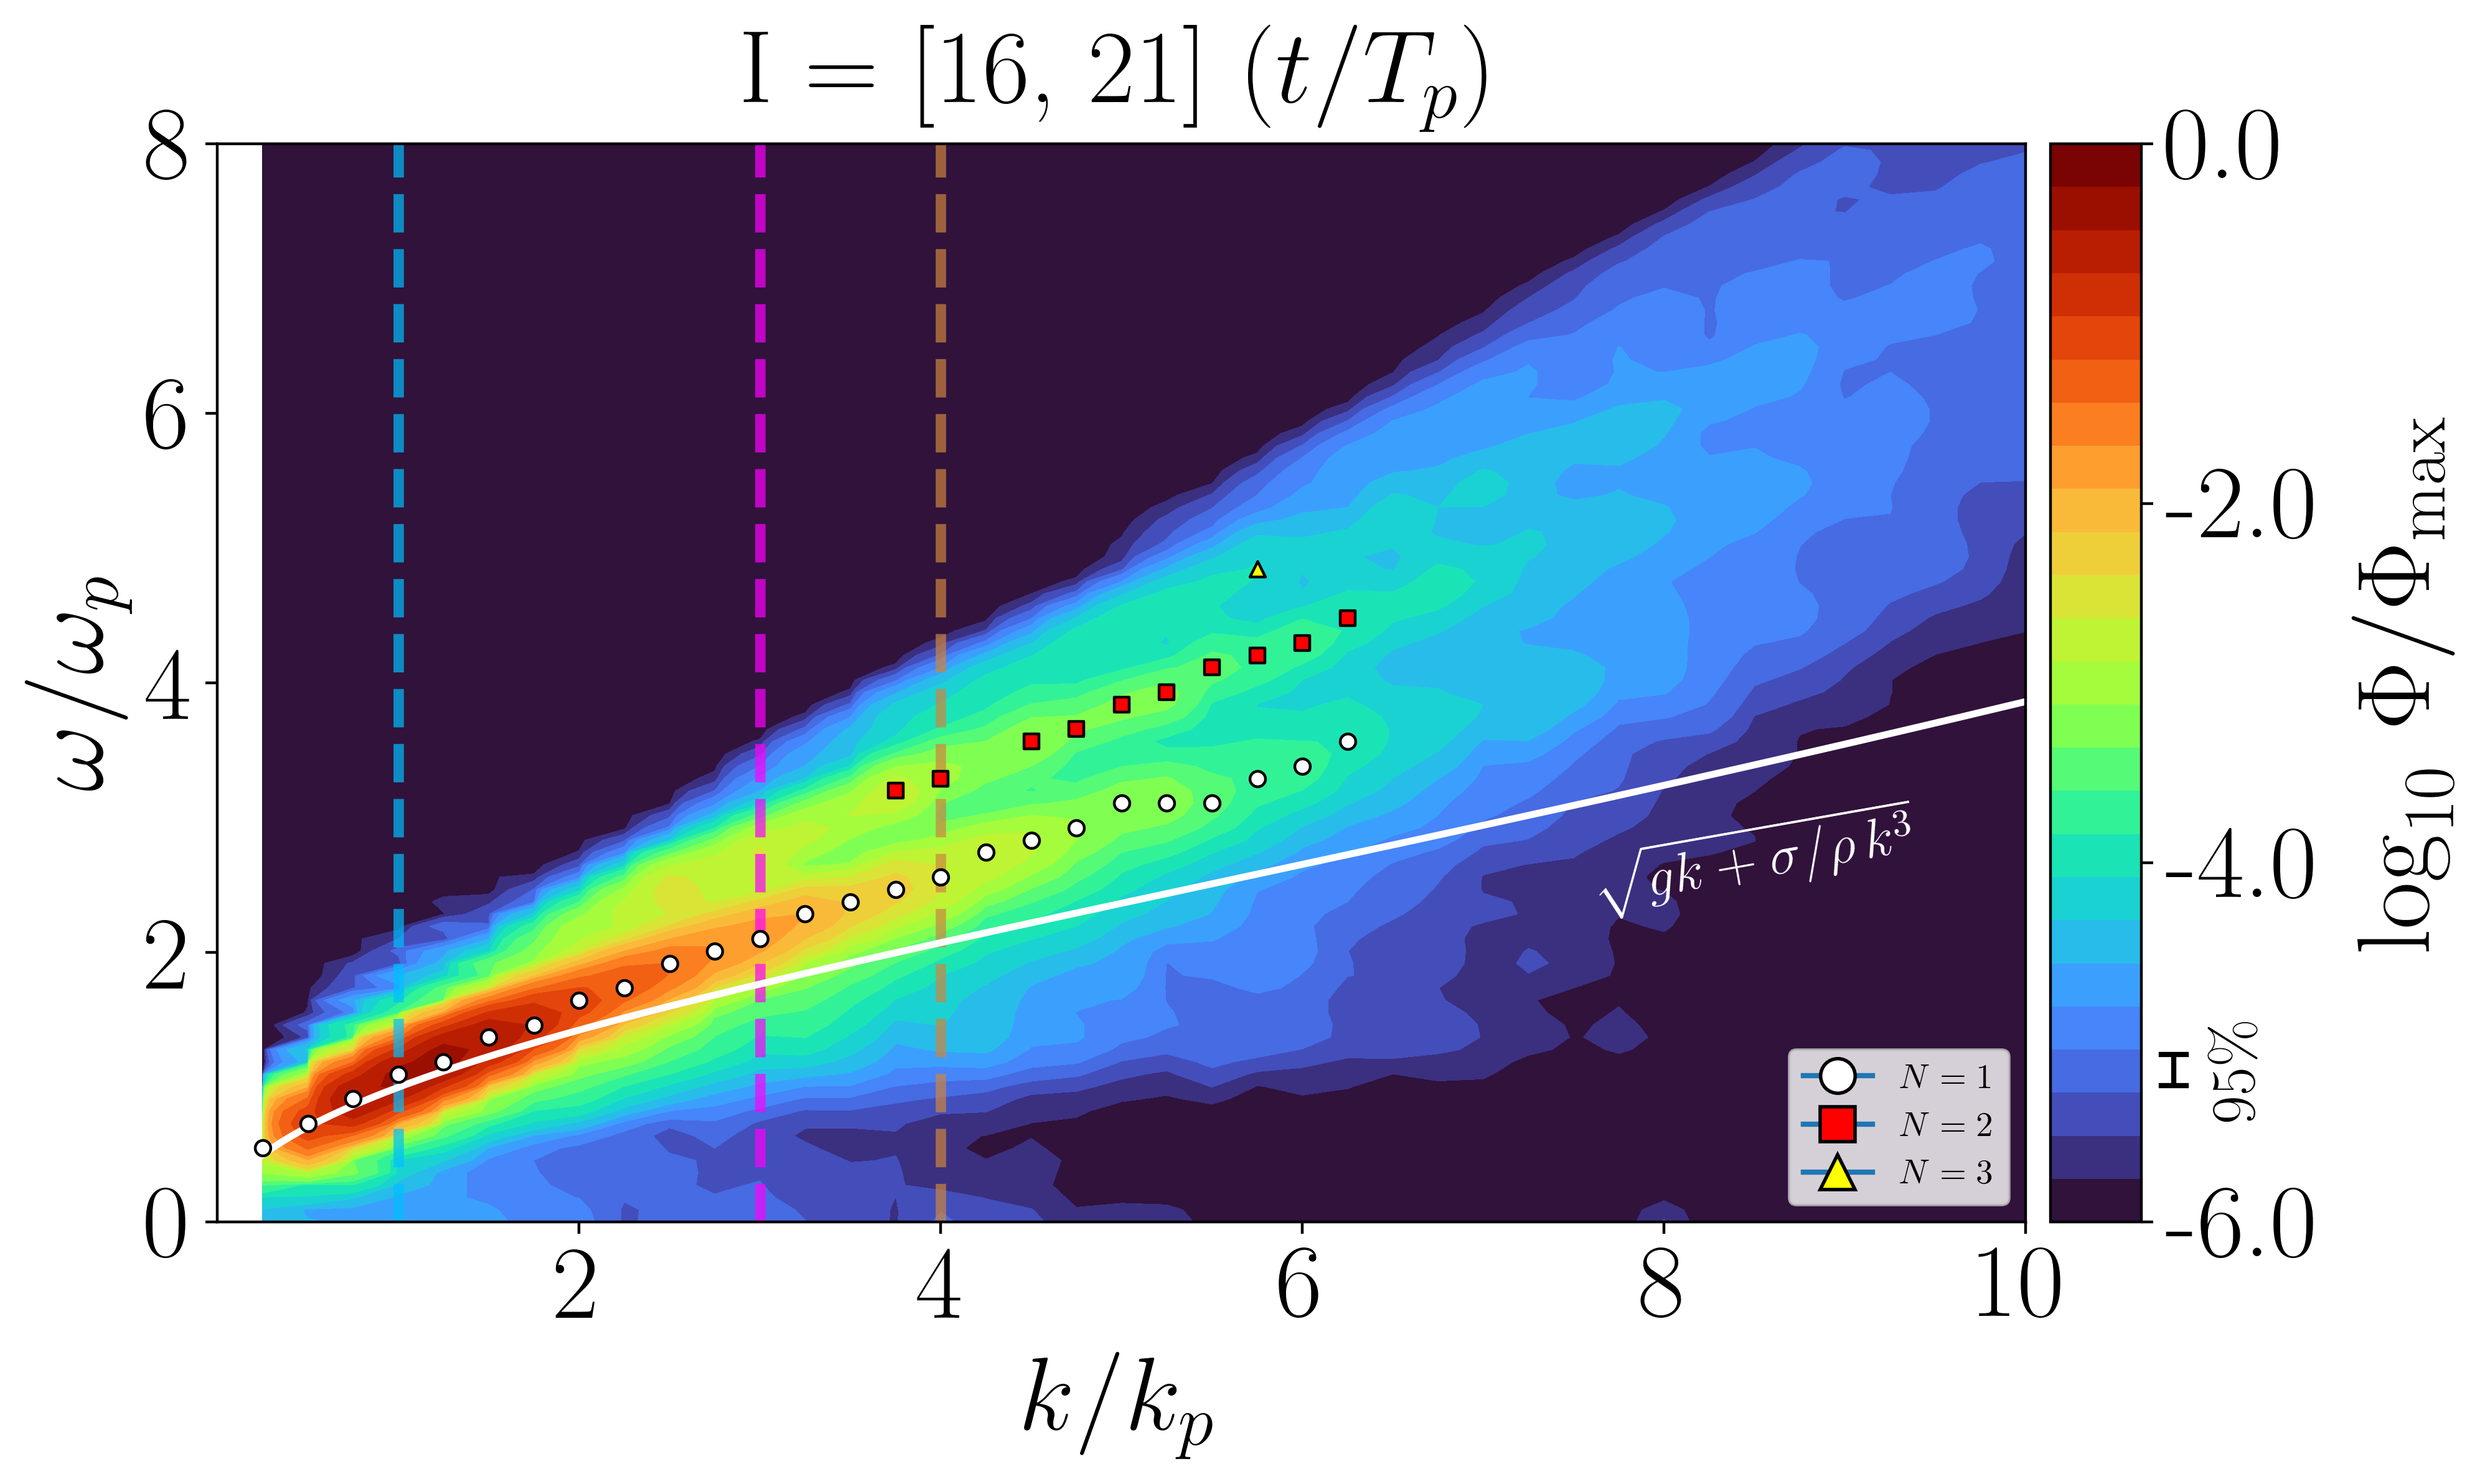

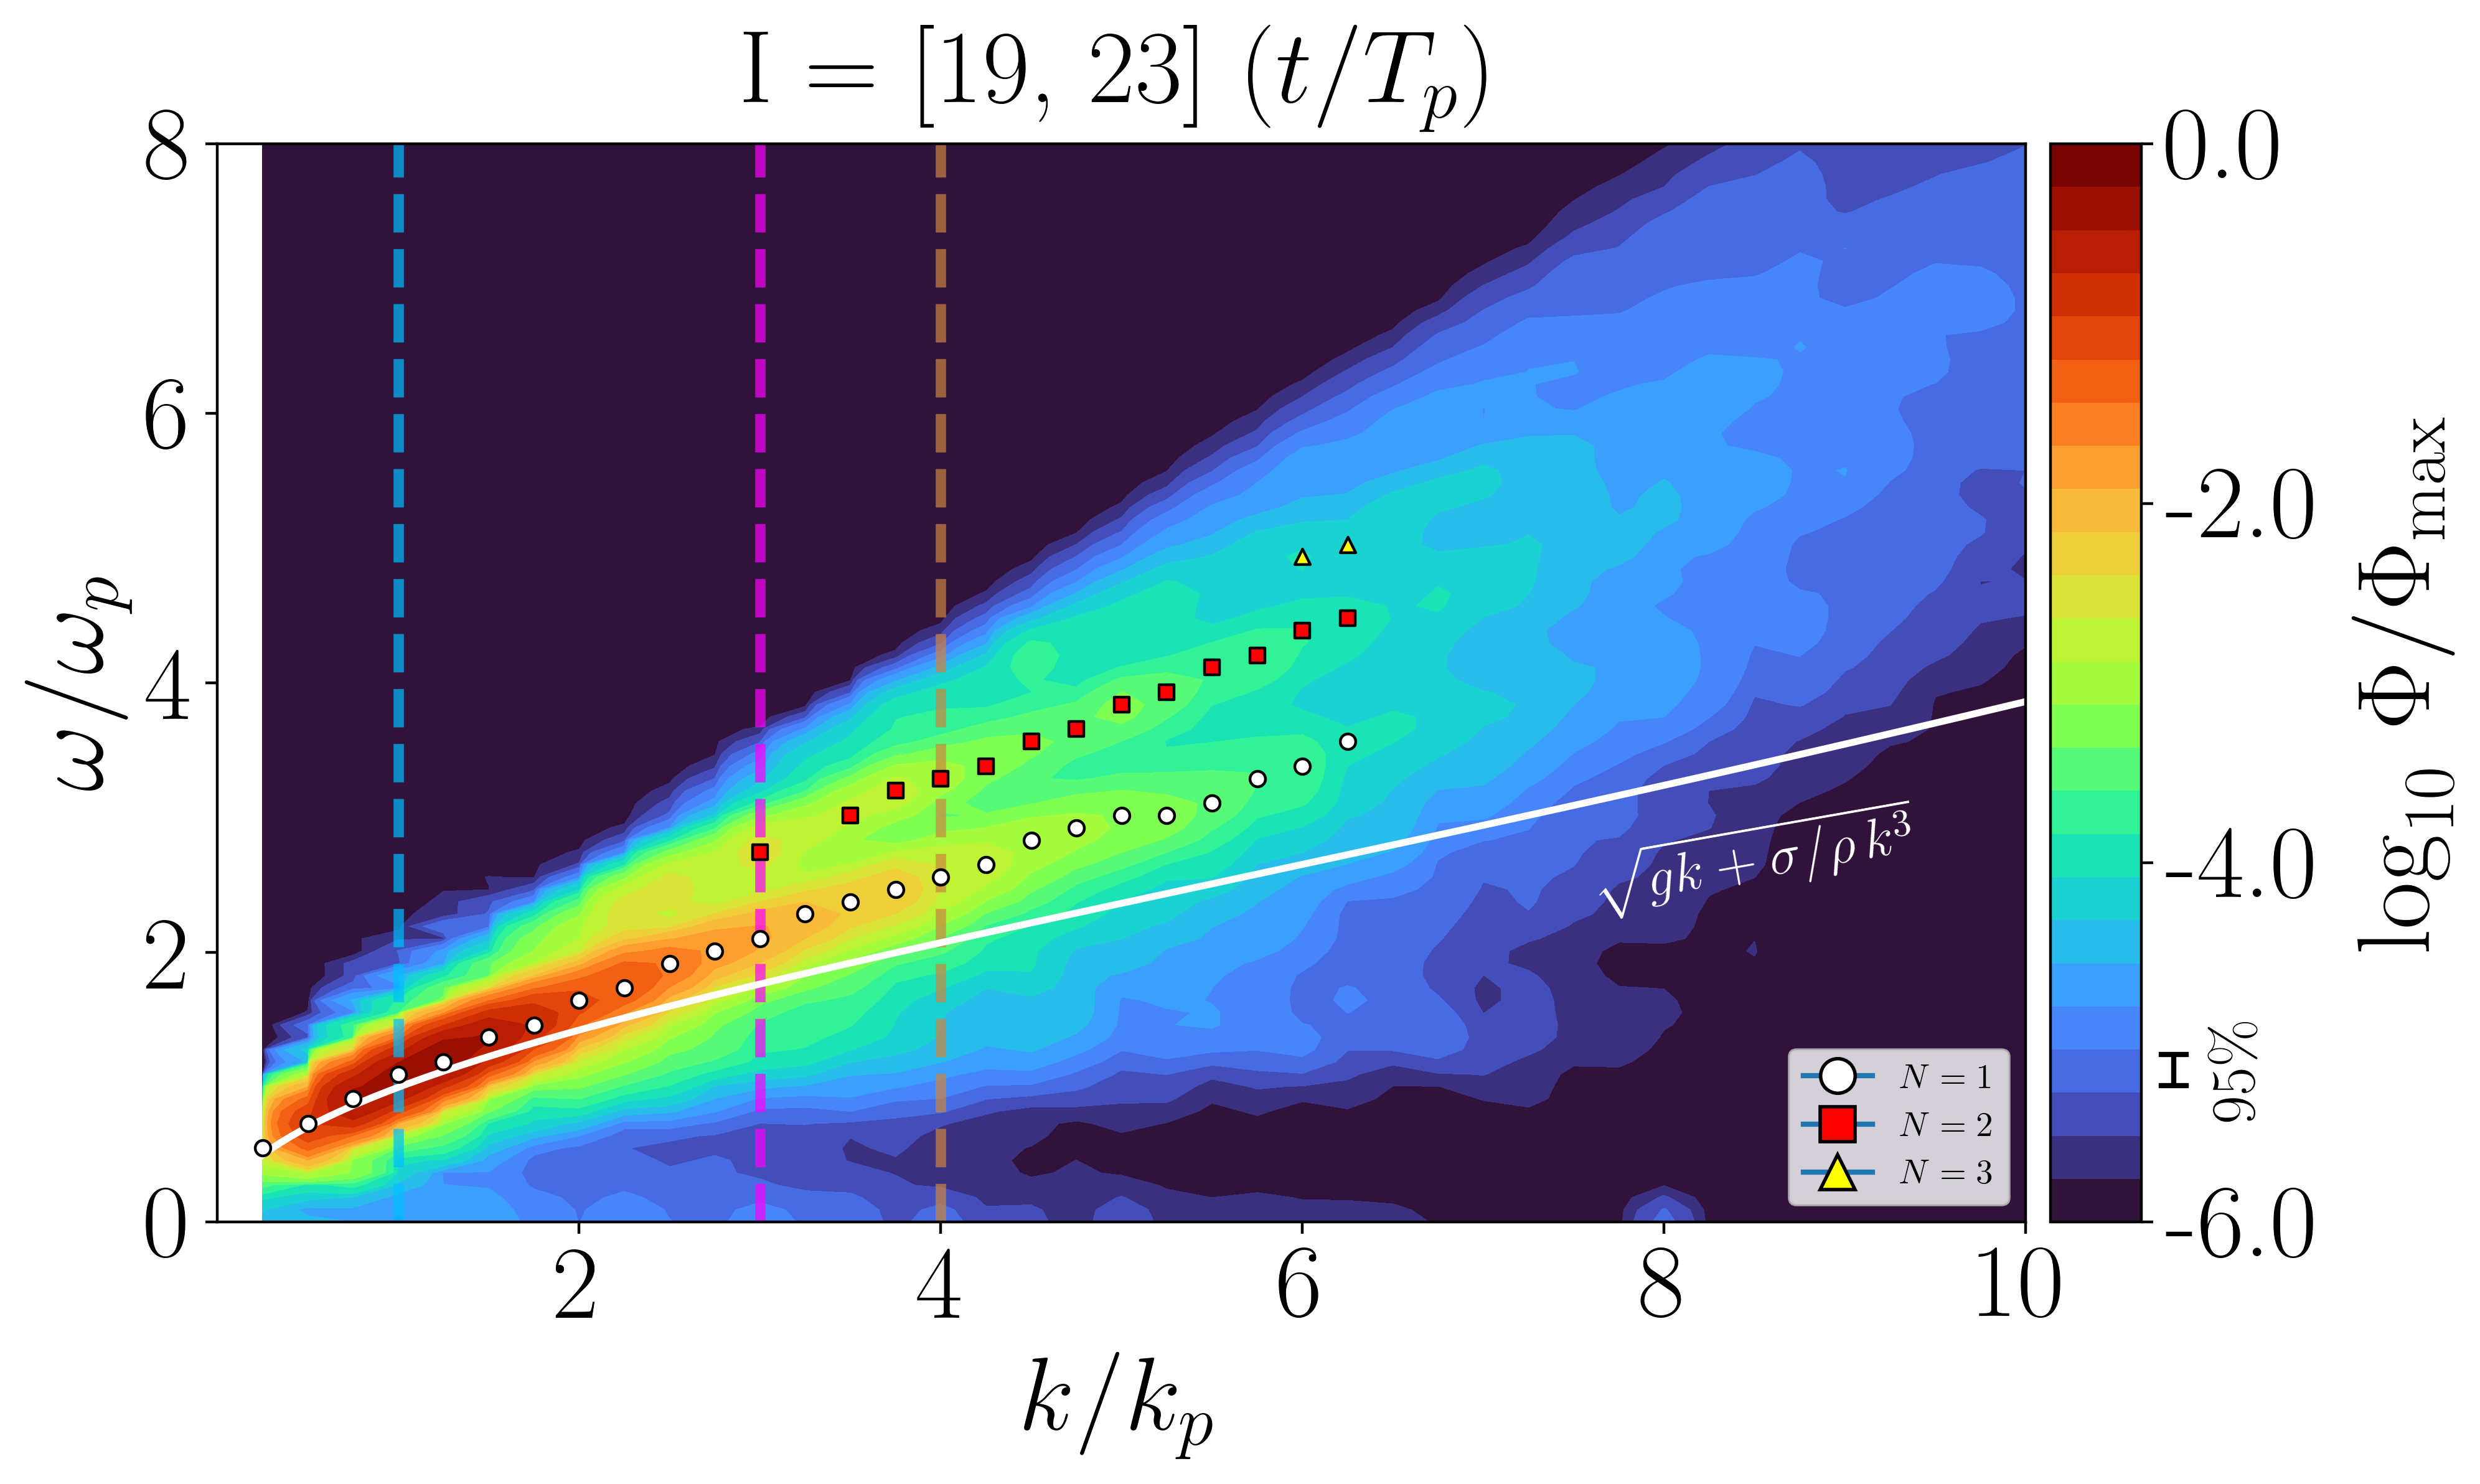

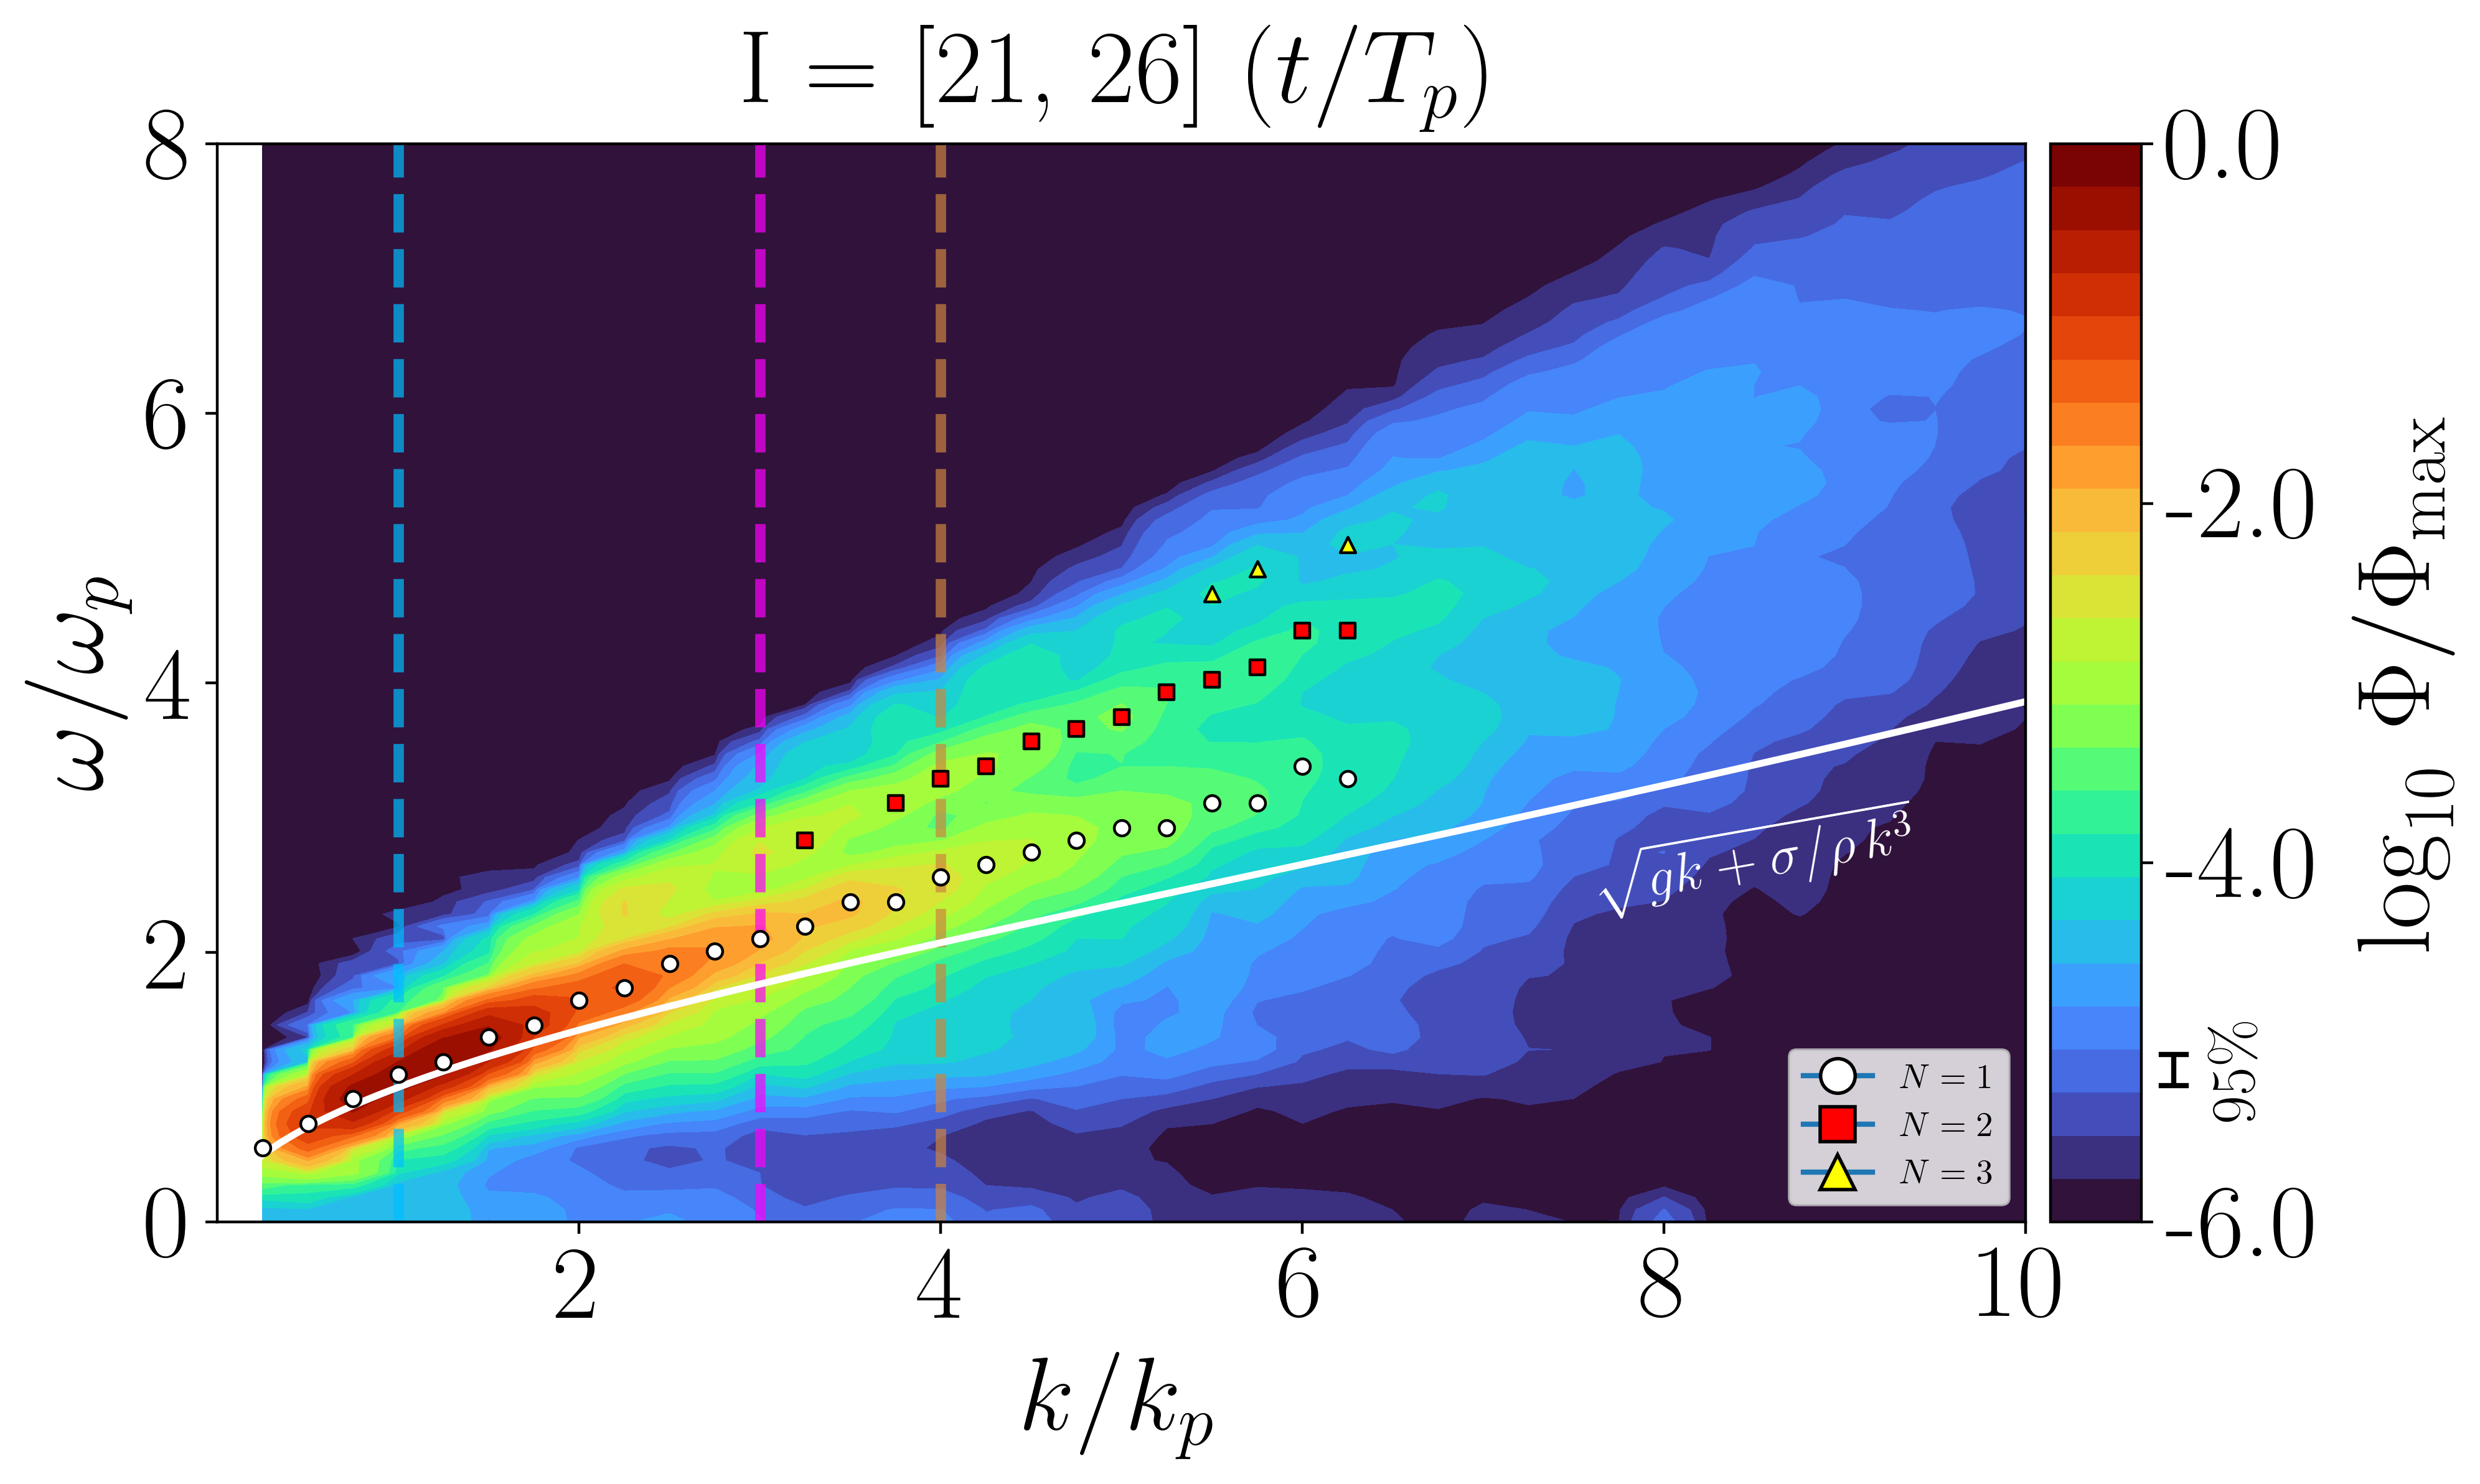

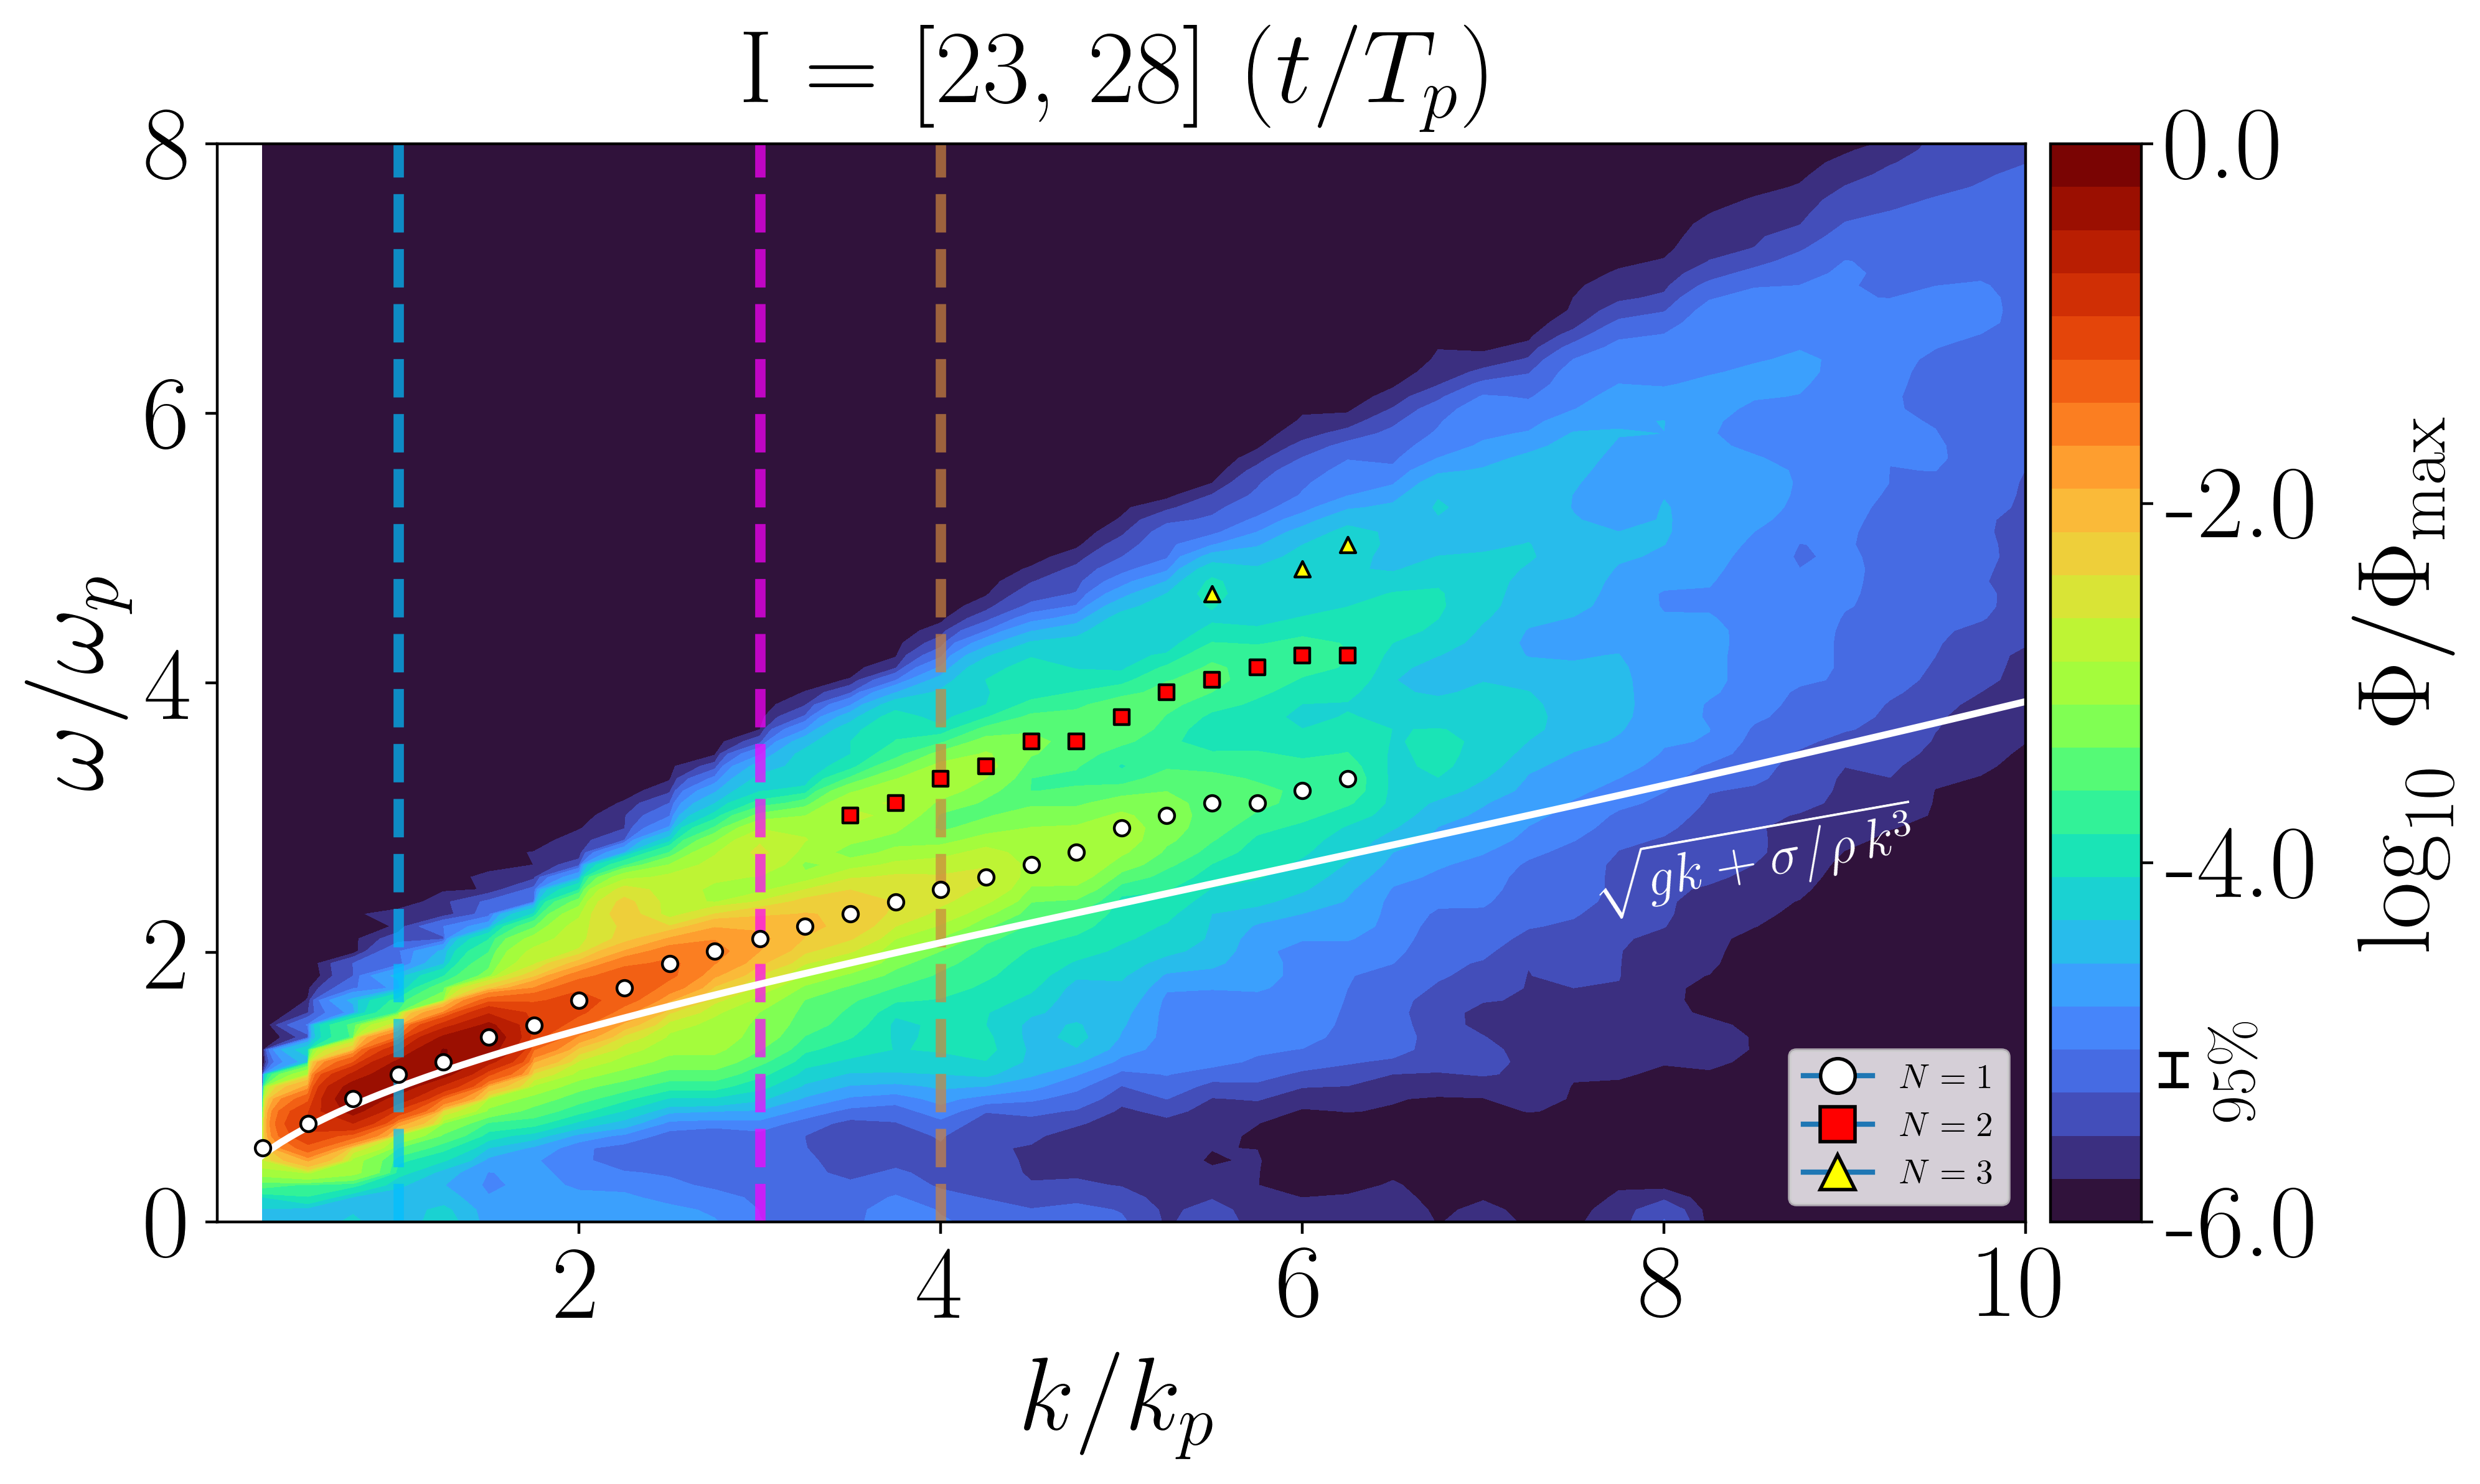

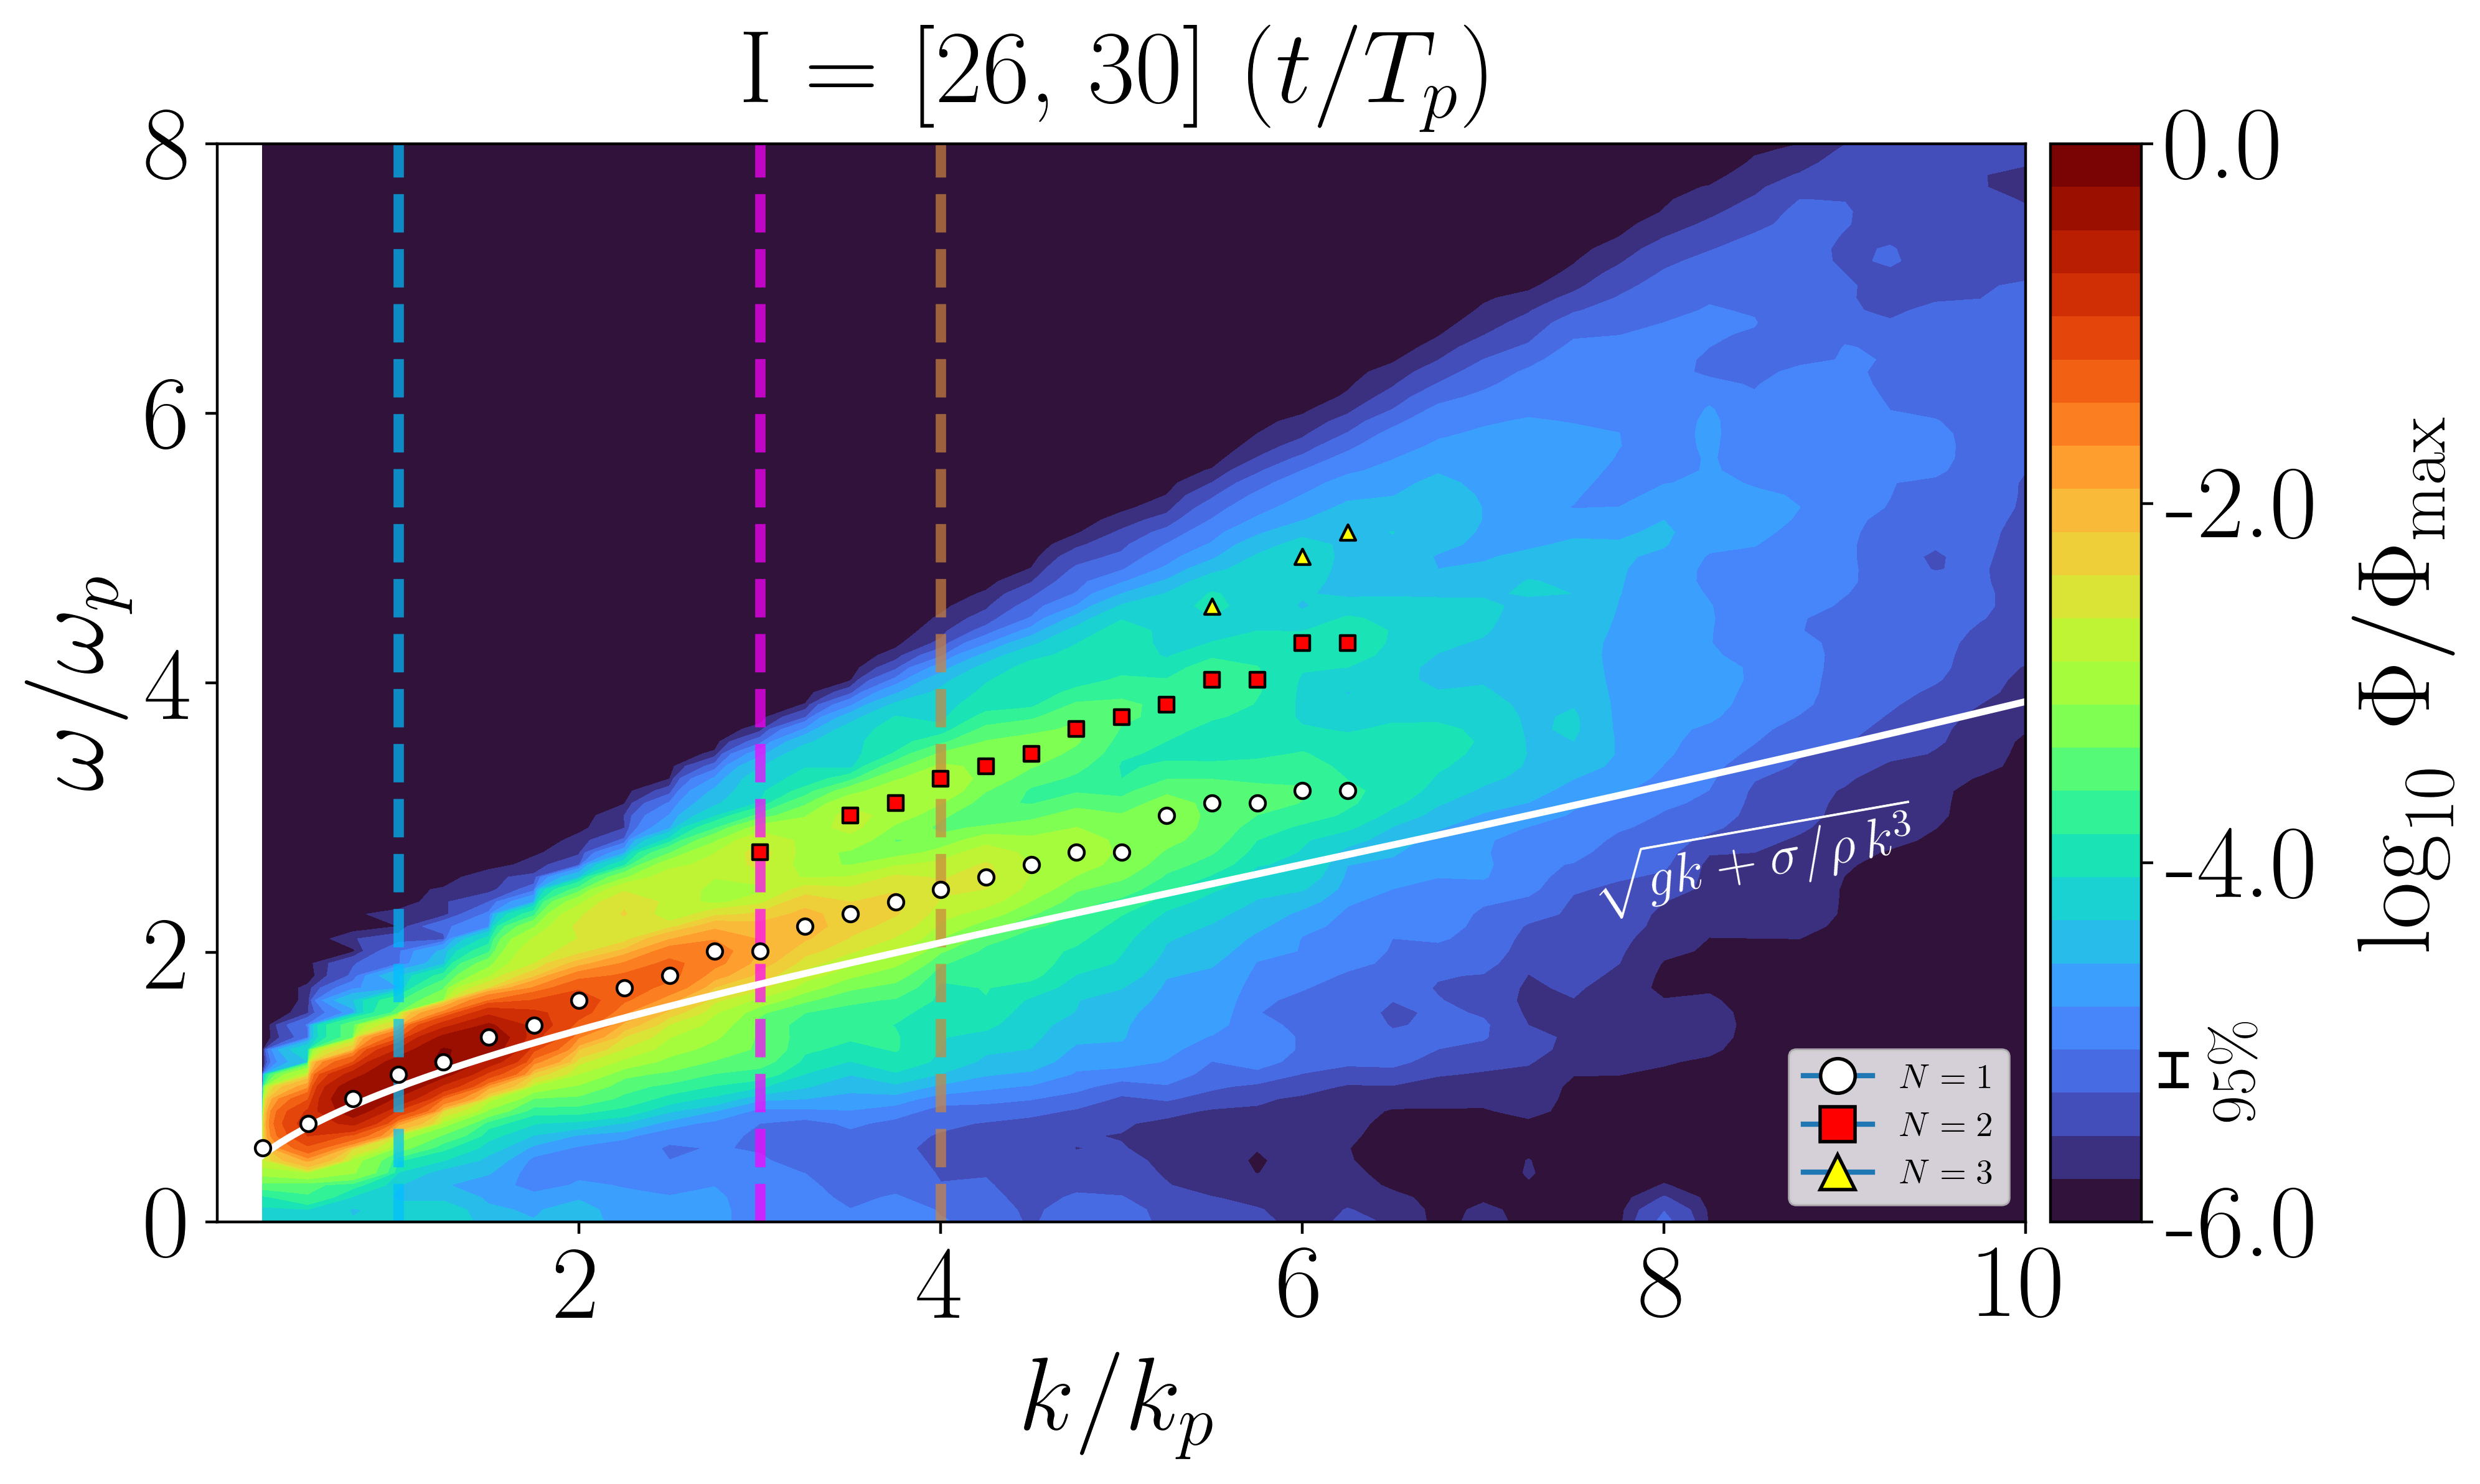

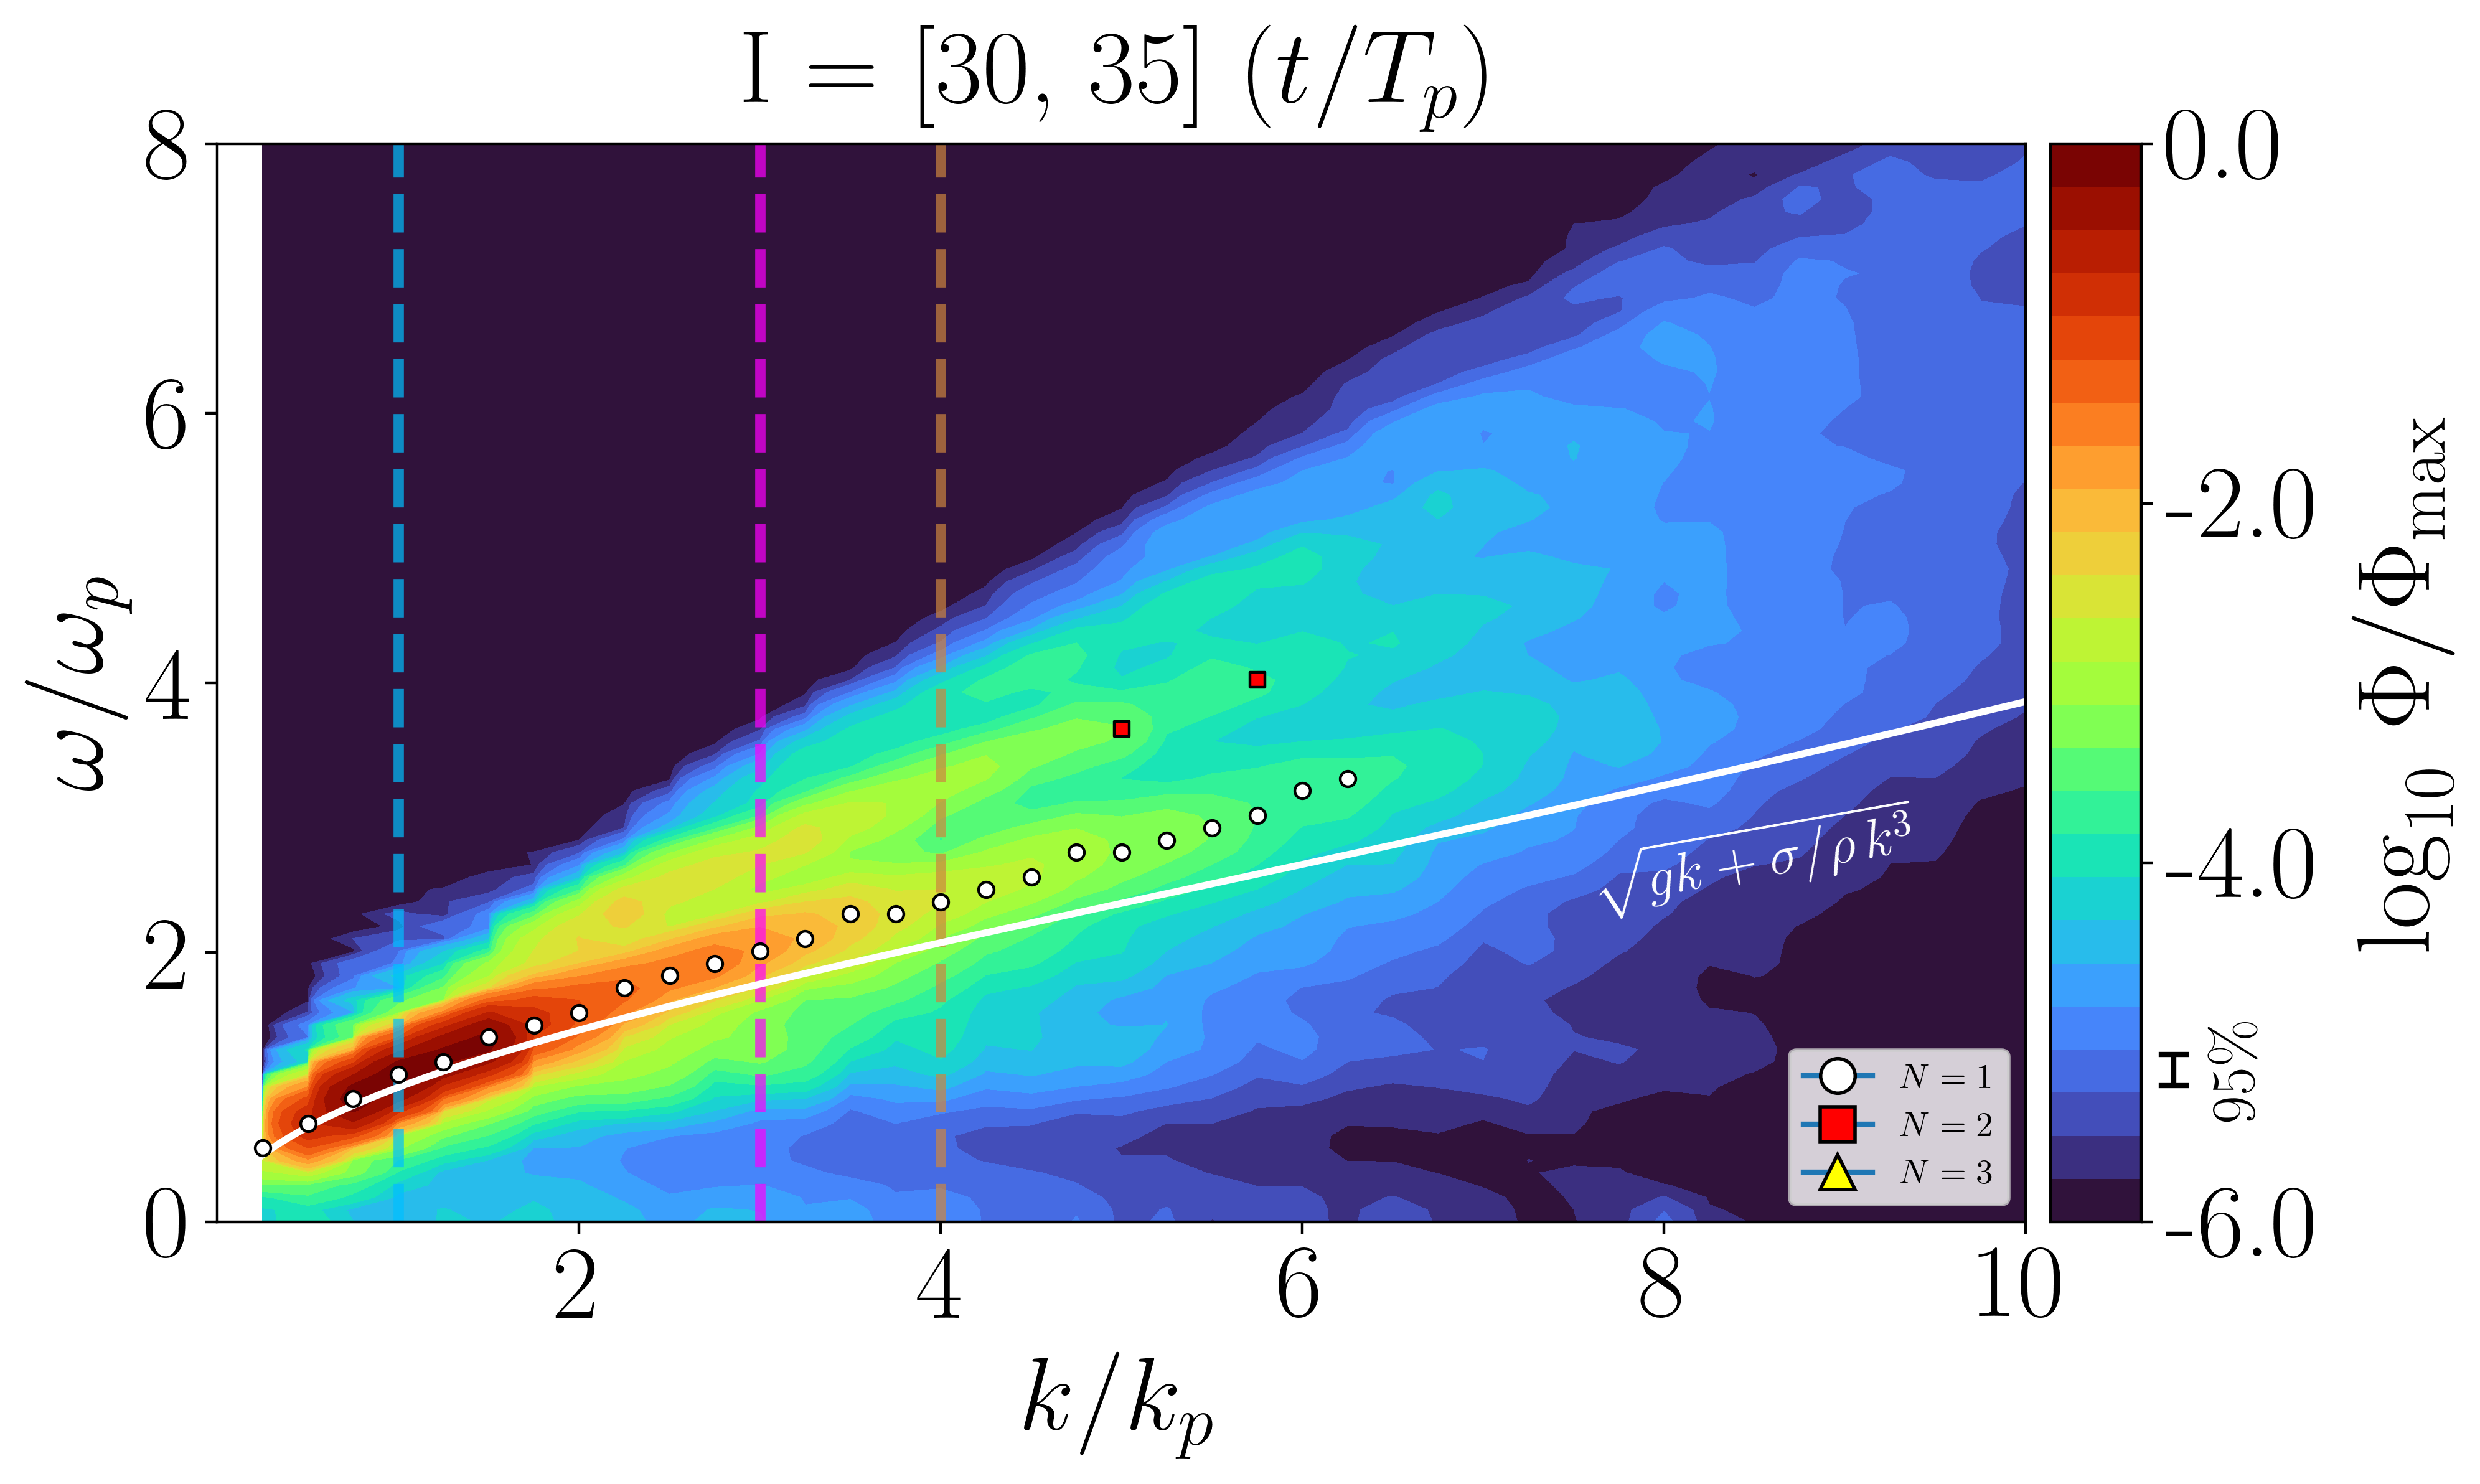

In [21]:
from scipy.signal import find_peaks
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- Configuración previa (sin cambios) ---
global_max = all_F_komega.max()

vmin, vmax = 1e-6, 1.0
n_levels = 25
levels_norm = np.logspace(np.log10(vmin), 0, n_levels + 1)
cmap = ListedColormap(plt.get_cmap('turbo')(np.linspace(0, 1, n_levels)))
norm = LogNorm(vmin=vmin, vmax=vmax)

log_min, log_max = np.log10(vmin), 0.0
log_ticks = np.linspace(log_min, log_max, 4)
ticks = 10**log_ticks
ticklabels = [f"{lt:.1f}" for lt in log_ticks]

N = len(time); L = ln; step = L // 2
M = int(np.floor((N - L) / step)) + 1
ENBW = 1.5
err_frac = 1.96 * np.sqrt(ENBW / M)
dlog10_CI = np.log10(1 + err_frac)
ci_height = dlog10_CI / (log_max - log_min)

colors = ['white', 'red', 'yellow', 'orange']
markers = ['o', 's', '^', 'd']

max_val = global_max
plt.ioff()

dt = t[1] - t[0]
overlap = int(L * 0.5)

k_min, omega_min = 0, 0
num_intervals = all_F_komega.shape[0]

branches = {k: {'k': [], 'omega': [], 'amp': []}
            for k in ['first','second','third','fourth']}
branch_keys = ['first','second','third','fourth']

k_targets = [4.0, 8.0, 12.0]
k_indices_to_plot = [np.argmin(np.abs(k - val)) for val in k_targets]
color_fixed = ['deepskyblue','magenta','peru']

# Probably this could be automatized but right now one has to close the minimum level of looking for the maxima
#height_interval = [-2.5,-2.5,-2.5,-1.5, -1.5,-3,-1.5,-1.5,-1.5,-1.5,-1.5,-1.5,-2,-2,-2,-2,-2,-2,-2,-2,-2] #for ak+0.16 u*/c=0.5
#height_interval = [-4,-3,-3,-3, -3,-3.5,-2.5,-2.5,-2.5,-2.5,-2.5,-2.5,-2,-2,-2,-2,-2,-2,-2,-2,-2]
#height_interval = [-2,-2,-2.5,-2.5, -2.5,-3,-1.5,-1.5,-1.5,-1.5,-1.5,-1.5,-2,-2,-2,-2,-2,-2,-2,-2,-2]
height_interval = [-3.5,-2.5,-1.5,-1.5, -1.5,-1,-1,-1,-1.5,-1.5,-1.5,-1.5,-1.5,-0.5,-0.1,-0.3,-0.5,-0.3,-0.3,-2,-2,-2,-2,-2,-2]#for ak+0.08 u*/c=0.5
#height_interval = [-2.5,-2.5,-2.5,-2.5, -2.5,-2,-1,-1] #for ak+0.08 u*/c=0.5
#height_interval = [-2.5,-2.5,-2.5,-1.5, -1.5,-3,-1.5,-1.5,-1.5,-1.5,-1.5,-1.5,-2,-2,-2,-2,-2,-2,-2,-2,-2]
#height_interval = [-2.5,-2.5,-2.5,-2.5, -2.5,-2.5,-1.5,-1.5,-1.5,-1.5,-1.5,-1.5,-2,-2.5,-2]
#height_interval = [-3.5,-2.5,-1.5,-1.5, -1.5,-1.5,-1.5,-1,-1.5,-1.5,-1.5,-1.5,-1.5,-0.5,-0.1,-0.3,-0.5,-0.3,-0.3,-2,-2,-2,-2,-2,-2]#for ak+0.08 u*/c=0.5
#height_interval = [-2.5,-2.5,-2.5,-2.5, -1,-1.5,-1.5,-1.5,-1.5,-2.5,-1.5,-1.5,-2,-2,-2,-2,-2,-2,-2,-2,-2]

if len(height_interval) < num_intervals:
    raise ValueError("height_interval demasiado corto")

# --- Bucle principal ---
for i in range(num_intervals):
    start = i * step
    if start + L > len(time):
        break

    F_full = np.ma.masked_less_equal(all_F_komega[i], 0)
    k_max_loc = ((9.5 if i < 4 else 6.25) * 4)
    k_idx = np.where((k>=k_min)&(k<=k_max_loc))[0]
    w_idx = np.where((omega>=omega_min)&(omega<=8*omegap))[0]

    sub = np.ma.masked_less_equal(all_F_komega[i][np.ix_(w_idx,k_idx)], 0)
    amps = all_amplitudes_k[i][np.ix_(w_idx,k_idx)]
    kq = k[k_idx]/4; wq = omega[w_idx]/omegap

    fig, ax = plt.subplots(figsize=(10,6))
    cf = ax.contourf(
        k/4, omega/omegap, F_full/max_val,
        levels=levels_norm, cmap=cmap, norm=norm, extend='both'
    )
    for x,c in zip([1,3,4], color_fixed):
        ax.axvline(x, linestyle='--', lw=3, c=c, alpha=0.7)

    # Detección mejorada de picos (hasta 4), con prominence
    for col in range(sub.shape[1]):
        col_data = sub[:, col]
        # Si toda la columna es cero o negativa, la saltamos:
        if col_data.max() <= 0:
            continue
    
        curve = np.log(col_data / col_data.max())
        peaks, props = find_peaks(
            curve,
            height=height_interval[i],
            distance=1,
            prominence=0.1
        )
    
        for j, p in enumerate(peaks[:4]):
            kv = kq[col]
            wv = wq[p]
            av = amps[p, col]
            key = branch_keys[j]
            branches[key]['k'].append(kv)
            branches[key]['omega'].append(wv)
            branches[key]['amp'].append(av)
    
            ax.scatter(
                kv, wv,
                c=colors[j], marker=markers[j],
                s=20, edgecolor='k', linewidth=0.8, zorder=5
            )

    # Dibujar teoría de dispersión
    k_d = np.linspace(0,40,200)
    disp = np.sqrt(k_d*g + ((g-1.25e-3)/(Bo*4**2))/rho1 * k_d**3)/omegap
    ax.plot(k_d/4, disp, '-', lw=2, c='white')
    ax.text(7.6,2.35,
            r'$\sqrt{gk + \sigma/\rho\,k^3}$',
            fontsize=16, rotation=10, color='white')

    # Colorbar discreto
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', size='5%', pad=0.1)
    cb = fig.colorbar(cf, cax=cax,
                      ticks=ticks, boundaries=levels_norm,
                      spacing='proportional', extendfrac=0)
    cb.set_ticklabels(ticklabels)
    cb.set_label(r'$\log_{10}\,\Phi/\Phi_{\max}$', labelpad=10)

    # Barra CI
    x0,y0 = 0.875,0.27
    y1 = y0 + ci_height*0.6
    cap = 0.005
    for yy in (y0,y1):
        fig.lines.append(plt.Line2D([x0-cap,x0+cap],[yy,yy],
                                    transform=fig.transFigure,
                                    color='k',lw=1.5))
    fig.lines.append(plt.Line2D([x0,x0],[y0,y1],
                                transform=fig.transFigure,
                                color='k',lw=1.5,
                                solid_capstyle='butt'))
    fig.text(x0+0.015,(y0+y1)/2,r'$95\%$',
             ha='left',va='center',
             fontsize=18,rotation=90)

    # Leyenda de ramas
    handles = [
        plt.Line2D([0],[0],marker=markers[j],ms=10,
                   markerfacecolor=colors[j],markeredgecolor='k')
        for j in range(3)
    ]
    ax.legend(handles,['$N=1$','$N=2$','$N=3$'],
              loc='lower right',fontsize=10)

    ax.set(xlim=(0,10),ylim=(0,8),
           xticks=[2,4,6,8,10],
           xlabel=r'$k/k_p$',ylabel=r'$\omega/\omega_p$')
    t0 = (time[start]-time[0])*omegap/(2*np.pi)
    t1 = (time[start+L-1]-time[0])*omegap/(2*np.pi)
    ax.set_title(f"I = [{t0:.0f}, {t1:.0f}] $(t/T_p)$", pad=12)

    plt.tight_layout()
    plt.savefig(f"{graph_path}/Ekomega_[{t0:.2f},{t1:.2f}]_disc.pdf",
                dpi=600, bbox_inches='tight')
    plt.show()

#plt.ion()


In [22]:
data = {
    'k_first':    branches['first']['k'],
    'omega_first':branches['first']['omega'],
    'amp_first':  branches['first']['amp'],

    'k_second':    branches['second']['k'],
    'omega_second':branches['second']['omega'],
    'amp_second':  branches['second']['amp'],

    'k_third':     branches['third']['k'],
    'omega_third': branches['third']['omega'],
    'amp_third':   branches['third']['amp'],

    'k_fourth':    branches['fourth']['k'],
    'omega_fourth':branches['fourth']['omega'],
    'amp_fourth':  branches['fourth']['amp'],
}

# Convertimos a DataFrame. 
# Obs.: pandas rellenará con NaN donde las listas tengan distinto largo.
df_branches = pd.DataFrame.from_dict(data, orient='columns')

# Guardamos a CSV
outfile = (
    f'/projects/DEIKE/cmartinb/branches_data/'
    f'branches_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}.csv'
)
df_branches.to_csv(outfile, index=False)

# Opcional: ver en pantalla las primeras filas
print(df_branches.head())

ValueError: All arrays must be of the same length

In [ ]:
normalization_factors = [np.sqrt(1), np.sqrt(1), np.sqrt(1),np.sqrt(1) ]

interval_indices_first = np.array(interval_indices_first, dtype=int)
interval_indices_second = np.array(interval_indices_second, dtype=int)
interval_indices_third = np.array(interval_indices_third, dtype=int)
interval_indices_fourth = np.array(interval_indices_fourth, dtype=int)

normalized_omega_first = np.abs(np.array(omega_values_first)) / normalization_factors[0]
normalized_omega_second = np.abs(np.array(omega_values_second)) / normalization_factors[1]
normalized_omega_third = np.abs(np.array(omega_values_third)) / normalization_factors[2]
normalized_omega_fourth = np.abs(np.array(omega_values_fourth)) / normalization_factors[3]

normalized_differences_first = np.abs(np.array(differences_first)) / normalization_factors[0]
normalized_differences_second = np.abs(np.array(differences_second)) / normalization_factors[1]
normalized_differences_third = np.abs(np.array(differences_third)) / normalization_factors[2]
normalized_differences_fourth = np.abs(np.array(differences_fourth)) / normalization_factors[3]

amplitude_values_first = np.abs(np.array(amplitude_values_first, dtype=int))
amplitude_values_second = np.abs(np.array(amplitude_values_second, dtype=int))
amplitude_values_third = np.abs(np.array(amplitude_values_third, dtype=int))

## Graphs cuts spectra at fixed k

In [ ]:
# Define k_targets (the k values you want to plot)
k_targets = [4.0, 12.0, 16.0]  # e.g. k/kp = 1, 2, 3, 4

# Find the corresponding indices in 'k' for each value in k_targets
k_indices_to_plot = [np.argmin(np.abs(k - val)) for val in k_targets]

# (Optional) Colormaps, though we will use fixed colors for the curves
colormaps = [cm.Greens_r, cm.Reds_r, cm.Blues_r]

# Fixed colors for each curve
color_fixed = ['deepskyblue', 'magenta', 'springgreen']

# Normalization based on the number of intervals (if you use it)
time_norm = mcolors.Normalize(vmin=0, vmax=num_intervals - 1)

# Use the maximum of the logarithmic data to normalize the amplitude
norm = np.max(np.log(all_F_komega))

# Define marker styles and colors for the THREE highest-amplitude peaks:
#  - Peak 1 (highest amplitude): white circle ('o')
#  - Peak 2: red square ('s')
#  - Peak 3: yellow triangle ('^')
marker_styles = ['o', 's', '^']
marker_colors = ['white', 'red', 'yellow']

# x-axis limit values to restrict the analysis interval
x_min = 0.5
x_max = 8  # We will work in the interval omega/omegap ∈ [0.5, 8]

# List to store the number of branches for the green k case
Number_branches = []

# Example curvature threshold (adjust as needed)
min_omega_ratio = 2.0
max_omega_ratio = 8.0
curvature_threshold = -0.05

start_idx = 0

for i in range(num_intervals):
    print(i)
    fig, ax = plt.subplots(figsize=(10, 6))
    end_idx = start_idx + ln
    if end_idx > len(time):
        end_idx = len(time)
    time_subdivision = time[start_idx:end_idx]

    # Recompute normalization for this interval
    norm = np.max(all_F_komega)

    # Plot each selected k
    for j, k_idx in enumerate(k_indices_to_plot):
        line_color = color_fixed[j]

        # Extract the log-amplitude curve for the current interval and k index
        freq_slice = np.log10(all_F_komega[i, :, k_idx] / norm)

        # Plot the full curve (normalized by norm)
        ax.plot(
            omega / omegap,
            freq_slice,
            color=line_color,
            lw=3,
            alpha=0.8
        )

        # -------- METHOD B: Find peaks by amplitude in the desired interval --------
        # 1) Find all peaks on the curve
        peaks_indices, _ = find_peaks(freq_slice)

        # 2) Filter peaks to those where omega/omegap is within [x_min, x_max]
        valid_peaks = [
            p for p in peaks_indices
            if x_min <= (omega[p] / omegap) <= x_max
        ]

        # Special case for the green k value (k_idx == 16)
        if k_idx == 16:
            freq_green = np.log10(all_F_komega[i, :, k_idx] / norm)
            peaks_all, _ = find_peaks(freq_green)
            green_peaks = [
                p for p in peaks_all
                if 6 >= (omega[p] / omegap) >= 2
            ]
            print('Number of branches:', len(green_peaks))
            Number_branches.append(len(green_peaks))

        if valid_peaks:
            # 3) Sort valid peaks by amplitude (descending)
            sorted_peaks = np.array(valid_peaks)[
                np.argsort(freq_slice[valid_peaks])[::-1]
            ]

            # 4) Take the top (j+1) peaks
            top_peaks = sorted_peaks[: j + 1]

            # (Optional debug) Print detected peaks
            print(f"\nInterval {i}, k_idx={k_idx}, color={line_color}:")
            for rank, p_idx in enumerate(top_peaks, start=1):
                print(
                    f"  Peak #{rank}: index={p_idx}, "
                    f"omega/omegap={omega[p_idx] / omegap:.2f}, "
                    f"log value={freq_slice[p_idx]:.4f}, "
                    f"normalized={freq_slice[p_idx] / norm:.4f}"
                )

            # 5) Draw each peak with its marker and color
            for p_idx, m_style, m_color in zip(top_peaks, marker_styles, marker_colors):
                ax.scatter(
                    omega[p_idx] / omegap,
                    freq_slice[p_idx],
                    marker=m_style,
                    s=120,
                    c=m_color,
                    edgecolors='k',
                    linewidths=1.0,
                    zorder=5
                )

    # Create legend entries for each k/kp curve
    handles_k = [
        plt.Line2D([0], [0], color='deepskyblue', linestyle='-', label=f"$k = {k_targets[0]/4:.0f}k_p$"),
        plt.Line2D([0], [0], color='magenta', linestyle='-', label=f"$k = {k_targets[1]/4:.0f}k_p$"),
        plt.Line2D([0], [0], color='springgreen', linestyle='-', label=f"$k = {k_targets[2]/4:.0f}k_p$")
    ]
    legend_k = ax.legend(handles=handles_k, loc='upper right', fontsize=20)
    ax.add_artist(legend_k)

    # Axis labels and title
    ax.set_xlabel(r'$\omega / \omega_p$', fontsize=30)
    ax.set_ylabel(r'$\log_{10}\Phi/\Phi_{\max}$', fontsize=30)
    ax.set_xlim([0, 4.5])
    ax.set_ylim([-6, 0.1])
    ax.set_title(
        f"I = [{(time_subdivision[0] - time[0]) * omegap / (2*np.pi):.0f}, "
        f"{(time_subdivision[-1] - time[0]) * omegap / (2*np.pi):.0f}] $(t/T_p)$",
        pad=15
    )

    plt.tight_layout()
    plt.savefig(f"{graph_path}/E_kfixed_interval_{i}.pdf")
    plt.show()

    start_idx += (ln - overlap)
    if start_idx >= len(time):
        break


In [ ]:
#II = np.arange(0,num_intervals,1)
#plt.plot(var_list,c = 'orange')
#plt.scatter(II,Number_branches)
#plt.ylabel(f'$k_pH_s$')
#plt.ylabel(f'I')
#plt.show()

In [ ]:
#plt.scatter(var_list,Number_branches)

In [ ]:

file_path = f'/projects/DEIKE/cmartinb/mean_velocity/mean_velocity_Bo{Bo}_kpHs{kpHs}_uoc{uoc}_L{maxLevel}.csv'

df_meanvelocity = pd.read_csv(file_path)

phi_avg = df_meanvelocity['phi_avg']
ux_avg = df_meanvelocity['ux_avg']
time_moyens =  df_meanvelocity['time_moyens']
u_atzero = df_meanvelocity['u_atzero']  


In [ ]:
num_intervals = all_F_komega.shape[0]
start_idx = 0
num_intervalo = 0

interval_ranges = []

for i in range(num_intervals):
    end_idx = start_idx + ln
    if end_idx > len(time):
        end_idx = len(time)
    time_subdivision = time[start_idx:end_idx]
    print(f'I = [{(time_subdivision[0] - time[0]) * omegap / (2 * np.pi):.0f}, {(time_subdivision[-1] - time[0]) * omegap / (2 * np.pi):.0f}] $(t/T_{{p}})$')
    interval_ranges.append(f'I = [{(time_subdivision[0] - time[0]) * omegap / (2 * np.pi):.0f}, {(time_subdivision[-1] - time[0]) * omegap / (2 * np.pi):.0f}] $(t/T_{{p}})$')
    start_idx += (ln - overlap)
    num_intervalo +=1
    if start_idx >= len(time):
        break


In [ ]:
print(type(interval_ranges))

In [ ]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

# Parámetros adicionales
rho = 1
sigma = (g - 1.25 * 10**(-3)) / (Bo * 4**2)
interval_colors = plt.cm.viridis(np.linspace(0, 1, num_intervals))

fig, ax = plt.subplots(figsize=(10, 5))

symbols = ['o', 's', '^']
labels = ['First', 'Second', 'Third']       

# Parámetros específicos
num_intervalo = 0
overlap_fraction = 0.5
ln = 150
overlap = int(overlap_fraction * ln)
k_p = 4
start_idx = 0

print(num_intervalo)
time_analysis=[]
integral_num_time =[]

#for i in [0,2,6]:



u_const= [0.01, 0.03, 0.04]
j=0
for i in [0,2,6]:
    end_idx = start_idx + ln
    if end_idx > len(time):
        end_idx = min(start_idx + ln, len(time) - 1)
    time_subdivision = time[start_idx:end_idx]

    idx_first = interval_indices_first == i
    base_normalized = normalized_omega_first
    
    idx_second = interval_indices_second == i
    idx_third = interval_indices_third == i
    
    time_analysis.append(time[end_idx] - time[0])
    print(f"Doppler {interval_ranges[i]}" )
    if np.any(idx_first):
        k_first = np.array(k_values_first)[idx_first]
        c_first = (normalized_omega_first[idx_first] * omegap) / (4 * k_first)
        
        ax.plot(k_first, normalized_omega_first[idx_first], symbols[0], markersize=5, color=interval_colors[i], label=interval_ranges[i] if i == 8 else "")

        # Convertir los perfiles de velocidad y profundidad a arrays numéricos
        ux_avg_i = np.array([float(x) for x in ux_avg[i].strip("[]").split(",")])  # Perfil de velocidad en el intervalo actual
        phi_avg_i = np.array([float(x) for x in phi_avg[i].strip("[]").split(",")])  # Perfil de profundidad en el intervalo actual

        # Realizar la integración para cada valor de k
        integral_num = []
        h = 1
        #uszt1k = calcular_integral1(4 * k_first, (time[end_idx] - time[0]), u_atzero[i], h)
        #print(ux_avg_i)
        for (ki,omegai) in zip(k_first,normalized_omega_first[idx_first]):
            #h_val = 1
            integrand_values = (ux_avg_i) * np.exp(2* ki * 4 * phi_avg_i)
            doppler_shift_speed = 4 * ki * np.trapz(integrand_values, phi_avg_i)
            integral_num.append(doppler_shift_speed)

        print(2 * np.array(integral_num) * k_first * 4)
        ax.plot(k_first, (np.sqrt(g * k_first * 4 + sigma * (k_first * 4)**3) + 2 * np.array(integral_num)* k_first * 4) / omegap,
                '--', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
        
        #ax.plot(k_first, (np.sqrt(g * k_first * 4 + sigma * (k_first * 4)**3) + 2 * np.array(integral_num) * k_first * 4) / omegap,
                #'--', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
        #ax.plot(k_first, (np.sqrt(g * k_first * 4 + sigma * (k_first * 4)**3) + 2 * np.array(integral_num) * k_first * 4) / omegap,
                #'--', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")

    j+=1
    integral_num_time.append(integral_num)
    start_idx += (ln - overlap)
    if start_idx >= len(time):
        break

        

# Añadir la relación de dispersión teórica para el agua
k_diss = np.linspace(0, 40, 200)
dispersion_relation = np.sqrt(k_diss * g)
dispersion_relation_tension = np.sqrt(k_diss * g + sigma / rho * k_diss**3)

#ax.plot(k_diss / 4, dispersion_relation / omegap, '-', c='black', lw=2, label=r"$\omega= \sqrt{gk}$")
ax.plot(k_diss / 4, dispersion_relation_tension / omegap, '-', lw=2, c='black', label=r"$\omega= \sqrt{gNk + \sigma/\rho k^3/N}$")

# Configuración del gráfico y leyenda
symbols2 = ['-', '--'] #'--',
#labels2 = [r'$\omega = \sqrt{gk + \sigma/ \rho (k)^3} $', r'$\omega_2 = 2(\sqrt{g(k/2) + \sigma/ \rho (k/2)^3} + u_{DNS}(k/2,t) k/2)$',r'$\omega_3 = 3(\sqrt{g(k/3) + \sigma/ \rho (k/3)^3} + u_{DNS}(k/3,t) k/3)$'] # r'$\omega = \sqrt{gk + \sigma/ \rho k^3} + u_{a}(k,t) k$',
labels2 = [r'$\omega = \sqrt{gk + \sigma/ \rho (k)^3} $', r'$\omega= \sqrt{gk + \sigma/ \rho k^3} + U k$']

lines2 = [
    plt.Line2D([0], [0], linestyle=s, color='black', linewidth=2, alpha=1.0) if i < 2 
    else plt.Line2D([0], [0], linestyle=s, color='black', linewidth=2, alpha=0.5)
    for i, s in enumerate(symbols2)
]

second_legend = ax.legend(lines2, labels2, bbox_to_anchor=(0.62, 0.999), facecolor="white", framealpha=0.5, labelcolor='black')
ax.add_artist(second_legend)

#first_legend = ax.legend([plt.Line2D([0], [0], marker=s, color='w', markerfacecolor='black', markersize=10) for s in symbols], labels, loc='lower right', title='Branch')
#ax.add_artist(first_legend)
unique_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=interval_colors[i], markersize=10) for i in [0,2,6]]
ax.legend(unique_handles, [interval_ranges[j] for j in [0,2,6]], loc='upper left', title='Interval')

#  Después de crear second_legend, insertamos un texto con los valores de u:
text_x = 0.62      # misma coordenada x que la leyenda
text_y = 0.93      # un poco por debajo de 0.999 (elige según convenga)
ax.text(
    text_x, text_y,
    r'$U = (0.01,0.03,0.04)$',
    transform=ax.transAxes,
    fontsize=14,
    color='black'
)


ax.set_ylim([0, 8])
ax.set_xlim([0, 10])
ax.set_xlabel(r'$k/k_{p}$')
ax.set_ylabel(r'$ \omega/\omega_{p}$')

# Guardar y mostrar el gráfico
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/3D_spectra/kpHs{kpHs}uoc{uoc}/branches.png')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branchesandu.png', dpi=300, bbox_inches='tight')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_viscousregime.png', dpi=300, bbox_inches='tight')
plt.savefig(graph_path+f'/branches_DNS1conrs.pdf', dpi=300, bbox_inches='tight')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_turbulentregime.png, {(time_subdivision[-1]-time[0])*omegap:.2f}].png', dpi=300, bbox_inches='tight')
 
plt.show()


In [ ]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

# Parámetros adicionales
rho = 1
sigma = (g - 1.25 * 10**(-3)) / (Bo * 4**2)
interval_colors = plt.cm.viridis(np.linspace(0, 1, num_intervals))

fig, ax = plt.subplots(figsize=(10, 6))

symbols = ['o', 's', '^']
labels = ['First', 'Second', 'Third']       

# Parámetros específicos
num_intervalo = 0
overlap_fraction = 0.5
ln = 150
overlap = int(overlap_fraction * ln)
k_p = 4
start_idx = 0

print(num_intervalo)
time_analysis=[]
integral_num_time =[]

#for i in [0,2,6]:


u_const= [0.01, 0.03, 0.04]
j=0
for i in [0,2,6]:
    end_idx = start_idx + ln
    if end_idx > len(time):
        end_idx = min(start_idx + ln, len(time) - 1)
    time_subdivision = time[start_idx:end_idx]

    idx_first = interval_indices_first == i
    base_normalized = normalized_omega_first
    
    idx_second = interval_indices_second == i
    idx_third = interval_indices_third == i
    
    time_analysis.append(time[end_idx] - time[0])
    print(f"Doppler {interval_ranges[i]}" )
    if np.any(idx_first):
        k_first = np.array(k_values_first)[idx_first]
        c_first = (normalized_omega_first[idx_first] * omegap) / (4 * k_first)
        
        ax.plot(k_first, normalized_omega_first[idx_first], symbols[0], markersize=5, color=interval_colors[i], label=interval_ranges[i] if i == 8 else "")

        # Convertir los perfiles de velocidad y profundidad a arrays numéricos
        #ux_avg_i = np.array([float(x) for x in ux_avg[i].strip("[]").split(",")])  # Perfil de velocidad en el intervalo actual
        #phi_avg_i = np.array([float(x) for x in phi_avg[i].strip("[]").split(",")])  # Perfil de profundidad en el intervalo actual
        #idx_turb = idx_turb_list[j]
        ux_avg_i = prof_L10_wat_wfc[i_v_d_L10[i],:]  # Perfil de velocidad en el intervalo actual
        phi_avg_i = zgrid_L10_wfc[i_v_d_L10[i],:]-1 # Perfil de profundidad en el intervalo actual
                
        #ux_avg_i = prof_L10_wat_abs[i_v_d_L10[i],:]  # Perfil de velocidad en el intervalo actual
        #phi_avg_i = zgrid_L10_abs[i_v_d_L10[i],:]-1 # Perfil de profundidad en el intervalo actu


        integral_num = []
        h = 1
        for (ki,omegai) in zip(k_first,normalized_omega_first[idx_first]):
            #h_val = 1
            integrand_values = (ux_avg_i) * np.exp(2* ki * 4 * phi_avg_i)
            doppler_shift_speed = 4 * ki * np.trapz(integrand_values, phi_avg_i)
            integral_num.append(doppler_shift_speed)

        print(2 * np.array(integral_num) * k_first * 4)
        ax.plot(k_first, (np.sqrt(g * k_first * 4 + sigma * (k_first * 4)**3) + 2 * np.array(integral_num)* k_first * 4) / omegap,
                '--', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
        
        #ax.plot(k_first, (np.sqrt(g * k_first * 4 + sigma * (k_first * 4)**3) + 2 * np.array(integral_num) * k_first * 4) / omegap,
                #'--', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
        #ax.plot(k_first, (np.sqrt(g * k_first * 4 + sigma * (k_first * 4)**3) + 2 * np.array(integral_num) * k_first * 4) / omegap,
                #'--', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")

    j+=1
    integral_num_time.append(integral_num)
    start_idx += (ln - overlap)
    if start_idx >= len(time):
        break

        

# Añadir la relación de dispersión teórica para el agua
k_diss = np.linspace(0, 40, 200)
dispersion_relation = np.sqrt(k_diss * g)
dispersion_relation_tension = np.sqrt(k_diss * g + sigma / rho * k_diss**3)

#ax.plot(k_diss / 4, dispersion_relation / omegap, '-', c='black', lw=2, label=r"$\omega= \sqrt{gk}$")
ax.plot(k_diss / 4, dispersion_relation_tension / omegap, '-', lw=2, c='black', label=r"$\omega= \sqrt{gNk + \sigma/\rho k^3/N}$")

# Configuración del gráfico y leyenda
symbols2 = ['-', '--'] #'--',
#labels2 = [r'$\omega = \sqrt{gk + \sigma/ \rho (k)^3} $', r'$\omega_2 = 2(\sqrt{g(k/2) + \sigma/ \rho (k/2)^3} + u_{DNS}(k/2,t) k/2)$',r'$\omega_3 = 3(\sqrt{g(k/3) + \sigma/ \rho (k/3)^3} + u_{DNS}(k/3,t) k/3)$'] # r'$\omega = \sqrt{gk + \sigma/ \rho k^3} + u_{a}(k,t) k$',
labels2 = [r'$\omega = \sqrt{gk + \sigma/ \rho (k)^3} $', r'$\omega= \sqrt{gk + \sigma/ \rho k^3} + u_{DNS}(k,t) k$']

lines2 = [
    plt.Line2D([0], [0], linestyle=s, color='black', linewidth=2, alpha=1.0) if i < 2 
    else plt.Line2D([0], [0], linestyle=s, color='black', linewidth=2, alpha=0.5)
    for i, s in enumerate(symbols2)
]

second_legend = ax.legend(
    lines2,
    labels2,
    bbox_to_anchor=(0.98, 0.999),
    facecolor="white",
    framealpha=0.5,
    labelcolor='black',
    fontsize=19,         # Tamaño de letra de las etiquetas
    title_fontsize=19   # Si tuvieses título en la leyenda
)
ax.add_artist(second_legend)

#first_legend = ax.legend([plt.Line2D([0], [0], marker=s, color='w', markerfacecolor='black', markersize=10) for s in symbols], labels, loc='lower right', title='Branch')
#ax.add_artist(first_legend)
unique_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=interval_colors[i], markersize=15) for i in [0,2,6]]
ax.legend(unique_handles, [interval_ranges[j] for j in [0,2,6]], loc='upper left', title='Interval', fontsize=18,title_fontsize=18)

ax.set_ylim([0, 8])
ax.set_xlim([0, 10])
ax.set_xlabel(r'$k/k_{p}$')
ax.set_ylabel(r'$ \omega/\omega_{p}$')

# Guardar y mostrar el gráfico
#plt.title(f'Early times: viscous boundary layer', pad =0.7)
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/3D_spectra/kpHs{kpHs}uoc{uoc}/branches.png')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branchesandu.png', dpi=300, bbox_inches='tight')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_viscousregime.png', dpi=300, bbox_inches='tight')
plt.savefig(graph_path+f'/branches_DNS1.pdf', dpi=600, bbox_inches='tight')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_turbulentregime.png, {(time_subdivision[-1]-time[0])*omegap:.2f}].png', dpi=300, bbox_inches='tight')
 
plt.show()


In [ ]:
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
         'axes.labelsize': 30,
         'axes.titlesize':30,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
    'font.family': 'STIXGeneral', 
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True, # Enable LaTeX rendering
}

plt.rcParams.update(params)
pylab.rcParams.update(params)

In [ ]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

# Parámetros adicionales
#rho = 1
#sigma = (g - 1.25 * 10**(-3)) / (Bo * 4**2)
interval_colors = plt.cm.viridis(np.linspace(0, 1, num_intervals))

fig, ax = plt.subplots(figsize=(10, 6))

# Parámetros específicos
num_intervalo = 0
overlap_fraction = 0.5
ln = 150
overlap = int(overlap_fraction * ln)
k_p = 4
start_idx = 0
idx_turb_list = [6,13,14]

print(num_intervalo)
time_analysis=[]
integral_num_time =[]
j = 0
for i in [7,10,14]:
    end_idx = start_idx + ln
    if end_idx > len(time):
        end_idx = len(time)
    time_subdivision = time[start_idx:end_idx]

    idx_first = interval_indices_first == i
    base_normalized = normalized_omega_first
    
    idx_second = interval_indices_second == i
    idx_third = interval_indices_third == i
    
    time_analysis.append(time[end_idx] - time[0])
    
    if np.any(idx_first):
        k_first = np.array(k_values_first)[idx_first]
        c_first = (normalized_omega_first[idx_first] * omegap) / (4 * k_first)
        
        ax.plot(k_first, normalized_omega_first[idx_first], symbols[0], markersize=5, color=interval_colors[i], label=interval_ranges[i+6] if i ==0 else "")

        # Convertir los perfiles de velocidad y profundidad a arrays numéricos
        #ux_avg_i = np.array([float(x) for x in ux_avg[i].strip("[]").split(",")])  # Perfil de velocidad en el intervalo actual
        #phi_avg_i = np.array([float(x) for x in phi_avg[i].strip("[]").split(",")])  # Perfil de profundidad en el intervalo actual
        idx_turb = idx_turb_list[j]
        print('t', i_v_d_L10[idx_turb])
        ux_avg_i = prof_L10_wat_wfc[i_v_d_L10[idx_turb],:]  # Perfil de velocidad en el intervalo actual
        phi_avg_i = zgrid_L10_wfc[i_v_d_L10[idx_turb],:]-1 # Perfil de profundidad en el intervalo actual
                
        # Realizar la integración para cada valor de k
        integral_num = []
        h = 1
        #uszt1k = calcular_integral1(4 * k_first, (time[end_idx] - time[0]), u_atzero[i], h)
        
        for (ki,omegai) in zip(k_first,normalized_omega_first[idx_first]):
            h_val = -1

            integrand_values = (ux_avg_i) * np.exp(2* ki * 4 * phi_avg_i - 0 )
            doppler_shift_speed = 4 * ki * np.trapz(integrand_values, phi_avg_i)
            #print('time',time[end_idx] - time[0], 'k', k, 'Integral', doppler_shift_speed )
            integral_num.append(doppler_shift_speed)
        
        # Graficar resultados sin interpolación
        #ax.plot(k_first, (np.sqrt(g * k_first * 4 + sigma * (k_first * 4)**3) - uszt1k * k_first * 4) / omegap, '--', linewidth=3, color=interval_colors[i - 8], label=interval_ranges[i] if i == 8 else "")
        ax.plot(k_first, (np.sqrt(g * k_first * 4 + sigma * (k_first * 4)**3) + 2 * np.array(integral_num) * k_first * 4) / omegap,
                '--', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
    if np.any(idx_second):
        k_second = np.array(k_values_second)[idx_second]
        c_second = normalized_omega_second[idx_second] / k_second
        h = 2 * np.pi / (np.pi * 3.5) / (4 * k_second)
        #uszt2k = calcular_integral1(4 * k_second, (time[end_idx] - time[0]), u_atzero[i], h)
        integral_num = []
        
        for ki in k_second:
            h_val = -1
            integrand_values = (ux_avg_i) * np.exp(2 * ki * 4 * phi_avg_i)
            doppler_shift_speed = 4 * ki * np.trapz(integrand_values, phi_avg_i)
            integral_num.append(doppler_shift_speed)

        #ax.plot(k_second, normalized_omega_second[idx_second], symbols[1], markersize=5, color=interval_colors[i], label=interval_ranges[i] if i == 8 else "")
        #ax.plot(k_second, (np.sqrt(g * 2 * k_second * 4 + sigma * (k_second * 4)**3 / 2) - uszt2k * k_second * 4) / omegap, '--', linewidth=2, color=interval_colors[i - 8], label=interval_ranges[i] if i == 8 else "")        
        #ax.plot(k_second, (np.sqrt(g * 2 * k_second * 4 + sigma * (k_second * 4)**3 / 2) + 2 * np.array(integral_num) * k_second * 4) / omegap,
                #'-.', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
    
    if np.any(idx_third):
        k_third = np.array(k_values_third)[idx_third]
        c_third = normalized_omega_third[idx_third] / k_third
        h = 2 * np.pi / (np.pi * 7) / (4 * k_third)
        #uszt3k = calcular_integral1(4 * k_third, (time[end_idx] - time[0]), u_atzero[i], h)
        integral_num = []
        
        for ki in k_third:
            h_val = -1

            integrand_values = (ux_avg_i) * np.exp(2 * ki * 4 * phi_avg_i)
            doppler_shift_speed = 4 * ki * np.trapz(integrand_values, phi_avg_i)
            integral_num.append(doppler_shift_speed)
            
        #ax.plot(k_third, normalized_omega_third[idx_third], symbols[2], markersize=5, color=interval_colors[i], label=interval_ranges[i] if i == 8 else "")
        #ax.plot(k_third, (np.sqrt(g * 3 * k_third * 4 + sigma * (k_third * 4)**3 / 3) - uszt3k * k_third * 4) / omegap, '--', linewidth=2, color=interval_colors[i - 8], label=interval_ranges[i] if i == 8 else "")
        #ax.plot(k_third, (np.sqrt(g * 3 * k_third * 4 + sigma * (k_third * 4)**3 / 3) + 2 * np.array(integral_num) * k_third * 4) / omegap,
                #':', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
    
    j+=1
    integral_num_time.append(integral_num)
    start_idx += (ln - overlap)
    if start_idx >= len(time):
        break

# Añadir la relación de dispersión teórica para el agua
k_diss = np.linspace(0, 40, 200)
dispersion_relation = np.sqrt(k_diss * g)
dispersion_relation_tension = np.sqrt(k_diss * g + sigma / rho * k_diss**3)

#ax.plot(k_diss / 4, dispersion_relation / omegap, '-', c='black', lw=2, label=r"$\omega= \sqrt{gk}$")
ax.plot(k_diss / 4, dispersion_relation_tension / omegap, '-', lw=2, c='black', label=r"$\omega= \sqrt{gk + \sigma/\rho k^3}$")

# Configuración del gráfico y leyenda
symbols2 = ['-', '--'] #'--',
#labels2 = [r'$\omega = \sqrt{gk + \sigma/ \rho (k)^3} $', r'$\omega_2 = 2(\sqrt{g(k/2) + \sigma/ \rho (k/2)^3} + u_{DNS}(k/2,t) k/2)$',r'$\omega_3 = 3(\sqrt{g(k/3) + \sigma/ \rho (k/3)^3} + u_{DNS}(k/3,t) k/3)$'] # r'$\omega = \sqrt{gk + \sigma/ \rho k^3} + u_{a}(k,t) k$',
labels2 = [r'$\omega = \sqrt{gk + \sigma/ \rho (k)^3} $', r'$\omega= \sqrt{gk + \sigma/ \rho k^3} + u_{DNS}(k,t) k$']

lines2 = [
    plt.Line2D([0], [0], linestyle=s, color='black', linewidth=2, alpha=1.0) if i < 2 
    else plt.Line2D([0], [0], linestyle=s, color='black', linewidth=2, alpha=0.5)
    for i, s in enumerate(symbols2)
]

second_legend = ax.legend(
    lines2,
    labels2,
    bbox_to_anchor=(0.99, 0.999),
    facecolor="white",
    framealpha=0.5,
    labelcolor='black',
    fontsize=19,         # Tamaño de letra de las etiquetas
    title_fontsize=19   # Si tuvieses título en la leyenda
)
ax.add_artist(second_legend)
for idx in [6,9,14]:
    try:
        print("Etiqueta", idx, ":", interval_ranges[idx])
    except IndexError:
        print("Índice fuera de rango:", idx)

print('9' ,interval_ranges[9], '14',interval_ranges[14])
idxs = [6, 9, 14]

unique_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=interval_colors[i], markersize=15) for i in [7,10,14]]
ax.legend(unique_handles, [interval_ranges[j] for j in [7,10,14]], loc='upper left', title='Interval', fontsize=18,title_fontsize=18)

ax.set_ylim([0, 8])
ax.set_xlim([0, 10])
ax.set_xlabel(r'$k/k_{p}$')
ax.set_ylabel(r'$ \omega/\omega_{p}$')
#plt.title(f'Later times: turbulent boundary layer')
plt.savefig(graph_path+f'/branches_DNSturb.pdf', dpi=300, bbox_inches='tight')
# Guardar y mostrar el gráfico
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_turbulentregime.png', dpi=300, bbox_inches='tight')
 
plt.show()

In [ ]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

# Parámetros adicionales
rho = 1
sigma = (g - 1.25 * 10**(-3)) / (Bo * 4**2)
interval_colors = plt.cm.viridis(np.linspace(0, 1, num_intervals))

fig, ax = plt.subplots(figsize=(10, 5))

symbols = ['o', 's', '^']
labels = ['First', 'Second', 'Third']       

# Parámetros específicos
num_intervalo = 0
overlap_fraction = 0.5
ln = 150
overlap = int(overlap_fraction * ln)
k_p = 4
start_idx = 0

print(num_intervalo)
time_analysis=[]
integral_num_time =[]
st = 3
sp = 10
#for i in range(0,5,2):
for i in range(0,num_intervals):
    end_idx = start_idx + ln
    if end_idx > len(time):
        end_idx = min(start_idx + ln, len(time) - 1)
    time_subdivision = time[start_idx:end_idx]

    idx_first = interval_indices_first == i
    base_normalized = normalized_omega_first
    
    idx_second = interval_indices_second == i
    idx_third = interval_indices_third == i
    
    time_analysis.append(time[end_idx] - time[0])
    
    if np.any(idx_first):
        k_first = np.array(k_values_first)[idx_first]
        c_first = (normalized_omega_first[idx_first] * omegap) / (4 * k_first)
        

        # Convertir los perfiles de velocidad y profundidad a arrays numéricos
        #ux_avg_i = np.array([float(x) for x in ux_avg[i].strip("[]").split(",")])  # Perfil de velocidad en el intervalo actual
        #phi_avg_i = np.array([float(x) for x in phi_avg[i].strip("[]").split(",")])  # Perfil de profundidad en el intervalo actual

        ux_avg_i10 = prof_L10_wat_wfc[i_v_d_L10[i],:]  # Perfil de velocidad en el intervalo actual
        phi_avg_i10 = zgrid_L10_wfc[i_v_d_L10[i],:]-1 # Perfil de profundidad en el intervalo actual
                
        #ux_avg_i11 = prof_L11_wat_wfc[i_v_d_L11[i],:]  # Perfil de velocidad en el intervalo actual
        #phi_avg_i11 = zgrid_L11_wfc[i_v_d_L11[i],:]-1 # Perfil de profundidad en el intervalo actual

        
        #ux_avg_i = prof_L10_wat_abs[i_v_d_L10[i],:]  # Perfil de velocidad en el intervalo actual
        #phi_avg_i = zgrid_L10_abs[i_v_d_L10[i],:]-1 # Perfil de profundidad en el intervalo actu
        
        # Realizar la integración para cada valor de k
        integral_num10 = []
        integral_num11 =[]
        integral_num =[]
        for (ki,omegai) in zip(k_first,normalized_omega_first[idx_first]):
            #h_val = 1
            integrand_values10 = (ux_avg_i10) * np.exp(2* ki * 4 * phi_avg_i10)
            doppler_shift_speed10 = 4 * ki * np.trapz(integrand_values10, phi_avg_i10)
            integral_num10.append(doppler_shift_speed10)


        #print(2 * np.array(integral_num) * k_first * 4)
        ax.plot(k_first, 2 * np.array(integral_num10)/ u,
                '-', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
        #ax.plot(k_first, (np.sqrt(g * k_first * 4 + sigma * (k_first * 4)**3) + 2 * np.array(integral_num) * k_first * 4) / omegap,
                #'--', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")

    
    integral_num_time.append(integral_num)
    start_idx += (ln - overlap)
    if start_idx >= len(time):
        break

#first_legend = ax.legend([plt.Line2D([0], [0], marker=s, color='w', markerfacecolor='black', markersize=10) for s in symbols], labels, loc='lower right', title='Branch')
#ax.add_artist(first_legend)
#unique_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=interval_colors[i], markersize=15) for i in [0,2,6,7,10,14]]
#ax.legend(unique_handles, [interval_ranges[j] for j in [0,2,6,7,10,14]], loc='upper left', title='Interval', fontsize=18,title_fontsize=18)


ax.set_ylim([0, 0.3])
ax.set_xlim([0, 10])
ax.set_xlabel(r'$k/k_{p}$')
ax.set_ylabel(r'$u_{eff}(k,t)/ u_{*}$')

# Guardar y mostrar el gráfico
#plt.title(f'Early times: viscous boundary layer')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/3D_spectra/kpHs{kpHs}uoc{uoc}/branches.png')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branchesandu.png', dpi=300, bbox_inches='tight')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_viscousregime.png', dpi=300, bbox_inches='tight')
plt.savefig(graph_path+f'/ueff.pdf', dpi=600, bbox_inches='tight')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_turbulentregime.png, {(time_subdivision[-1]-time[0])*omegap:.2f}].png', dpi=300, bbox_inches='tight')
 
plt.show()


In [ ]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

# Parámetros adicionales
rho = 1
sigma = (g - 1.25 * 10**(-3)) / (Bo * 4**2)
interval_colors = plt.cm.viridis(np.linspace(0, 1, num_intervals))

fig, ax = plt.subplots(figsize=(10, 5))

symbols = ['o', 's', '^']
labels = ['First', 'Second', 'Third']       

# Parámetros específicos
num_intervalo = 0
overlap_fraction = 0.5
ln = 150
overlap = int(overlap_fraction * ln)
k_p = 4
start_idx = 0

print(num_intervalo)
time_analysis=[]
integral_num_time =[]
st = 3
sp = 10
#for i in range(0,5,2):
#for i in [0,1,2,3,4,5,6,7,10,14]:
for i in range(0,num_intervals):
    end_idx = start_idx + ln
    if end_idx > len(time):
        end_idx = min(start_idx + ln, len(time) - 1)
    time_subdivision = time[start_idx:end_idx]

    idx_first = interval_indices_first == i
    base_normalized = normalized_omega_first
    
    idx_second = interval_indices_second == i
    idx_third = interval_indices_third == i
    
    time_analysis.append(time[end_idx] - time[0])
    
    if np.any(idx_first):
        k_first = np.array(k_values_first)[idx_first]
        c_first = (normalized_omega_first[idx_first] * omegap) / (4 * k_first)
        

        # Convertir los perfiles de velocidad y profundidad a arrays numéricos
        #ux_avg_i = np.array([float(x) for x in ux_avg[i].strip("[]").split(",")])  # Perfil de velocidad en el intervalo actual
        #phi_avg_i = np.array([float(x) for x in phi_avg[i].strip("[]").split(",")])  # Perfil de profundidad en el intervalo actual

        ux_avg_i10 = prof_L10_wat_wfc[i_v_d_L10[i],:]  # Perfil de velocidad en el intervalo actual
        phi_avg_i10 = zgrid_L10_wfc[i_v_d_L10[i],:]-1 # Perfil de profundidad en el intervalo actual
                
        #ux_avg_i11 = prof_L11_wat_wfc[i_v_d_L11[i],:]  # Perfil de velocidad en el intervalo actual
        #phi_avg_i11 = zgrid_L11_wfc[i_v_d_L11[i],:]-1 # Perfil de profundidad en el intervalo actual

        
        #ux_avg_i = prof_L10_wat_abs[i_v_d_L10[i],:]  # Perfil de velocidad en el intervalo actual
        #phi_avg_i = zgrid_L10_abs[i_v_d_L10[i],:]-1 # Perfil de profundidad en el intervalo actu
        
        # Realizar la integración para cada valor de k
        integral_num10 = []
        integral_num11 =[]
        integral_num =[]
        for (ki,omegai) in zip(k_first,normalized_omega_first[idx_first]):
            #h_val = 1
            integrand_values10 = (ux_avg_i10) * np.exp(2* ki * 4 * phi_avg_i10)
            doppler_shift_speed10 = 4 * ki * np.trapz(integrand_values10, phi_avg_i10)
            integral_num10.append(doppler_shift_speed10)


        #print(2 * np.array(integral_num) * k_first * 4)
        ax.plot(k_first, 2 * np.array(integral_num10) * k_first * 4 / omegap,
                '-', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
        #ax.plot(k_first, (np.sqrt(g * k_first * 4 + sigma * (k_first * 4)**3) + 2 * np.array(integral_num) * k_first * 4) / omegap,
                #'--', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")

    
    integral_num_time.append(integral_num)
    start_idx += (ln - overlap)
    if start_idx >= len(time):
        break

#first_legend = ax.legend([plt.Line2D([0], [0], marker=s, color='w', markerfacecolor='black', markersize=10) for s in symbols], labels, loc='lower right', title='Branch')
#ax.add_artist(first_legend)
#unique_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=interval_colors[i], markersize=15) for i in [0,2,6,7,10,14]]
#ax.legend(unique_handles, [interval_ranges[j] for j in [0,2,6,7,10,14]], loc='upper left', title='Interval', fontsize=18,title_fontsize=18)


ax.set_ylim([0, 1.5])
ax.set_xlim([0, 10])
ax.set_xlabel(r'$k/k_{p}$')
ax.set_ylabel(r'$u_{eff}(k,t) \cdot k / \omega_p$')

# Guardar y mostrar el gráfico
#plt.title(f'Early times: viscous boundary layer')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/3D_spectra/kpHs{kpHs}uoc{uoc}/branches.png')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branchesandu.png', dpi=300, bbox_inches='tight')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_viscousregime.png', dpi=300, bbox_inches='tight')
plt.savefig(graph_path+f'/ueffk.pdf', dpi=600, bbox_inches='tight')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_turbulentregime.png, {(time_subdivision[-1]-time[0])*omegap:.2f}].png', dpi=300, bbox_inches='tight')
 
plt.show()


In [ ]:
# Parámetros adicionales
rho = 1
sigma = (g - 1.25 * 10**(-3)) / (Bo * 4**2)
interval_colors = plt.cm.viridis(np.linspace(0, 1, num_intervals))

fig, ax = plt.subplots(figsize=(10, 6))

# Parámetros específicos
num_intervalo = 0
overlap_fraction = 0.5
ln = 150
overlap = int(overlap_fraction * ln)
k_p = 4
start_idx = 0


# Preparar listas para almacenar los datos del último intervalo
k_first_last = []
k_second_last = []
k_third_last = []
omega_first_last = []
omega_second_last = []
omega_third_last = []



time_analysis=[]
integral_num_time =[]
for i in [0,2,6,8,10,14]:
    end_idx = start_idx + ln
    if end_idx > len(time):
        end_idx = len(time)
    time_subdivision = time[start_idx:end_idx]

    idx_first = interval_indices_first == i
    base_normalized = normalized_omega_first
    
    idx_second = interval_indices_second == i
    idx_third = interval_indices_third == i
    
    time_analysis.append(time[end_idx] - time[0])
    print(f"Doppler {interval_ranges[i]}" )
    if np.any(idx_first):
        k_first = np.array(k_values_first)[idx_first]
        c_first = (normalized_omega_first[idx_first] * omegap) / (4 * k_first)
        
        ax.plot(k_first, normalized_omega_first[idx_first], symbols[0], markersize=5, color=interval_colors[i], label=interval_ranges[i] if i == 8 else "")

        #idx_turb = idx_turb_list[j]
        #print('t', i_v_d_L10[idx_turb])
        ux_avg_i = prof_L10_wat_wfc[i_v_d_L10[i],:]  # Perfil de velocidad en el intervalo actual
        phi_avg_i = zgrid_L10_wfc[i_v_d_L10[i],:]-1 # Perfil de profundidad en el intervalo actual
        
        # Realizar la integración para cada valor de k
        integral_num = []
        h = 1
        #uszt1k = calcular_integral1(4 * k_first, (time[end_idx] - time[0]), u_atzero[i], h)
        
        for (ki,omega) in zip(k_first,normalized_omega_first[idx_first]):
            h_val = -1
            #print( k)
            integrand_values = (ux_avg_i) * np.exp(2* ki * 4 * phi_avg_i)
            doppler_shift_speed = 4 * ki * np.trapz(integrand_values, phi_avg_i)
            #print('time',time[end_idx] - time[0], 'k', k, 'Integral', doppler_shift_speed )
            integral_num.append(doppler_shift_speed)
            #print(integral_num)
        
        ax.plot(k_first, (np.sqrt(g * k_first * 4 + sigma * (k_first * 4)**3) + 2 * np.array(integral_num) * k_first * 4) / omegap,
                '--', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
    
    if np.any(idx_second):
        k_second = np.array(k_values_second)[idx_second]
        c_second = normalized_omega_second[idx_second] / k_second
        h = 2 * np.pi / (np.pi * 3.5) / (4 * k_second)
        #uszt2k = calcular_integral1(4 * k_second, (time[end_idx] - time[0]), u_atzero[i], h)
        integral_num = []
        for ki in k_second:
            h_val = -1

            integrand_values = (ux_avg_i) * np.exp(2 * ki * 4 * phi_avg_i)
            doppler_shift_speed = 4 * ki * np.trapz(integrand_values, phi_avg_i)
            integral_num.append(doppler_shift_speed)

        ax.plot(k_second, normalized_omega_second[idx_second], symbols[1], markersize=5, color=interval_colors[i], label=interval_ranges[i] if i == 8 else "")
        #ax.plot(k_second, (np.sqrt(g * 2 * k_second * 4 + sigma * (k_second * 4)**3 / 2) - uszt2k * k_second * 4) / omegap, '--', linewidth=2, color=interval_colors[i - 8], label=interval_ranges[i] if i == 8 else "")        
        ax.plot(k_second, (np.sqrt(g * 2 * k_second * 4 + sigma * (k_second * 4)**3 / 2) + 2 * np.array(integral_num) * k_second * 4) / omegap,
                '-.', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
        #print(i,k_second, normalized_omega_second[idx_second])
    if np.any(idx_third):
        k_third = np.array(k_values_third)[idx_third]
        c_third = normalized_omega_third[idx_third] / k_third
        h = 2 * np.pi / (np.pi * 7) / (4 * k_third)
        #uszt3k = calcular_integral1(4 * k_third, (time[end_idx] - time[0]), u_atzero[i], h)
        integral_num = []
        #print(i,k_third)
        for ki in k_third:
            h_val = -1

            integrand_values = (ux_avg_i) * np.exp(2 * ki * 4 * phi_avg_i)
            doppler_shift_speed = 4 * ki * np.trapz(integrand_values, phi_avg_i)
            integral_num.append(doppler_shift_speed)
            
        ax.plot(k_third, normalized_omega_third[idx_third], symbols[2], markersize=5, color=interval_colors[i], label=interval_ranges[i] if i == 8 else "")
        #ax.plot(k_third, (np.sqrt(g * 3 * k_third * 4 + sigma * (k_third * 4)**3 / 3) - uszt3k * k_third * 4) / omegap, '--', linewidth=2, color=interval_colors[i - 8], label=interval_ranges[i] if i == 8 else "")
        ax.plot(k_third, (np.sqrt(g * 3 * k_third * 4 + sigma * (k_third * 4)**3 / 3) + 2 * np.array(integral_num) * k_third * 4) / omegap,
                ':', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
    
    if i==14:
        
        k_first_last.append(k_first)
        k_second_last.append(k_second)
        k_third_last.append(k_third)
        
        omega_first_last.append(normalized_omega_first[idx_first])
        omega_second_last.append(normalized_omega_second[idx_second])
        omega_third_last.append(normalized_omega_third[idx_third])
    
    integral_num_time.append(integral_num)
    start_idx += (ln - overlap)
    if start_idx >= len(time):
        break

#print('omega second',k_second_last,omega_second_last)


#normalized_omega_third = normalized_omega_third[idx_third]
#print('k_first',k_first)

symbols = ['o', 's', '^']
labels = ['N=1', 'N=2', 'N=3']       
#print(omega_second_last)
# Añadir la relación de dispersión teórica para el agua
k_diss = np.linspace(0, 40, 200)
dispersion_relation = np.sqrt(k_diss * g)
dispersion_relation_tension = np.sqrt(k_diss * g + sigma / rho * k_diss**3)

#ax.plot(k_diss / 4, dispersion_relation / omegap, '-', c='black', lw=2, label=r"$\omega= \sqrt{gk}$")
ax.plot(k_diss / 4, dispersion_relation_tension / omegap, '-', lw=2, c='black', label=r"$\omega= \sqrt{gNk + \sigma/\rho k^3/N}$")


# Configuración del gráfico y leyenda
symbols2 = ['--', '-.', ':'] #'--',
labels2 = [r'$\Omega= \sqrt{gk + \sigma/ \rho k^3} + u_{DNS}(k,t) k$', r'$\Omega_2 = 2(\sqrt{g(k/2) + \sigma/ \rho (k/2)^3} + u_{DNS}(k/2,t) k/2)$',r'$\Omega_3 = 3(\sqrt{g(k/3) + \sigma/ \rho (k/3)^3} + u_{DNS}(k/3,t) k/3)$'] # r'$\omega = \sqrt{gk + \sigma/ \rho k^3} + u_{a}(k,t) k$',
lines2 = [
    plt.Line2D([0], [0], linestyle=s, color='black', linewidth=2, alpha=1.0) if i < 2 
    else plt.Line2D([0], [0], linestyle=s, color='black', linewidth=2, alpha=0.5)
    for i, s in enumerate(symbols2)
]

# Líneas verticales

#plt.axvline(x=k_first_last[0][1],ymin =0, ymax =omega_first_last[0][1]/omega_third_last[0][1],   color='grey', linestyle='--', label='k')
#plt.axvline(x=k_second_last[0][1],ymin =0, ymax =omega_second_last[0][1]/omega_third_last[0][1], color='grey', linestyle='--', label='2k')
#plt.axvline(x=k_third_last[0][1],ymin =0, ymax =omega_third_last[0][1]/omega_third_last[0][1] ,color='grey', linestyle='--', label='3k')

# Líneas horizontales
#plt.axhline(y=omega_first_last[0][7], xmax = k_first_last[0][7]/k_third_last[0][6], color='grey', linestyle='--', label='omega')
#plt.axhline(y=omega_second_last[0][5], xmax= k_second_last[0][5]/k_third_last[0][6], color='grey', linestyle='--', label='2omega')
#plt.axhline(y=omega_third_last[0][6], xmax= k_third_last[0][6]/k_third_last[0][6], color='grey', linestyle='--', label='3omega')
'''
'''
'''
# Puntos originales
x_points = [k_first_last[0][7], k_second_last[0][7], k_third_last[0][8]]
y_points = [omega_first_last[0][7], omega_second_last[0][7], omega_third_last[0][8]]

# Extender la línea
# Coordenadas de los extremos

x1, y1 = x_points[0], y_points[0]
x3, y3 = x_points[1], y_points[1]
x2, y2 = x_points[-1], y_points[-1]

# Calcular la pendiente de la línea
slope = (y2 - y1) / (x2 - x1)

# Extensión del rango
extend_factor = 4  # Ajustar según la longitud deseada
x1_extended = x1 - extend_factor * (x2 - x1)
x2_extended = x2 + extend_factor * (x2 - x1)
y1_extended = y1 - extend_factor * (y2 - y1)
y2_extended = y2 + extend_factor * (y2 - y1)

for x, y in zip([x1, x2, x3], [y1, y2, y3]):
    circle = plt.Circle((x, y), 0.2, color='red', fill=False)
    ax.add_patch(circle)

'''
# Líneas ajustadas al gráfico
#plt.axvline(x=x1, ymin=0, ymax=(y1) / (y2_extended - y1_extended), color='grey', linestyle='--')
#plt.axvline(x=x2, ymin=0, ymax=(y2) , color='grey', linestyle='--')
#plt.axvline(x=x3, ymin=0, ymax=(y3) , color='grey', linestyle='--')
#plt.axhline(y=y1, xmin=0, xmax=(x1) / (x2_extended - x1_extended), color='grey', linestyle='--')
#plt.axhline(y=y2, xmin=0, xmax=(x2) / (x2_extended - x1_extended), color='grey', linestyle='--')
#plt.axhline(y=y3, xmin=0, xmax=(x2) / (x2_extended - x1_extended), color='grey', linestyle='--')

# Dibujar las líneas verticales exactas desde y=0 hasta el valor exacto del punto en y
'''
for x, y in zip(x_points, y_points):
    ax.plot([x, x], [0, y], color='grey', linestyle='--', linewidth=1.5)
    ax.plot([0, x], [y, y], color='grey', linestyle='--', linewidth=1.5)
# Dibujar la línea extendida
plt.plot([x1_extended, x2_extended], [y1_extended, y2_extended], c='r', lw=3, alpha=0.5)
'''

# Crear la línea roja que representa c constante (velocidad de fase)
line_c = plt.Line2D([0], [0], linestyle='-', color='red', linewidth=3, alpha=0.5)

# Agregar la línea roja y su etiqueta a las listas existentes
#lines2.append(line_c)
#labels2.append(r'$ (k_{N}, \omega_{N})_{i} = (Nk_{i}^{*}, N \omega_{i}^{*})$')


#second_legend = ax.legend(lines2, labels2,prop = { "size": 10 }, bbox_to_anchor=(0.28, 1), facecolor="white", loc='upper left', framealpha=0.5, labelcolor='black')
second_legend = ax.legend(
    lines2,
    labels2,
    bbox_to_anchor=(0.89, 0.999),
    facecolor="white",
    framealpha=0.5,
    labelcolor='black',
    fontsize=13,         # Tamaño de letra de las etiquetas
    title_fontsize=13   # Si tuvieses título en la leyenda
)
ax.add_artist(second_legend)



first_legend = ax.legend([plt.Line2D([0], [0], marker=s, color='w', markerfacecolor='black', markersize=10) for s in symbols], labels, loc='lower right')#, title='Branch')
ax.add_artist(first_legend)
unique_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=interval_colors[i], markersize=10) for i in [0,2,6,8,10,14]]
ax.legend(unique_handles, [interval_ranges[j] for j in [0,2,6,8,10,14]], loc='upper left', title='Interval', fontsize=14,title_fontsize=14)


ax.set_ylim([0, 8])
ax.set_xlim([0, 10])
ax.set_xlabel(r'$k/k_{p}$')
ax.set_ylabel(r'$ \omega/\omega_{p}$')
'''
#ax.text(2.2,0.8, r'$k_{1}$', c ='grey',fontsize = 14)
ax.text(2.2,0.8, r'$k_{i}^{*}$',c ='grey', fontsize = 14)
ax.text(4.2,0.8, r'$k_{2,i} =2 k_{i}$', c ='grey',fontsize = 14)
ax.text(6.3,0.8, r'$k_{3,i} =3 k_{i}$', c ='grey',fontsize = 14)

ax.text(0.9,1.73, r'$\omega_{i}^{*}$', c ='grey',fontsize = 14)
ax.text(1.8,3.4, r'$\omega_{2,i} = 2 \omega_{i}^{*}$', c ='grey',fontsize = 14)
ax.text(4,5.1, r'$\omega_{3,i}= 3\omega_{i}^{*}$',c ='grey', fontsize = 14)
'''

# Guardar y mostrar el gráfico
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/3D_spectra/kpHs{kpHs}uoc{uoc}/branches.png')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branchesandu.png', dpi=300, bbox_inches='tight')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_viscousregime_vel.png', dpi=300, bbox_inches='tight')
plt.savefig(graph_path+f'/branches_DNSall.pdf', dpi=600, bbox_inches='tight')
print(graph_path+f'/branches_DNSall.png')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_turbulentregime.png, {(time_subdivision[-1]-time[0])*omegap:.2f}].png', dpi=300, bbox_inches='tight')
#ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
# Parámetros adicionales
rho = 1
sigma = (g - 1.25 * 10**(-3)) / (Bo * 4**2)
interval_colors = plt.cm.viridis(np.linspace(0, 1, num_intervals))

fig, ax = plt.subplots(figsize=(10, 6))

# Parámetros específicos
num_intervalo = 0
overlap_fraction = 0.5
ln = 150
overlap = int(overlap_fraction * ln)
k_p = 4
start_idx = 0


# Preparar listas para almacenar los datos del último intervalo
k_first_last = []
k_second_last = []
k_third_last = []
omega_first_last = []
omega_second_last = []
omega_third_last = []



time_analysis=[]
integral_num_time =[]
for i in [2]:
    end_idx = start_idx + ln
    if end_idx > len(time):
        end_idx = len(time)
    time_subdivision = time[start_idx:end_idx]

    idx_first = interval_indices_first == i
    base_normalized = normalized_omega_first
    
    idx_second = interval_indices_second == i
    idx_third = interval_indices_third == i
    
    time_analysis.append(time[end_idx] - time[0])
    print(f"Doppler {interval_ranges[i]}" )
    if np.any(idx_first):
        k_first = np.array(k_values_first)[idx_first]
        c_first = (normalized_omega_first[idx_first] * omegap) / (4 * k_first)
        
        ax.plot(k_first, normalized_omega_first[idx_first], symbols[0], markersize=5, color=interval_colors[i], label=interval_ranges[i] if i == 8 else "")

        # Convertir los perfiles de velocidad y profundidad a arrays numéricos
        #ux_avg_i = np.array([float(x) for x in ux_avg[i].strip("[]").split(",")])  # Perfil de velocidad en el intervalo actual
        #phi_avg_i = np.array([float(x) for x in phi_avg[i].strip("[]").split(",")])  # Perfil de profundidad en el intervalo actual
        ux_avg_i = prof_L10_wat_wfc[i_v_d_L10[i],:]  # Perfil de velocidad en el intervalo actual
        phi_avg_i = zgrid_L10_wfc[i_v_d_L10[i],:]-1 # Perfil de profundidad en el intervalo actual
        # Realizar la integración para cada valor de k
        integral_num = []
        h = 1
        #uszt1k = calcular_integral1(4 * k_first, (time[end_idx] - time[0]), u_atzero[i], h)
        
        for (ki,omega) in zip(k_first,normalized_omega_first[idx_first]):
            h_val = -1
            #print( k)
            integrand_values = (ux_avg_i) * np.exp(2* ki * 4 * phi_avg_i)
            doppler_shift_speed = 4 * ki * np.trapz(integrand_values, phi_avg_i)
            #print('time',time[end_idx] - time[0], 'k', k, 'Integral', doppler_shift_speed )
            integral_num.append(doppler_shift_speed)
            #print(integral_num)
        
        ax.plot(k_first, (np.sqrt(g * k_first * 4 + sigma * (k_first * 4)**3) + 2 * np.array(integral_num) * k_first * 4) / omegap,
                '--', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
    
    if np.any(idx_second):
        k_second = np.array(k_values_second)[idx_second]
        c_second = normalized_omega_second[idx_second] / k_second
        h = 2 * np.pi / (np.pi * 3.5) / (4 * k_second)
        #uszt2k = calcular_integral1(4 * k_second, (time[end_idx] - time[0]), u_atzero[i], h)
        integral_num = []
        for ki in k_second:
            h_val = -1

            integrand_values = (ux_avg_i) * np.exp(2 * ki * 4 * phi_avg_i)
            doppler_shift_speed = 4 * ki * np.trapz(integrand_values, phi_avg_i)
            integral_num.append(doppler_shift_speed)

        ax.plot(k_second, normalized_omega_second[idx_second], symbols[1], markersize=5, color=interval_colors[i], label=interval_ranges[i] if i == 8 else "")
        #ax.plot(k_second, (np.sqrt(g * 2 * k_second * 4 + sigma * (k_second * 4)**3 / 2) - uszt2k * k_second * 4) / omegap, '--', linewidth=2, color=interval_colors[i - 8], label=interval_ranges[i] if i == 8 else "")        
        ax.plot(k_second, (np.sqrt(g * 2 * k_second * 4 + sigma * (k_second * 4)**3 / 2) + 2 * np.array(integral_num) * k_second * 4) / omegap,
                '-.', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
        #print(i,k_second, normalized_omega_second[idx_second])
    if np.any(idx_third):
        k_third = np.array(k_values_third)[idx_third]
        c_third = normalized_omega_third[idx_third] / k_third
        h = 2 * np.pi / (np.pi * 7) / (4 * k_third)
        #uszt3k = calcular_integral1(4 * k_third, (time[end_idx] - time[0]), u_atzero[i], h)
        integral_num = []
        #print(i,k_third)
        for ki in k_third:
            h_val = -1

            integrand_values = (ux_avg_i) * np.exp(2 * ki * 4 * phi_avg_i)
            doppler_shift_speed = 4 * ki * np.trapz(integrand_values, phi_avg_i)
            integral_num.append(doppler_shift_speed)
            
        ax.plot(k_third, normalized_omega_third[idx_third], symbols[2], markersize=5, color=interval_colors[i], label=interval_ranges[i] if i == 8 else "")
        #ax.plot(k_third, (np.sqrt(g * 3 * k_third * 4 + sigma * (k_third * 4)**3 / 3) - uszt3k * k_third * 4) / omegap, '--', linewidth=2, color=interval_colors[i - 8], label=interval_ranges[i] if i == 8 else "")
        ax.plot(k_third, (np.sqrt(g * 3 * k_third * 4 + sigma * (k_third * 4)**3 / 3) + 2 * np.array(integral_num) * k_third * 4) / omegap,
                ':', alpha=0.6, linewidth=3, color=interval_colors[i], label=f"Doppler {interval_ranges[i]}" if i == 8 else "")
    
    if i==2:
        
        k_first_last.append(k_first)
        k_second_last.append(k_second)
        k_third_last.append(k_third)
        
        omega_first_last.append(normalized_omega_first[idx_first])
        omega_second_last.append(normalized_omega_second[idx_second])
        omega_third_last.append(normalized_omega_third[idx_third])
    
    integral_num_time.append(integral_num)
    start_idx += (ln - overlap)
    if start_idx >= len(time):
        break

#print('omega second',k_second_last,omega_second_last)


#normalized_omega_third = normalized_omega_third[idx_third]
#print('k_first',k_first)

symbols = ['o', 's', '^']
labels = ['First', 'Second', 'Third']       
#print(omega_second_last)
# Añadir la relación de dispersión teórica para el agua
k_diss = np.linspace(0, 40, 200)
dispersion_relation = np.sqrt(k_diss * g)
dispersion_relation_tension = np.sqrt(k_diss * g + sigma / rho * k_diss**3)

#ax.plot(k_diss / 4, dispersion_relation / omegap, '-', c='black', lw=2, label=r"$\omega= \sqrt{gk}$")
ax.plot(k_diss / 4, dispersion_relation_tension / omegap, '-', lw=2, c='black', label=r"$\omega= \sqrt{gNk + \sigma/\rho k^3/N}$")


# Configuración del gráfico y leyenda
symbols2 = ['--', '-.', ':'] #'--',
labels2 = [r'$\Omega= \sqrt{gk + \sigma/ \rho k^3} + u_{DNS}(k,t) k$', r'$\Omega_2 = 2(\sqrt{g(k/2) + \sigma/ \rho (k/2)^3} + u_{DNS}(k/2,t) k/2)$',r'$\Omega_3 = 3(\sqrt{g(k/3) + \sigma/ \rho (k/3)^3} + u_{DNS}(k/3,t) k/3)$'] # r'$\omega = \sqrt{gk + \sigma/ \rho k^3} + u_{a}(k,t) k$',
lines2 = [
    plt.Line2D([0], [0], linestyle=s, color='black', linewidth=2, alpha=1.0) if i < 2 
    else plt.Line2D([0], [0], linestyle=s, color='black', linewidth=2, alpha=0.5)
    for i, s in enumerate(symbols2)
]

# Líneas verticales

#plt.axvline(x=k_first_last[0][1],ymin =0, ymax =omega_first_last[0][1]/omega_third_last[0][1],   color='grey', linestyle='--', label='k')
#plt.axvline(x=k_second_last[0][1],ymin =0, ymax =omega_second_last[0][1]/omega_third_last[0][1], color='grey', linestyle='--', label='2k')
#plt.axvline(x=k_third_last[0][1],ymin =0, ymax =omega_third_last[0][1]/omega_third_last[0][1] ,color='grey', linestyle='--', label='3k')

# Líneas horizontales
#plt.axhline(y=omega_first_last[0][7], xmax = k_first_last[0][7]/k_third_last[0][6], color='grey', linestyle='--', label='omega')
#plt.axhline(y=omega_second_last[0][5], xmax= k_second_last[0][5]/k_third_last[0][6], color='grey', linestyle='--', label='2omega')
#plt.axhline(y=omega_third_last[0][6], xmax= k_third_last[0][6]/k_third_last[0][6], color='grey', linestyle='--', label='3omega')
'''
'''
# Puntos originales
x_points = [k_first_last[0][11], k_second_last[0][9], k_third_last[0][10]]
y_points = [omega_first_last[0][11], omega_second_last[0][9], omega_third_last[0][10]]

# Extender la línea
# Coordenadas de los extremos

x1, y1 = x_points[0], y_points[0]
x3, y3 = x_points[1], y_points[1]
x2, y2 = x_points[-1], y_points[-1]

# Calcular la pendiente de la línea
slope = (y2 - y1) / (x2 - x1)

# Extensión del rango
extend_factor = 4  # Ajustar según la longitud deseada
x1_extended = x1 - extend_factor * (x2 - x1)
x2_extended = x2 + extend_factor * (x2 - x1)
y1_extended = y1 - extend_factor * (y2 - y1)
y2_extended = y2 + extend_factor * (y2 - y1)

for x, y in zip([x1, x2, x3], [y1, y2, y3]):
    circle = plt.Circle((x, y), 0.2, color='red', fill=False)
    ax.add_patch(circle)


# Líneas ajustadas al gráfico
#plt.axvline(x=x1, ymin=0, ymax=(y1) / (y2_extended - y1_extended), color='grey', linestyle='--')
#plt.axvline(x=x2, ymin=0, ymax=(y2) , color='grey', linestyle='--')
#plt.axvline(x=x3, ymin=0, ymax=(y3) , color='grey', linestyle='--')
#plt.axhline(y=y1, xmin=0, xmax=(x1) / (x2_extended - x1_extended), color='grey', linestyle='--')
#plt.axhline(y=y2, xmin=0, xmax=(x2) / (x2_extended - x1_extended), color='grey', linestyle='--')
#plt.axhline(y=y3, xmin=0, xmax=(x2) / (x2_extended - x1_extended), color='grey', linestyle='--')

# Dibujar las líneas verticales exactas desde y=0 hasta el valor exacto del punto en y
for x, y in zip(x_points, y_points):
    ax.plot([x, x], [0, y], color='grey', linestyle='--', linewidth=1.5)
    ax.plot([0, x], [y, y], color='grey', linestyle='--', linewidth=1.5)
# Dibujar la línea extendida
plt.plot([x1_extended, x2_extended], [y1_extended, y2_extended], c='r', lw=3, alpha=0.5)


# Crear la línea roja que representa c constante (velocidad de fase)
line_c = plt.Line2D([0], [0], linestyle='-', color='red', linewidth=3, alpha=0.5)

# Agregar la línea roja y su etiqueta a las listas existentes
lines2.append(line_c)
labels2.append(r'$ (k_{N}, \omega_{N})_{i} = (Nk_{i}^{*}, N \omega_{i}^{*})$')

#second_legend = ax.legend(lines2, labels2,prop = { "size": 10 }, bbox_to_anchor=(0.28, 1), facecolor="white", loc='upper left', framealpha=0.5, labelcolor='black')
second_legend = ax.legend(
    lines2,
    labels2,
    bbox_to_anchor=(0.82,0.71),
    facecolor="white",
    framealpha=0.9,
    labelcolor='black',
    fontsize=12,         # Tamaño de letra de las etiquetas
    title_fontsize=12   # Si tuvieses título en la leyenda
)
ax.add_artist(second_legend)



first_legend = ax.legend([plt.Line2D([0], [0], marker=s, color='w', markerfacecolor='black', markersize=10) for s in symbols], labels, loc='lower right')
ax.add_artist(first_legend)
unique_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=interval_colors[i], markersize=10) for i in [2]]
ax.legend(unique_handles, [interval_ranges[j] for j in [0,2,6,8,10,14]], loc='upper left',  title='Interval', fontsize=14,title_fontsize=14)


ax.set_ylim([0, 8])
ax.set_xlim([0, 10])
ax.set_xlabel(r'$k/k_{p}$')
ax.set_ylabel(r'$ \omega/\omega_{p}$')

#ax.text(2.2,0.8, r'$k_{1}$', c ='grey',fontsize = 14)
ax.text(2.7,0.8, r'$k_{i}^{*}$',c ='grey', fontsize = 15)
ax.text(4.8,0.8, r'$k_{2,i} =2 k_{i}^{*}$', c ='grey',fontsize = 15)
ax.text(7.9,2.4, r'$k_{3,i} =3 k_{i}^{*}$', c ='grey',fontsize = 15)

ax.text(0.8,1.5, r'$\omega_{i}^{*}$', c ='grey',fontsize = 15)
ax.text(0.8,3.45, r'$\omega_{2,i} = 2 \omega_{i}^{*}$', c ='grey',fontsize = 15)
ax.text(0.8,5.5, r'$\omega_{3,i}= 3\omega_{i}^{*}$',c ='grey', fontsize = 15)


# Guardar y mostrar el gráfico
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/3D_spectra/kpHs{kpHs}uoc{uoc}/branches.png')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branchesandu.png', dpi=300, bbox_inches='tight')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_viscousregime_vel.png', dpi=300, bbox_inches='tight')
plt.savefig(graph_path+f'/branches_DNSphase.pdf', dpi=300, bbox_inches='tight')
print(graph_path+f'/branches_DNSphase.png')
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/paper2024/kpHs{kpHs}uoc{uoc}/branches_turbulentregime.png, {(time_subdivision[-1]-time[0])*omegap:.2f}].png', dpi=300, bbox_inches='tight')
#ax.set_aspect('equal', adjustable='box')
plt.show()